In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-StepDecay
Time: Tue Nov 17 02:35:59 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

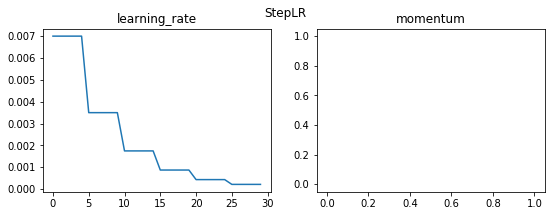

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'step_size': 5, 
    'gamma': 0.5
}
CFG.scheduler = optim.lr_scheduler.StepLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [34]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 0)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, warmup=100, init_lr=0.01, weight_decay=0):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))

        defaults = dict(lr=lr, beta=beta, eps=eps, warmup=warmup,
                        init_lr=init_lr, base_lr=lr, weight_decay=weight_decay)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [21]:
optim_list = [
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam,
     LookaheadDiffGrad, LookaheadYogi
]

# train

In [22]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [23]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: AggMo
fold 0


epoch1 save best model... 0.22790434126294556
epoch2 save best model... 0.025394335347556578
epoch3 save best model... 0.022275875898285988
epoch4 save best model... 0.02135313930231781
epoch5 save best model... 0.020870045631920287
epoch6 save best model... 0.020637267413029365
epoch7 save best model... 0.020496583878484836
epoch8 save best model... 0.02039505593342906
epoch9 save best model... 0.020271544743134112
epoch10 save best model... 0.020174899626871176
epoch11 save best model... 0.02009835556183426
epoch12 save best model... 0.020046178763201947
epoch14 save best model... 0.019979460495852936
epoch15 save best model... 0.01989307902872155
epoch16 save best model... 0.01987850045305857
epoch18 save best model... 0.019845496663709165
epoch19 save best model... 0.019837072592627486
epoch20 save best model... 0.019835862266175567
epoch21 save best model... 0.01979613426334494
epoch23 save best model... 0.01974950777387972
epoch24 save best model... 0.019736455512447345
epoch25 s

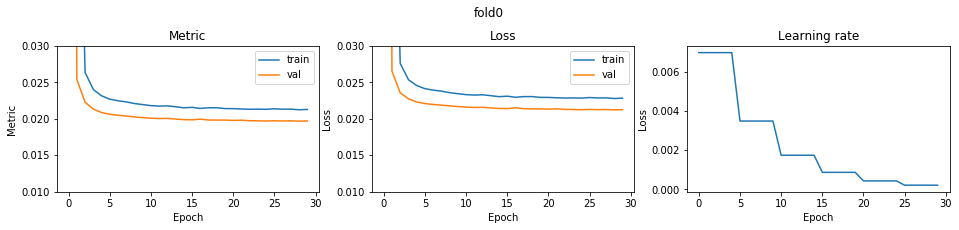

fold 1


epoch1 save best model... 0.24065871487502546
epoch2 save best model... 0.02567844070183522
epoch3 save best model... 0.02225172977090751
epoch4 save best model... 0.021407757820610333
epoch5 save best model... 0.020941034016256913
epoch6 save best model... 0.02076854962600095
epoch7 save best model... 0.020622800511097304
epoch8 save best model... 0.02057363652584085
epoch9 save best model... 0.020332771559464658
epoch10 save best model... 0.02032687232504336
epoch11 save best model... 0.020240663989824974
epoch13 save best model... 0.020137340814557616
epoch14 save best model... 0.020064726962495106
epoch15 save best model... 0.02003623933061757
epoch16 save best model... 0.020030378221643896
epoch17 save best model... 0.01999885494839659
epoch19 save best model... 0.019980691058875677
epoch20 save best model... 0.019965292150432686
epoch21 save best model... 0.019937724346542417
epoch22 save best model... 0.019935067555058462
epoch23 save best model... 0.01990973310853618
epoch25 sa

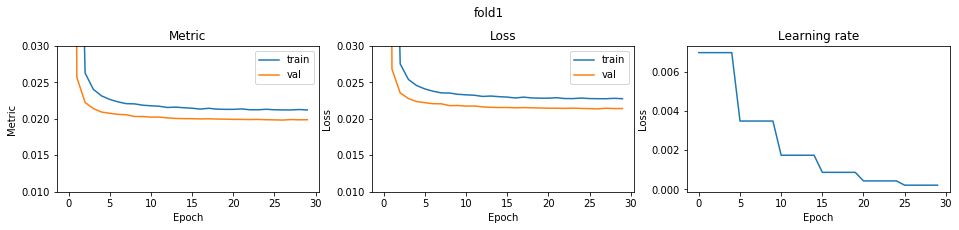

fold 2


epoch1 save best model... 0.24352102595137204
epoch2 save best model... 0.025613978842099778
epoch3 save best model... 0.022293242952035427
epoch4 save best model... 0.02140843861932213
epoch5 save best model... 0.020997881902074945
epoch6 save best model... 0.020875164300651478
epoch7 save best model... 0.020662322213907642
epoch8 save best model... 0.020585040495013505
epoch9 save best model... 0.02046938189261865
epoch10 save best model... 0.02044340732595893
epoch11 save best model... 0.020331018515852974
epoch12 save best model... 0.020282440647605097
epoch13 save best model... 0.020252612018590636
epoch14 save best model... 0.020213059078597294
epoch15 save best model... 0.020162923110440614
epoch16 save best model... 0.02016291789893858
epoch17 save best model... 0.02010593257672995
epoch20 save best model... 0.02007193061211001
epoch22 save best model... 0.020025375787415735
epoch26 save best model... 0.019990698718116803
fold2 score: 0.019990698663043135


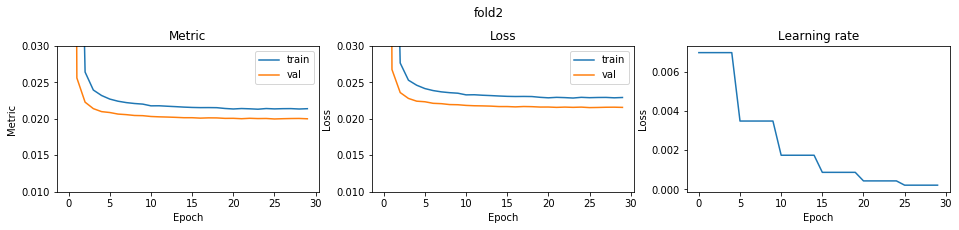

fold 3


epoch1 save best model... 0.2056085157570915
epoch2 save best model... 0.025008508227850418
epoch3 save best model... 0.022261623830316008
epoch4 save best model... 0.021437455903832083
epoch5 save best model... 0.020953491720496115
epoch6 save best model... 0.020838756867788376
epoch7 save best model... 0.020669609925588743
epoch8 save best model... 0.02050648522573886
epoch9 save best model... 0.02044001694997785
epoch10 save best model... 0.020336824500665984
epoch11 save best model... 0.020288712188499664
epoch12 save best model... 0.02023232498955075
epoch13 save best model... 0.02021579704796874
epoch14 save best model... 0.020183081571479456
epoch15 save best model... 0.020050790812183757
epoch18 save best model... 0.020010962475999206
epoch20 save best model... 0.020007166099694298
epoch22 save best model... 0.01996886442523611
epoch23 save best model... 0.019961722694116737
epoch25 save best model... 0.01995591551345478
epoch27 save best model... 0.01994481197853227
epoch28 sa

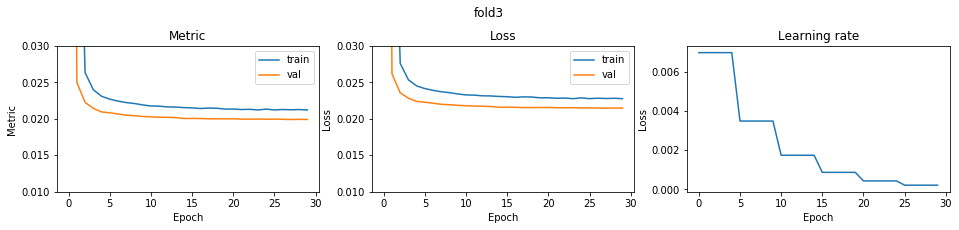

fold 4


epoch1 save best model... 0.21300618601687132
epoch2 save best model... 0.025084986995931095
epoch3 save best model... 0.021993812179545064
epoch4 save best model... 0.021175759320480405
epoch5 save best model... 0.020696337415851602
epoch6 save best model... 0.02052431689715331
epoch7 save best model... 0.02039472255898228
epoch8 save best model... 0.020303754169909722
epoch9 save best model... 0.020131366884077056
epoch10 save best model... 0.020064717933433746
epoch11 save best model... 0.020039848458013394
epoch12 save best model... 0.019973664836860465
epoch13 save best model... 0.01991453694777907
epoch14 save best model... 0.019862743529039256
epoch15 save best model... 0.019810916059958092
epoch16 save best model... 0.019779706658086905
epoch17 save best model... 0.01976710764737906
epoch19 save best model... 0.019742964141087813
epoch20 save best model... 0.01972732393915398
epoch22 save best model... 0.01971992826034105
epoch23 save best model... 0.019696326189778388
epoch24 

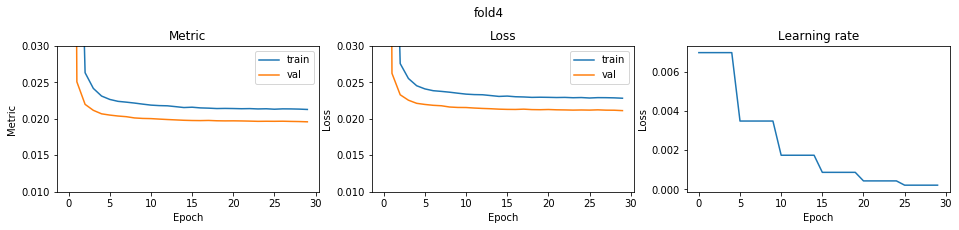

CV score: 0.019807094258687392

optimizer: Apollo
fold 0


epoch1 save best model... 0.7039063529979124
epoch2 save best model... 0.6988165043209571
epoch3 save best model... 0.6872653746387681
epoch4 save best model... 0.6804097403426377
epoch5 save best model... 0.6747696664447393
epoch6 save best model... 0.6711262087072489
epoch7 save best model... 0.6657118739734207
epoch8 save best model... 0.6634223495637638
epoch9 save best model... 0.6573236479846112
epoch10 save best model... 0.6540286625436336
epoch11 save best model... 0.6486276049820329
epoch12 save best model... 0.6482178393420435
epoch13 save best model... 0.6447708372374602
epoch14 save best model... 0.6420837800160627
epoch16 save best model... 0.6408739778338369
epoch17 save best model... 0.6389633257188123
epoch18 save best model... 0.6368515619384401
epoch19 save best model... 0.634810571274073
epoch20 save best model... 0.6344321108624712
epoch22 save best model... 0.6331512677913917
epoch24 save best model... 0.6311254208343176
epoch26 save best model... 0.629263039357569

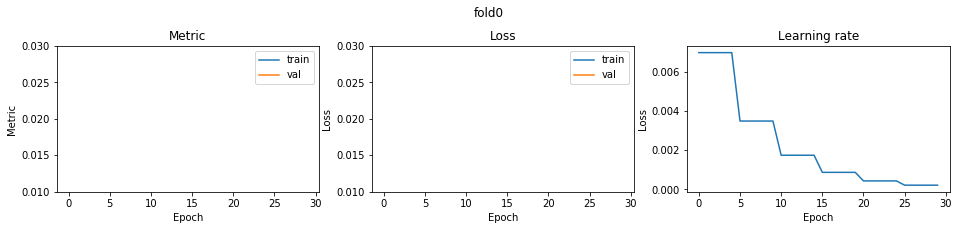

fold 1


epoch1 save best model... 0.7026041042671629
epoch2 save best model... 0.6946050419191424
epoch3 save best model... 0.686188830183698
epoch4 save best model... 0.6781582413786608
epoch5 save best model... 0.6727222166047278
epoch6 save best model... 0.6665938894497178
epoch7 save best model... 0.6618960123448905
epoch8 save best model... 0.6574828666281554
epoch9 save best model... 0.6515360778109798
epoch10 save best model... 0.6464994478725469
epoch11 save best model... 0.646136250032002
epoch12 save best model... 0.6435631269826301
epoch13 save best model... 0.6420697438795655
epoch14 save best model... 0.6379726076620428
epoch15 save best model... 0.6361199294985712
epoch16 save best model... 0.6335052336965289
epoch17 save best model... 0.6332479153659409
epoch19 save best model... 0.6304416508467112
epoch20 save best model... 0.62779587744906
epoch22 save best model... 0.6274407640299837
epoch23 save best model... 0.627103711157786
epoch25 save best model... 0.6253966015247311
ep

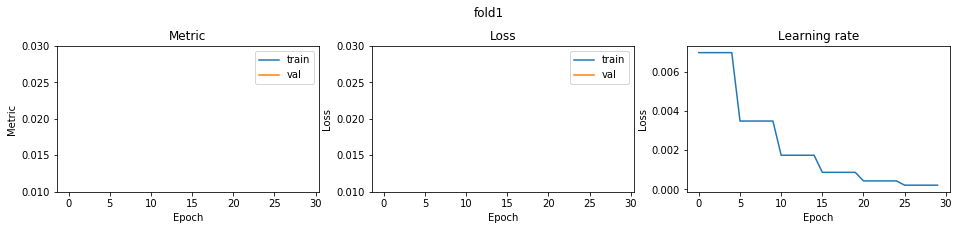

fold 2


epoch1 save best model... 0.7012703710711609
epoch2 save best model... 0.697018890153794
epoch3 save best model... 0.6864827169076977
epoch4 save best model... 0.678129461719333
epoch5 save best model... 0.6718436760005008
epoch6 save best model... 0.6655558952304165
epoch7 save best model... 0.6617707289224009
epoch8 save best model... 0.6579995160495048
epoch9 save best model... 0.6538128645878007
epoch10 save best model... 0.6482705977463348
epoch11 save best model... 0.6466191253349216
epoch12 save best model... 0.6432743205326678
epoch14 save best model... 0.6410382989463841
epoch15 save best model... 0.6349771772166487
epoch16 save best model... 0.6344939887890324
epoch17 save best model... 0.632727077716737
epoch19 save best model... 0.6294182314772789
epoch21 save best model... 0.6281415723157271
epoch22 save best model... 0.6278019679057134
epoch23 save best model... 0.6261296492824524
epoch25 save best model... 0.6256844937244562
epoch26 save best model... 0.6241197191682973


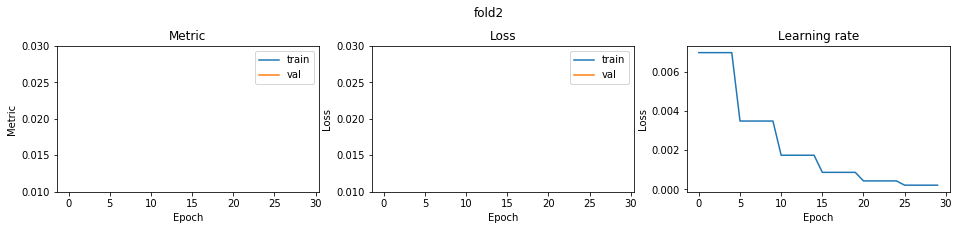

fold 3


epoch1 save best model... 0.6988382389170705
epoch2 save best model... 0.6927108961248724
epoch3 save best model... 0.6856278593284937
epoch4 save best model... 0.678394498124481
epoch5 save best model... 0.6683758202066182
epoch6 save best model... 0.6672446983821843
epoch7 save best model... 0.661556865223991
epoch8 save best model... 0.6577258307461314
epoch9 save best model... 0.6547193041695006
epoch10 save best model... 0.6509260650104706
epoch11 save best model... 0.6479624979045233
epoch12 save best model... 0.6441920342640888
epoch13 save best model... 0.6437018060738514
epoch14 save best model... 0.6409569511924084
epoch15 save best model... 0.6366201209315949
epoch16 save best model... 0.6353926731133516
epoch17 save best model... 0.6325725563294795
epoch19 save best model... 0.6312817153192055
epoch20 save best model... 0.6311282481853946
epoch21 save best model... 0.6295111175278596
epoch23 save best model... 0.6267755736522631
epoch25 save best model... 0.6266187568731895

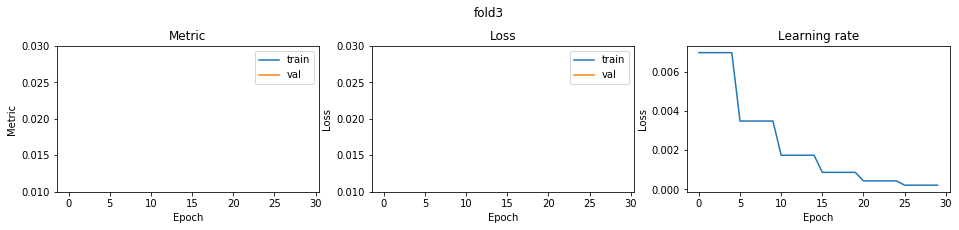

fold 4


epoch1 save best model... 0.7072412000158653
epoch2 save best model... 0.698019442308465
epoch3 save best model... 0.6922336977815302
epoch4 save best model... 0.6825900534834025
epoch5 save best model... 0.6730423382311584
epoch6 save best model... 0.6672896918240332
epoch7 save best model... 0.6660785169970744
epoch8 save best model... 0.6612776958317854
epoch9 save best model... 0.6560312760718048
epoch10 save best model... 0.6511901322421288
epoch11 save best model... 0.6475552316407136
epoch12 save best model... 0.6474594597392853
epoch13 save best model... 0.6456625992996546
epoch14 save best model... 0.6413739801539375
epoch15 save best model... 0.6369349599970772
epoch17 save best model... 0.6344109713895446
epoch19 save best model... 0.633188281379691
epoch20 save best model... 0.630726149467781
epoch22 save best model... 0.629610626002379
epoch25 save best model... 0.6289797245777278
epoch26 save best model... 0.6270431846855442
epoch29 save best model... 0.6266792829867648
e

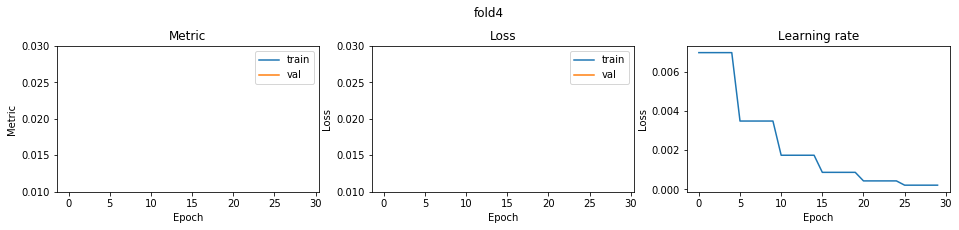

CV score: 0.6252036776780387

optimizer: PID
fold 0


epoch1 save best model... 0.7030631851769797
epoch2 save best model... 0.6924268961767401
epoch3 save best model... 0.6858774902880328
epoch4 save best model... 0.677931257885518
epoch5 save best model... 0.6710178560167891
epoch6 save best model... 0.6680756169190982
epoch7 save best model... 0.6623787685244393
epoch8 save best model... 0.6564504210932651
epoch9 save best model... 0.6532224888953642
epoch10 save best model... 0.6462552575967306
epoch12 save best model... 0.6447337416418593
epoch13 save best model... 0.6422168472361728
epoch14 save best model... 0.6387716385932609
epoch15 save best model... 0.6364238821020973
epoch16 save best model... 0.6344876824315968
epoch17 save best model... 0.6328586657117874
epoch18 save best model... 0.6322885732444381
epoch19 save best model... 0.6292444270129628
epoch20 save best model... 0.6285099363815811
epoch22 save best model... 0.6282809891570402
epoch23 save best model... 0.6266920380548898
epoch25 save best model... 0.625524511125473

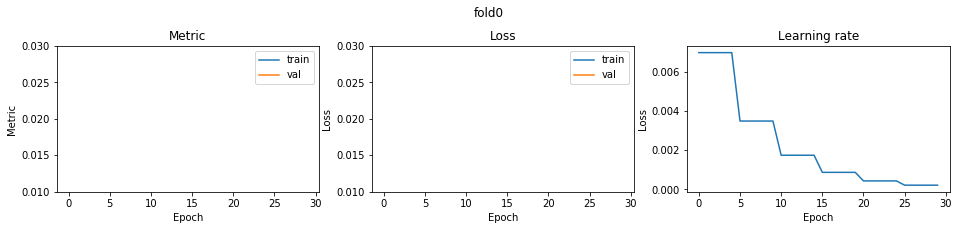

fold 1


epoch1 save best model... 0.703469315974526
epoch2 save best model... 0.6928486288558054
epoch3 save best model... 0.6867881971493102
epoch4 save best model... 0.6797750618985259
epoch5 save best model... 0.671116265981174
epoch6 save best model... 0.6648636968213514
epoch7 save best model... 0.6621979414180895
epoch8 save best model... 0.6586664769502294
epoch9 save best model... 0.6536200283110943
epoch10 save best model... 0.6489223465612033
epoch11 save best model... 0.6461818063278137
epoch12 save best model... 0.6437545903290179
epoch13 save best model... 0.6414892451587694
epoch14 save best model... 0.6377720910233337
epoch16 save best model... 0.6356478881173211
epoch17 save best model... 0.6317909744259002
epoch19 save best model... 0.6300254593842881
epoch20 save best model... 0.6294090006611672
epoch22 save best model... 0.628923195020624
epoch23 save best model... 0.6274521610111603
epoch24 save best model... 0.6252260763570752
epoch25 save best model... 0.6246244144157224


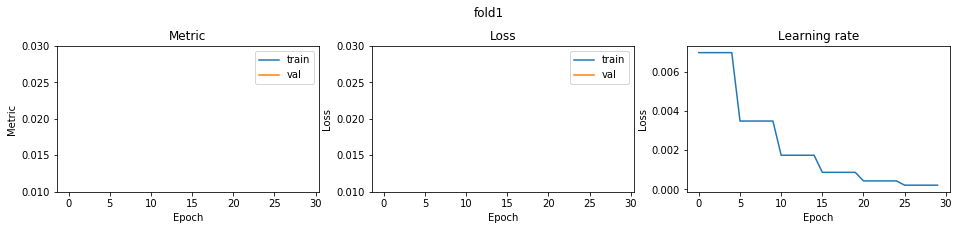

fold 2


epoch1 save best model... 0.7090766421752847
epoch2 save best model... 0.6970108508058767
epoch3 save best model... 0.689379162765576
epoch4 save best model... 0.6822178095721743
epoch5 save best model... 0.673713075894651
epoch6 save best model... 0.6699489019649886
epoch7 save best model... 0.6667145684439546
epoch8 save best model... 0.6619051218195803
epoch9 save best model... 0.6567640393653256
epoch10 save best model... 0.6529218310455875
epoch11 save best model... 0.6514670997552487
epoch12 save best model... 0.6465297708969829
epoch13 save best model... 0.6441238695408875
epoch14 save best model... 0.6416970336592043
epoch15 save best model... 0.6378489447552622
epoch17 save best model... 0.6368373064767747
epoch18 save best model... 0.6356863271785397
epoch19 save best model... 0.6342417216567141
epoch20 save best model... 0.6324764952949685
epoch22 save best model... 0.6302714642806976
epoch24 save best model... 0.6301598873190577
epoch25 save best model... 0.6296739888017393

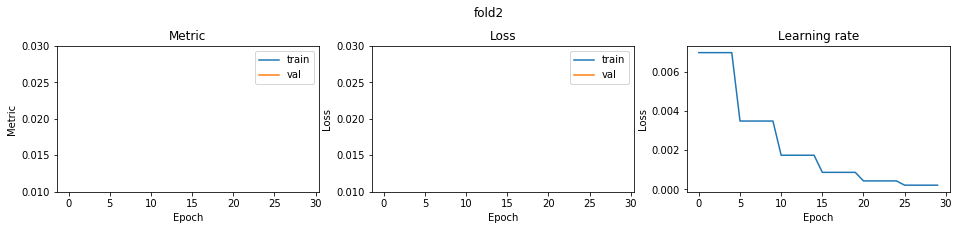

fold 3


epoch1 save best model... 0.6942561561534508
epoch2 save best model... 0.687098095493056
epoch3 save best model... 0.6798224353301497
epoch4 save best model... 0.6741140729202496
epoch5 save best model... 0.6647285706089949
epoch6 save best model... 0.6602810020055749
epoch7 save best model... 0.6563147628768973
epoch8 save best model... 0.6537984977279002
epoch9 save best model... 0.6483259725950845
epoch10 save best model... 0.6445179010849608
epoch11 save best model... 0.6409235500800582
epoch12 save best model... 0.6393665037828589
epoch13 save best model... 0.6368037479613528
epoch14 save best model... 0.634711861664722
epoch15 save best model... 0.632016060808525
epoch16 save best model... 0.6302598223327776
epoch17 save best model... 0.6287103718125467
epoch18 save best model... 0.6277936720902393
epoch19 save best model... 0.6268998137639161
epoch20 save best model... 0.6252965268621684
epoch21 save best model... 0.6238638362200222
epoch23 save best model... 0.6233209551059575


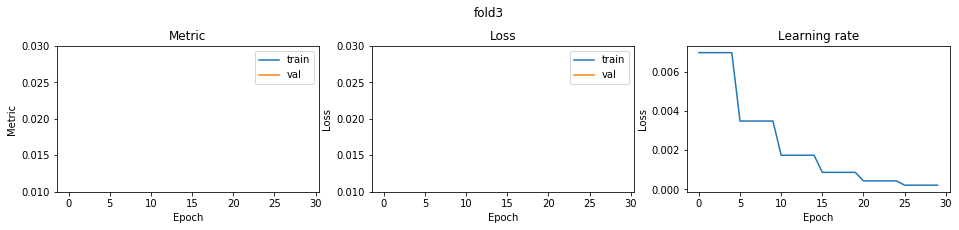

fold 4


epoch1 save best model... 0.7030464104204894
epoch2 save best model... 0.6970071276662562
epoch3 save best model... 0.6888804896545845
epoch4 save best model... 0.6810897828506174
epoch5 save best model... 0.6719839246778119
epoch6 save best model... 0.6675510515384631
epoch7 save best model... 0.6640605786395236
epoch8 save best model... 0.6593117199345981
epoch9 save best model... 0.6553078773352986
epoch10 save best model... 0.6510927021367675
epoch11 save best model... 0.6493305662769935
epoch12 save best model... 0.6475987368401199
epoch13 save best model... 0.6446047768505939
epoch14 save best model... 0.6417682394894489
epoch15 save best model... 0.6395491561748444
epoch16 save best model... 0.6380117497031401
epoch18 save best model... 0.6351969816961701
epoch19 save best model... 0.6333880645267512
epoch20 save best model... 0.6321076845796885
epoch21 save best model... 0.6312153388536058
epoch22 save best model... 0.6304555872578285
epoch23 save best model... 0.62929909932586

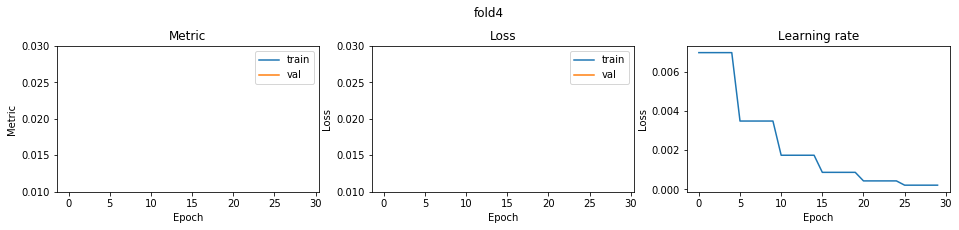

CV score: 0.6238966582817359

optimizer: QHM
fold 0


epoch1 save best model... 0.7100165212887566
epoch2 save best model... 0.7004199772869536
epoch3 save best model... 0.6912441770959824
epoch4 save best model... 0.6855582010230062
epoch5 save best model... 0.6754513721802783
epoch6 save best model... 0.672230736296921
epoch7 save best model... 0.6689221937455457
epoch8 save best model... 0.6632475266695566
epoch9 save best model... 0.6588202863727995
epoch10 save best model... 0.6541747033460266
epoch11 save best model... 0.6509619744329084
epoch12 save best model... 0.6483389338491174
epoch13 save best model... 0.6475416330921895
epoch14 save best model... 0.6431458274975996
epoch15 save best model... 0.6400344959152586
epoch17 save best model... 0.6399107686207887
epoch18 save best model... 0.6372357142270291
epoch20 save best model... 0.63593983549735
epoch21 save best model... 0.6333380486536134
epoch22 save best model... 0.6321905773158497
epoch23 save best model... 0.6320486578419974
epoch25 save best model... 0.6317735814559432


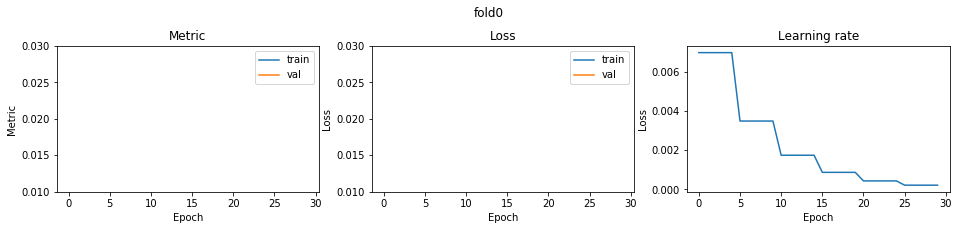

fold 1


epoch1 save best model... 0.7024340213200693
epoch2 save best model... 0.6935882085573974
epoch3 save best model... 0.6859819149069266
epoch4 save best model... 0.6809050346675672
epoch5 save best model... 0.6704908936407767
epoch6 save best model... 0.6661206820772188
epoch7 save best model... 0.6630263456208583
epoch8 save best model... 0.6580383313030826
epoch9 save best model... 0.6517418719663466
epoch10 save best model... 0.64746397840974
epoch11 save best model... 0.6458448476768567
epoch12 save best model... 0.6451523480395789
epoch13 save best model... 0.6412902507268098
epoch14 save best model... 0.6384734166839123
epoch15 save best model... 0.63478633115655
epoch16 save best model... 0.6345881888442171
epoch17 save best model... 0.6338690313181483
epoch18 save best model... 0.6309759582357435
epoch19 save best model... 0.6276039511175845
epoch23 save best model... 0.6273909309345488
epoch24 save best model... 0.6259612735894743
epoch25 save best model... 0.6247973105282196
e

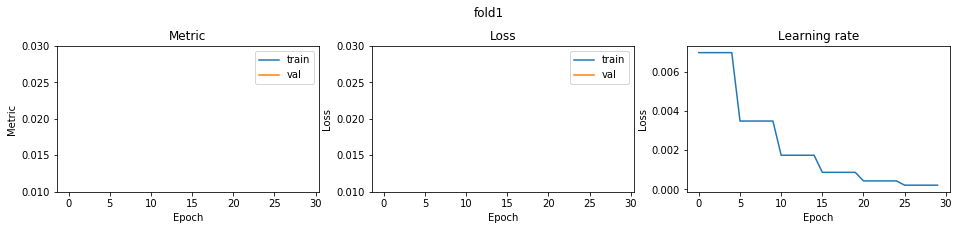

fold 2


epoch1 save best model... 0.7019058965990228
epoch2 save best model... 0.6967187674449175
epoch3 save best model... 0.6902989811276923
epoch4 save best model... 0.6803861698927219
epoch5 save best model... 0.674552109633146
epoch6 save best model... 0.6707556163512322
epoch7 save best model... 0.6660889651678124
epoch8 save best model... 0.6618695099252209
epoch9 save best model... 0.658158294715651
epoch10 save best model... 0.6553610489400489
epoch11 save best model... 0.6517577088484869
epoch12 save best model... 0.6498257849721111
epoch13 save best model... 0.6490670764166501
epoch14 save best model... 0.6457638988247165
epoch15 save best model... 0.6438860250350472
epoch16 save best model... 0.6419678963270946
epoch17 save best model... 0.6418129239926498
epoch18 save best model... 0.6390918147648134
epoch19 save best model... 0.6380554489786301
epoch20 save best model... 0.6368326670380925
epoch22 save best model... 0.6348128543000038
epoch25 save best model... 0.6336404522450156

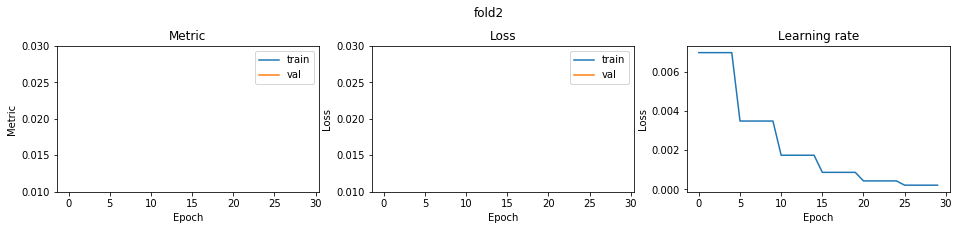

fold 3


epoch1 save best model... 0.7021031109510087
epoch2 save best model... 0.6937654688852523
epoch3 save best model... 0.6868316748147674
epoch4 save best model... 0.6790937538027492
epoch5 save best model... 0.6717787866168793
epoch6 save best model... 0.6665625214305174
epoch7 save best model... 0.6625924252431865
epoch8 save best model... 0.6585476989083519
epoch9 save best model... 0.6551227728978376
epoch10 save best model... 0.6508845375990814
epoch11 save best model... 0.6474806290552665
epoch12 save best model... 0.6465801613205929
epoch13 save best model... 0.6431430793568865
epoch14 save best model... 0.6390506791905552
epoch15 save best model... 0.6362476944380306
epoch17 save best model... 0.6347174110879659
epoch18 save best model... 0.6322962561337986
epoch20 save best model... 0.6307324132778107
epoch21 save best model... 0.6297351002150081
epoch23 save best model... 0.6272838310391593
epoch24 save best model... 0.6265974615863895
epoch26 save best model... 0.62655414856104

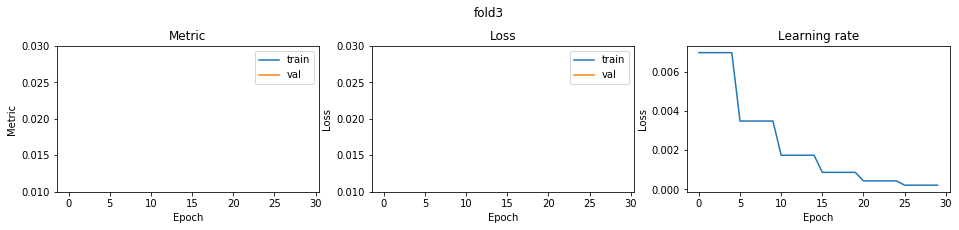

fold 4


epoch1 save best model... 0.7064377536806268
epoch2 save best model... 0.6990525558760606
epoch3 save best model... 0.6902900861173121
epoch4 save best model... 0.6820263131604379
epoch5 save best model... 0.6742003365638316
epoch6 save best model... 0.668344600108327
epoch7 save best model... 0.6646862019982045
epoch8 save best model... 0.6587719841535651
epoch9 save best model... 0.6552912971967988
epoch10 save best model... 0.6498995615572484
epoch11 save best model... 0.6491252014468634
epoch12 save best model... 0.6467689354761857
epoch13 save best model... 0.6427527579739859
epoch14 save best model... 0.6421110833152823
epoch15 save best model... 0.63901934702467
epoch16 save best model... 0.6376161323592984
epoch17 save best model... 0.6353350558965244
epoch18 save best model... 0.6347200808872666
epoch19 save best model... 0.633732207299365
epoch20 save best model... 0.6315377904505284
epoch21 save best model... 0.6309563231902676
epoch22 save best model... 0.6296027691597819
e

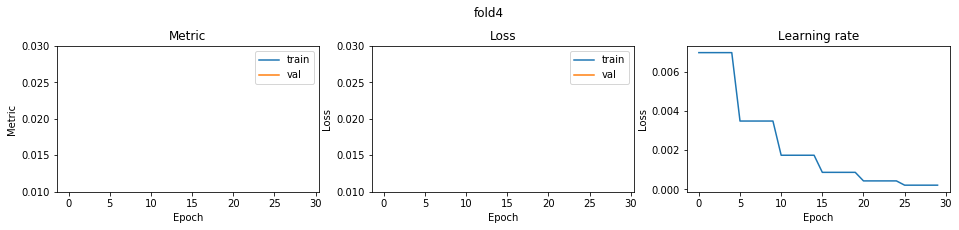

CV score: 0.6271493913762751

optimizer: SGDP
fold 0


epoch1 save best model... 0.7023057885484978
epoch2 save best model... 0.6927497441513392
epoch3 save best model... 0.6883266631454433
epoch4 save best model... 0.679359902444896
epoch5 save best model... 0.6692821983595916
epoch6 save best model... 0.666902348039362
epoch7 save best model... 0.66075013805359
epoch8 save best model... 0.6543609133070857
epoch9 save best model... 0.6537101493337975
epoch10 save best model... 0.6449846147133169
epoch11 save best model... 0.6420968223269816
epoch12 save best model... 0.6417901146384741
epoch13 save best model... 0.6389286127883372
epoch14 save best model... 0.6375532331933736
epoch15 save best model... 0.6338884693886533
epoch16 save best model... 0.6300468733750606
epoch17 save best model... 0.6297048327048439
epoch18 save best model... 0.6282550052521169
epoch19 save best model... 0.6268700216788637
epoch20 save best model... 0.6256220015686574
epoch21 save best model... 0.6245123892818877
epoch22 save best model... 0.6244896394788269
e

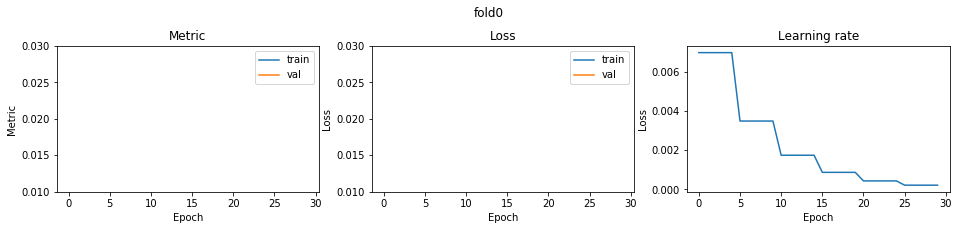

fold 1


epoch1 save best model... 0.7013997035896786
epoch2 save best model... 0.6917171196612717
epoch3 save best model... 0.6870738899118403
epoch4 save best model... 0.6766217512431463
epoch5 save best model... 0.6681880018493259
epoch6 save best model... 0.6649477221912011
epoch7 save best model... 0.6599737600792402
epoch8 save best model... 0.6563202847677202
epoch9 save best model... 0.6526549962746252
epoch10 save best model... 0.648460773148931
epoch11 save best model... 0.64664165540175
epoch12 save best model... 0.6431473155015149
epoch13 save best model... 0.6410607671406308
epoch14 save best model... 0.6386693579158144
epoch15 save best model... 0.6359572938999246
epoch17 save best model... 0.6337560388514436
epoch18 save best model... 0.6318716909163469
epoch20 save best model... 0.6302294374381417
epoch21 save best model... 0.6274534341658294
epoch22 save best model... 0.6269187645587326
epoch23 save best model... 0.6269042885610415
epoch24 save best model... 0.6254493805074182


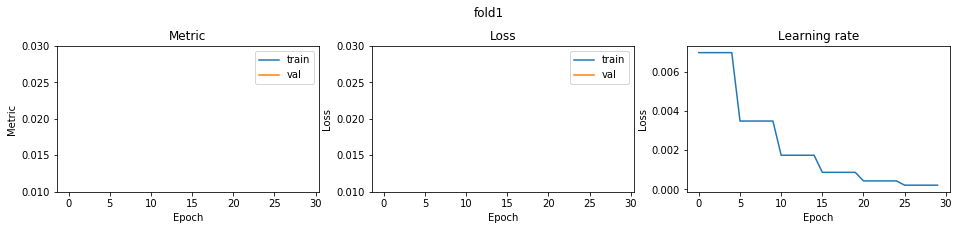

fold 2


epoch1 save best model... 0.7083552843564517
epoch2 save best model... 0.6988507798359589
epoch3 save best model... 0.6900771956395984
epoch4 save best model... 0.6825177776674987
epoch5 save best model... 0.6752224631232372
epoch6 save best model... 0.6714683837677683
epoch7 save best model... 0.6667248131773091
epoch8 save best model... 0.6644980279479654
epoch9 save best model... 0.6577113916782128
epoch10 save best model... 0.6559280248214129
epoch11 save best model... 0.6527294947878868
epoch12 save best model... 0.6486839475515465
epoch13 save best model... 0.648507973074397
epoch14 save best model... 0.6443137221766594
epoch15 save best model... 0.642748830326056
epoch16 save best model... 0.639361206736644
epoch18 save best model... 0.6376529680511951
epoch19 save best model... 0.6368807838348246
epoch20 save best model... 0.6357267498562618
epoch21 save best model... 0.6346095879709674
epoch22 save best model... 0.6338748236293537
epoch25 save best model... 0.6330414530518768


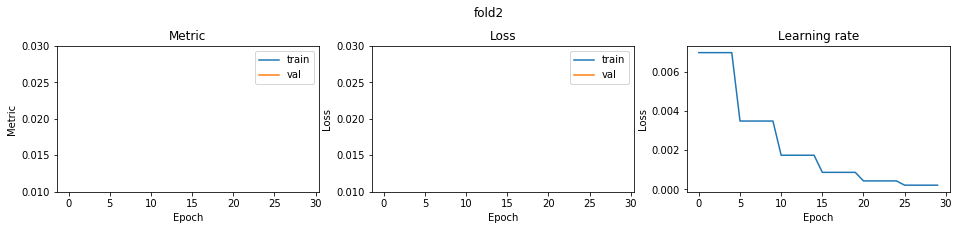

fold 3


epoch1 save best model... 0.7019993710083408
epoch2 save best model... 0.6945912260944045
epoch3 save best model... 0.6888411732360823
epoch4 save best model... 0.6792723746940595
epoch5 save best model... 0.670475835490607
epoch6 save best model... 0.6660419706331571
epoch7 save best model... 0.6631821074083889
epoch8 save best model... 0.657270887175019
epoch9 save best model... 0.6548653319647753
epoch10 save best model... 0.6490032513483782
epoch11 save best model... 0.6479514413108044
epoch12 save best model... 0.6443719727031734
epoch13 save best model... 0.6426610936064927
epoch14 save best model... 0.6396008022282281
epoch15 save best model... 0.6380071612316818
epoch16 save best model... 0.6365657756974865
epoch17 save best model... 0.6336509713550906
epoch19 save best model... 0.6316004621683873
epoch20 save best model... 0.6304558456079835
epoch21 save best model... 0.6290695197489918
epoch22 save best model... 0.6288864742107435
epoch23 save best model... 0.6272087674749196

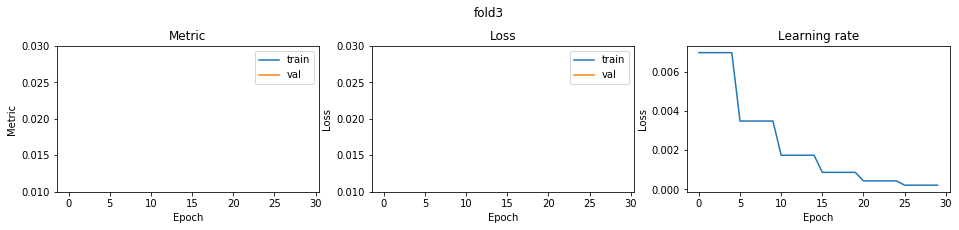

fold 4


epoch1 save best model... 0.705800934207195
epoch2 save best model... 0.6989052660644461
epoch3 save best model... 0.6893541510121426
epoch4 save best model... 0.6837605247193426
epoch5 save best model... 0.676215347260712
epoch6 save best model... 0.6698741804494401
epoch7 save best model... 0.6666193493134883
epoch8 save best model... 0.6623205506991688
epoch9 save best model... 0.6590569066566867
epoch10 save best model... 0.6533652811495753
epoch11 save best model... 0.6514274152101851
epoch12 save best model... 0.6492477415362904
epoch13 save best model... 0.6482130503328624
epoch14 save best model... 0.6445103084579415
epoch15 save best model... 0.6429817120143656
epoch16 save best model... 0.639876579450855
epoch18 save best model... 0.639209208727426
epoch19 save best model... 0.6384997163383728
epoch20 save best model... 0.6364248274127552
epoch21 save best model... 0.6354391118388513
epoch23 save best model... 0.634080379617513
epoch24 save best model... 0.6335553423418814
ep

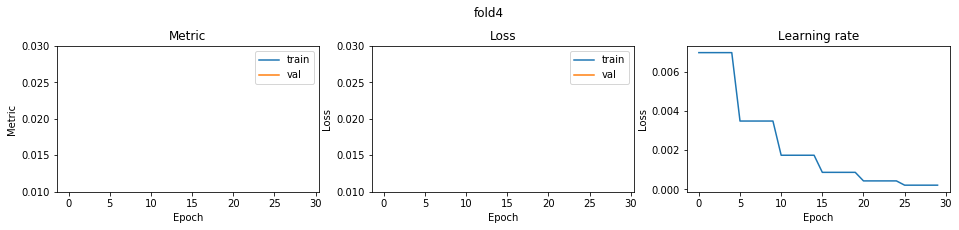

CV score: 0.6255297095443624

optimizer: SGDW
fold 0


epoch1 save best model... 0.7064299943235306
epoch2 save best model... 0.6953980601458452
epoch3 save best model... 0.6894289090312966
epoch4 save best model... 0.6812877237117915
epoch5 save best model... 0.6744885486187859
epoch6 save best model... 0.6707908190464376
epoch7 save best model... 0.6663705372050032
epoch8 save best model... 0.664382118353268
epoch9 save best model... 0.6578728668510506
epoch10 save best model... 0.6523436513740001
epoch11 save best model... 0.6499483097115519
epoch12 save best model... 0.6489131664903941
epoch13 save best model... 0.6469842637861508
epoch14 save best model... 0.6435891506883712
epoch15 save best model... 0.6414472924821197
epoch16 save best model... 0.6403800671898966
epoch17 save best model... 0.6397151219274568
epoch18 save best model... 0.637856318440144
epoch19 save best model... 0.6367994732357103
epoch21 save best model... 0.6335152094890968
epoch22 save best model... 0.6333367073182907
epoch23 save best model... 0.6322485159632828

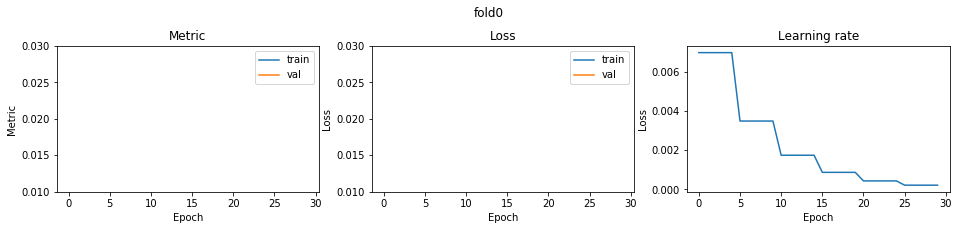

fold 1


epoch1 save best model... 0.7021474371224771
epoch2 save best model... 0.6972645283370063
epoch3 save best model... 0.6869486070597299
epoch4 save best model... 0.6802178978458248
epoch5 save best model... 0.6730569476118716
epoch6 save best model... 0.6683879867043303
epoch7 save best model... 0.6652429898987329
epoch8 save best model... 0.6608437808452475
epoch9 save best model... 0.6557940698669504
epoch10 save best model... 0.6521292174560493
epoch11 save best model... 0.6485093015015437
epoch12 save best model... 0.6462582343801818
epoch13 save best model... 0.6447171470955418
epoch14 save best model... 0.6408748463336035
epoch15 save best model... 0.6393305124631365
epoch16 save best model... 0.6362725446723431
epoch18 save best model... 0.6358026325444639
epoch19 save best model... 0.6348055295831224
epoch20 save best model... 0.632723339341664
epoch21 save best model... 0.632432560927234
epoch22 save best model... 0.6314566009923032
epoch23 save best model... 0.6306297910542118

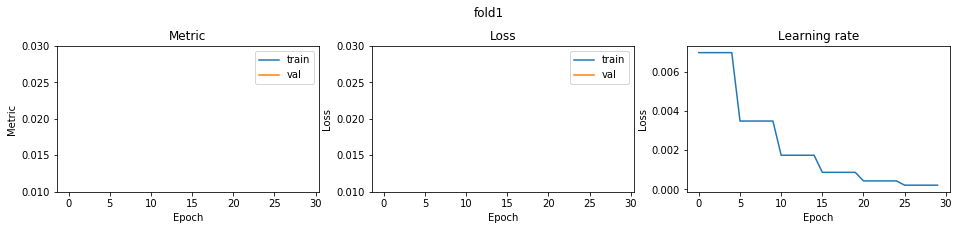

fold 2


epoch1 save best model... 0.7025834206134373
epoch2 save best model... 0.6967423015559934
epoch3 save best model... 0.6872206446140713
epoch4 save best model... 0.682520074082768
epoch5 save best model... 0.6722502048560443
epoch6 save best model... 0.6673145584403912
epoch7 save best model... 0.6635465418920345
epoch8 save best model... 0.6621069206168043
epoch9 save best model... 0.657487804755504
epoch10 save best model... 0.6519895706178931
epoch11 save best model... 0.6487795656785033
epoch12 save best model... 0.6456377393266666
epoch13 save best model... 0.6448456867867273
epoch14 save best model... 0.6420478533845634
epoch15 save best model... 0.6385084293268352
epoch16 save best model... 0.6383339277321995
epoch17 save best model... 0.6371116299486889
epoch19 save best model... 0.6323418930413973
epoch20 save best model... 0.6322739708529542
epoch21 save best model... 0.6310395944849129
epoch23 save best model... 0.630882971078721
epoch24 save best model... 0.6301060553073992


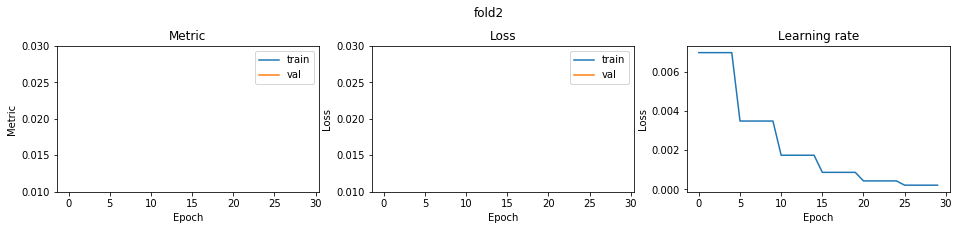

fold 3


epoch1 save best model... 0.7066791858108277
epoch2 save best model... 0.6966558208769709
epoch3 save best model... 0.6906326583957889
epoch4 save best model... 0.6839240454324014
epoch5 save best model... 0.6753818029966333
epoch6 save best model... 0.6713017725455733
epoch7 save best model... 0.6676482400209865
epoch8 save best model... 0.6636083587970169
epoch9 save best model... 0.6601066599945815
epoch10 save best model... 0.654789682808661
epoch11 save best model... 0.6534215246354801
epoch12 save best model... 0.6515156838508294
epoch13 save best model... 0.6494965607321616
epoch14 save best model... 0.6473021279706499
epoch15 save best model... 0.6442357833673308
epoch17 save best model... 0.6418564564274764
epoch18 save best model... 0.6409647553548183
epoch19 save best model... 0.6395392023349405
epoch20 save best model... 0.6389791125588645
epoch21 save best model... 0.6388965883939304
epoch22 save best model... 0.6367574997806332
epoch23 save best model... 0.635862162580251

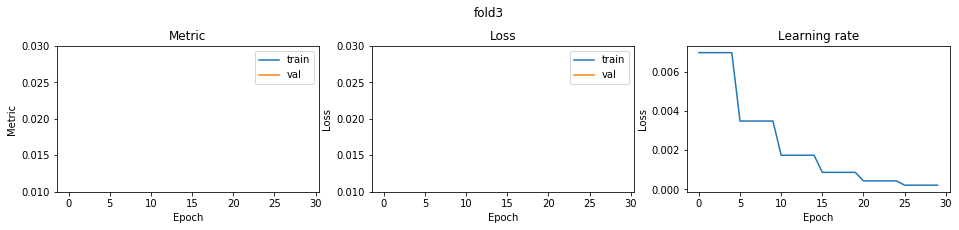

fold 4


epoch1 save best model... 0.704513961280397
epoch2 save best model... 0.695943126347179
epoch3 save best model... 0.68915094729165
epoch4 save best model... 0.6803250457268369
epoch5 save best model... 0.6724899444058707
epoch6 save best model... 0.6675668789205356
epoch7 save best model... 0.6633660872324724
epoch8 save best model... 0.6587549202806042
epoch9 save best model... 0.6540251408731205
epoch10 save best model... 0.6489235397080354
epoch11 save best model... 0.6465438452559886
epoch12 save best model... 0.6448367662744805
epoch13 save best model... 0.6425616484839716
epoch14 save best model... 0.6399054739632748
epoch15 save best model... 0.637617095048987
epoch16 save best model... 0.6359225668776822
epoch18 save best model... 0.6339159660295908
epoch19 save best model... 0.6322522702955711
epoch20 save best model... 0.6311722940355878
epoch21 save best model... 0.629995037673003
epoch22 save best model... 0.6294373522043771
epoch23 save best model... 0.6274091908220278
epo

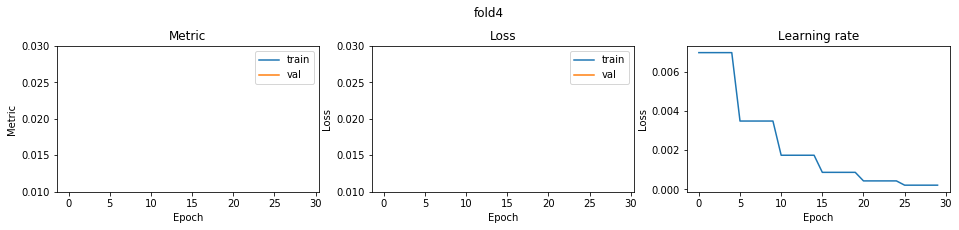

CV score: 0.6289395578722737

optimizer: SGD
fold 0


epoch1 save best model... 0.7047862804832111
epoch2 save best model... 0.6962169581230789
epoch3 save best model... 0.6878680012220674
epoch4 save best model... 0.6783055039636094
epoch5 save best model... 0.6729867468390758
epoch6 save best model... 0.666515475660902
epoch7 save best model... 0.6613768548520117
epoch8 save best model... 0.6592643467060254
epoch9 save best model... 0.6524799653500793
epoch10 save best model... 0.6474536673083121
epoch11 save best model... 0.646390545639742
epoch12 save best model... 0.6442978690316845
epoch13 save best model... 0.6409782247554197
epoch14 save best model... 0.6388753393788001
epoch15 save best model... 0.6384783687787067
epoch16 save best model... 0.6352871902439752
epoch17 save best model... 0.6332550881663868
epoch19 save best model... 0.6322268528927432
epoch20 save best model... 0.6290596561171199
epoch22 save best model... 0.6279870856595745
epoch23 save best model... 0.6269136820947391
epoch24 save best model... 0.6268262548707341

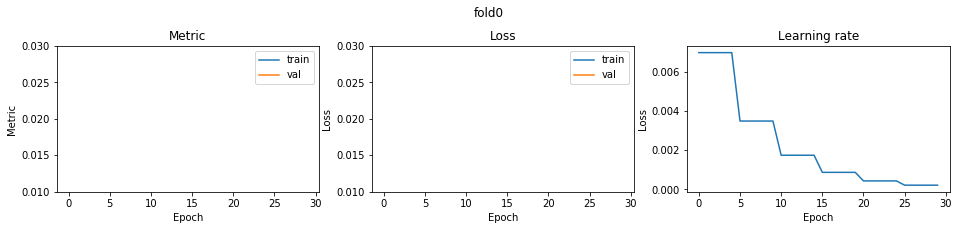

fold 1


epoch1 save best model... 0.7042755928797884
epoch2 save best model... 0.6970991577964134
epoch3 save best model... 0.6908792430867255
epoch4 save best model... 0.6826594877715642
epoch5 save best model... 0.6732109352678067
epoch6 save best model... 0.6699050095065576
epoch7 save best model... 0.6647131828165564
epoch8 save best model... 0.6608062533317544
epoch9 save best model... 0.6571586462597989
epoch10 save best model... 0.6519586110772345
epoch11 save best model... 0.6496831796032934
epoch12 save best model... 0.6468892373428119
epoch13 save best model... 0.644525481807694
epoch14 save best model... 0.6421586932395036
epoch15 save best model... 0.6406199922320457
epoch16 save best model... 0.6379592744330117
epoch17 save best model... 0.6363081969549944
epoch18 save best model... 0.6349088607059304
epoch20 save best model... 0.6330195670927486
epoch21 save best model... 0.6321154600885687
epoch22 save best model... 0.6318265245834823
epoch23 save best model... 0.629089753756519

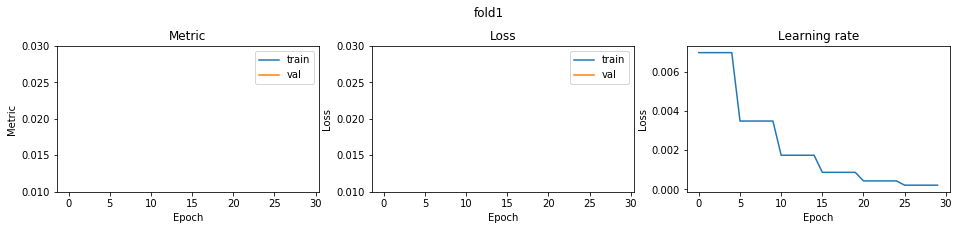

fold 2


epoch1 save best model... 0.7010165892964101
epoch2 save best model... 0.6932666854316266
epoch3 save best model... 0.6838297184058489
epoch4 save best model... 0.6778993201190612
epoch5 save best model... 0.6674222025683323
epoch6 save best model... 0.6617249566429323
epoch7 save best model... 0.6598406335329189
epoch8 save best model... 0.6566558564054202
epoch9 save best model... 0.6492297788854883
epoch10 save best model... 0.6456260974761918
epoch11 save best model... 0.6432158479144074
epoch12 save best model... 0.6420066810789562
epoch13 save best model... 0.6389358720249237
epoch14 save best model... 0.6352818358539313
epoch15 save best model... 0.6327070721897674
epoch16 save best model... 0.631304081126209
epoch17 save best model... 0.6291440560052324
epoch18 save best model... 0.6280819575263471
epoch19 save best model... 0.6269415059782807
epoch20 save best model... 0.6251944278931938
epoch21 save best model... 0.6246154880463928
epoch24 save best model... 0.621771776396420

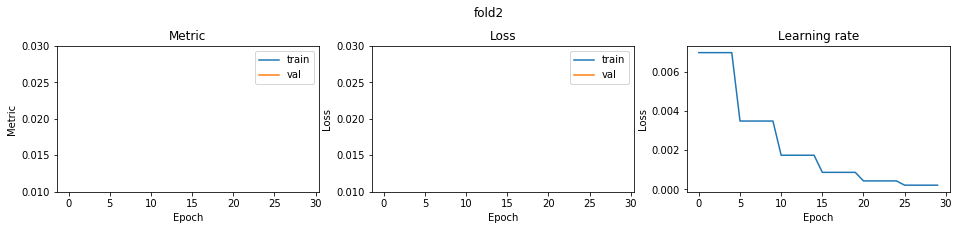

fold 3


epoch1 save best model... 0.7070768105141937
epoch2 save best model... 0.6977918754134471
epoch3 save best model... 0.6891415992467441
epoch4 save best model... 0.6812787863822625
epoch5 save best model... 0.6756271260202882
epoch6 save best model... 0.6702331538352445
epoch7 save best model... 0.6673460377104462
epoch8 save best model... 0.662507004129588
epoch9 save best model... 0.6569281704876581
epoch10 save best model... 0.6533048855416596
epoch11 save best model... 0.6503225206785702
epoch12 save best model... 0.6499052763256777
epoch13 save best model... 0.6465761402473362
epoch14 save best model... 0.6431800945201605
epoch15 save best model... 0.6422989338296964
epoch16 save best model... 0.6413666116621065
epoch17 save best model... 0.6391435331798632
epoch18 save best model... 0.6379104810043457
epoch19 save best model... 0.6357647476272322
epoch20 save best model... 0.635625486411918
epoch21 save best model... 0.6355443926498395
epoch22 save best model... 0.634751442325957


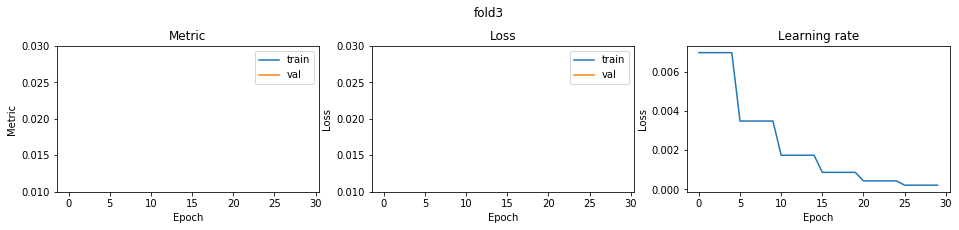

fold 4


epoch1 save best model... 0.7063460730474468
epoch2 save best model... 0.6996765344180931
epoch3 save best model... 0.6928050638874462
epoch4 save best model... 0.6840275758219743
epoch5 save best model... 0.6753730487986415
epoch6 save best model... 0.6713424327704792
epoch7 save best model... 0.6674174085021833
epoch8 save best model... 0.6638989988655055
epoch9 save best model... 0.6590275417699357
epoch10 save best model... 0.6548571318320099
epoch11 save best model... 0.6511103114940583
epoch12 save best model... 0.6491686686296397
epoch13 save best model... 0.6467503056439289
epoch14 save best model... 0.6445793160273436
epoch15 save best model... 0.6406573653764225
epoch16 save best model... 0.6399686336788881
epoch18 save best model... 0.6389338507196083
epoch19 save best model... 0.6358904222692607
epoch20 save best model... 0.6346031477619684
epoch22 save best model... 0.634375057323647
epoch24 save best model... 0.6321129844509116
epoch27 save best model... 0.630691512434792

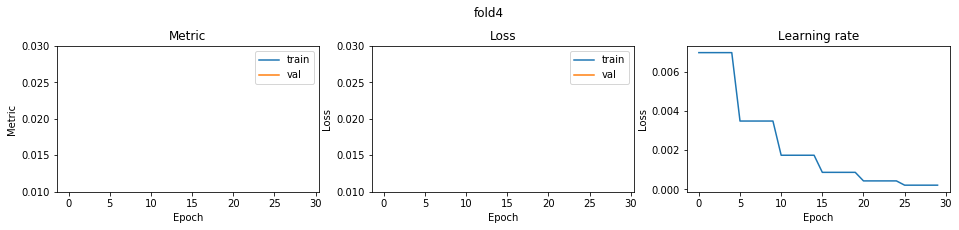

CV score: 0.6258163656156507

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019207456188620086
epoch2 save best model... 0.01825399353404387
epoch3 save best model... 0.017971758917822652
epoch4 save best model... 0.017422622682395177
epoch5 save best model... 0.017228647256121547
epoch6 save best model... 0.016962037882969155
epoch7 save best model... 0.016664917260442346
epoch9 save best model... 0.01661678444348055
epoch10 save best model... 0.01659485628374413
epoch11 save best model... 0.016294607382208313
epoch13 save best model... 0.016248246108803363
epoch16 save best model... 0.01621203747681917
fold0 score: 0.016212037355726516


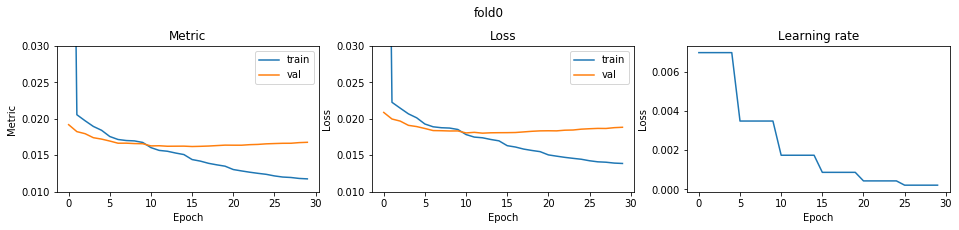

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01961196964366014
epoch2 save best model... 0.018505186145952472
epoch3 save best model... 0.018088732466464925
epoch4 save best model... 0.017551326298376208
epoch6 save best model... 0.01694761433630781
epoch7 save best model... 0.016934657125636396
epoch8 save best model... 0.016884980257282255
epoch9 save best model... 0.016782561006433168
epoch11 save best model... 0.016616515319995577
epoch12 save best model... 0.016483687976276338
fold1 score: 0.01648368793171567


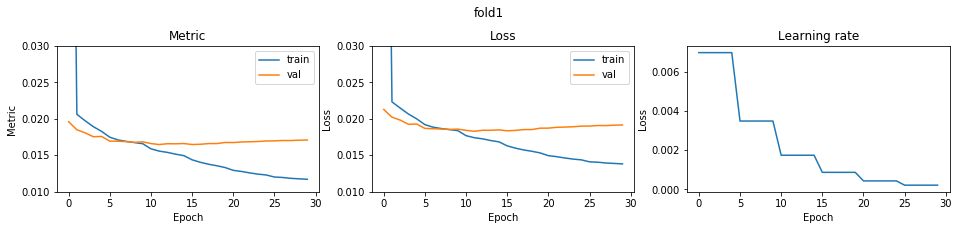

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01931642720572978
epoch2 save best model... 0.01843772965041366
epoch3 save best model... 0.017811845216707436
epoch4 save best model... 0.01754266510983451
epoch5 save best model... 0.017419450771420902
epoch6 save best model... 0.016853495681559503
epoch8 save best model... 0.01679893810701794
epoch9 save best model... 0.016647112313051122
epoch11 save best model... 0.016423180994299093
epoch12 save best model... 0.01633345962332943
epoch16 save best model... 0.016315978670382
fold2 score: 0.01631597855964839


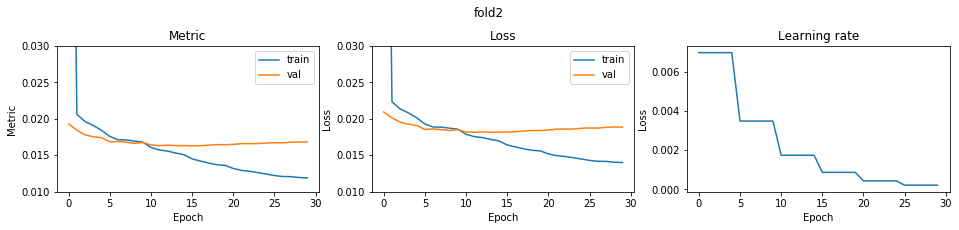

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019342106799669308
epoch2 save best model... 0.01857741132404036
epoch3 save best model... 0.01817074916739195
epoch4 save best model... 0.01770236577397395
epoch5 save best model... 0.017532012728732376
epoch6 save best model... 0.017039289917364073
epoch8 save best model... 0.01690926659928639
epoch9 save best model... 0.016892722699205668
epoch10 save best model... 0.016863373084447787
epoch11 save best model... 0.01662453946685058
epoch12 save best model... 0.01656179753787697
epoch15 save best model... 0.016504210758114188
epoch16 save best model... 0.016467432057005533
epoch17 save best model... 0.016465648837336647
epoch18 save best model... 0.016465178079020596
fold3 score: 0.016465177940417956


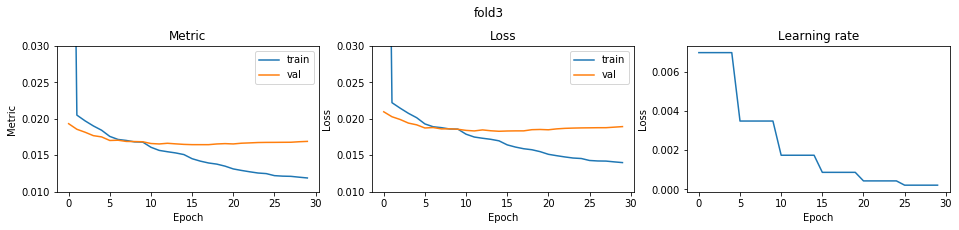

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019347576043464598
epoch2 save best model... 0.01827010081737283
epoch3 save best model... 0.017951707107466824
epoch4 save best model... 0.01763713894271905
epoch5 save best model... 0.017363224206980242
epoch6 save best model... 0.01692948567093369
epoch7 save best model... 0.016914552289373105
epoch8 save best model... 0.016872190414229937
epoch9 save best model... 0.016786251146269957
epoch11 save best model... 0.016510911297333133
epoch13 save best model... 0.016445779570024077
epoch15 save best model... 0.016415695277952794
epoch16 save best model... 0.01639764327598324
fold4 score: 0.01639687724492248


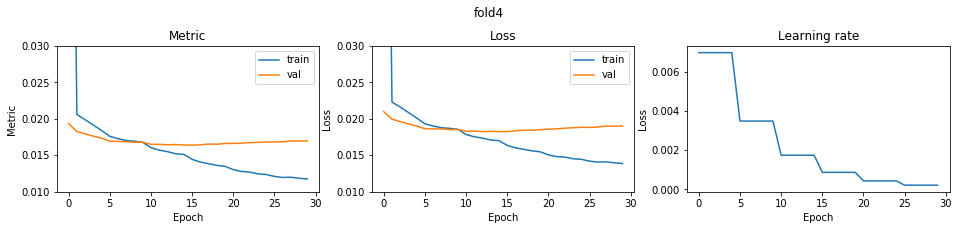

CV score: 0.016374749520953195

optimizer: AdaBound
fold 0


epoch1 save best model... 0.022285758261834026
epoch2 save best model... 0.02161738666915812
epoch3 save best model... 0.02127144378705421
epoch4 save best model... 0.021112452087614152
epoch5 save best model... 0.02096669846352249
epoch6 save best model... 0.020922481734517766
epoch7 save best model... 0.020911249028760643
epoch8 save best model... 0.02086433465157663
epoch9 save best model... 0.020806660963930954
epoch10 save best model... 0.020736455424330228
epoch12 save best model... 0.020730351234079764
epoch13 save best model... 0.020704847255165866
epoch14 save best model... 0.020686027951589477
epoch15 save best model... 0.02068371887240296
epoch20 save best model... 0.02067668584847912
epoch21 save best model... 0.02066042566065229
epoch24 save best model... 0.02064233945262595
epoch27 save best model... 0.020641249823033947
epoch29 save best model... 0.02063016572496207
fold0 score: 0.020630165661126763


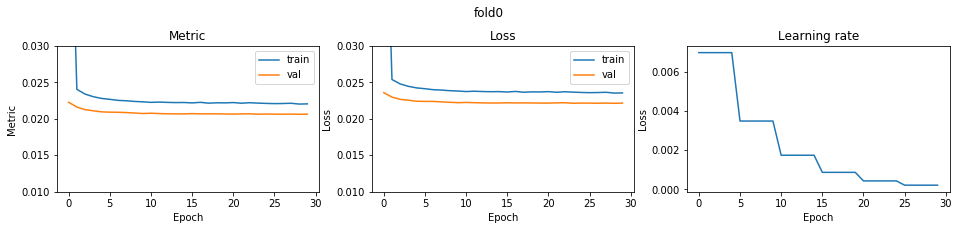

fold 1


epoch1 save best model... 0.02242248769069511
epoch2 save best model... 0.02162146424133255
epoch3 save best model... 0.02132112617265135
epoch4 save best model... 0.02111862670255905
epoch5 save best model... 0.0210321259536961
epoch6 save best model... 0.02093098881722556
epoch7 save best model... 0.020882493081485855
epoch8 save best model... 0.020832884430759695
epoch9 save best model... 0.020807220291377715
epoch10 save best model... 0.02077327869784984
epoch13 save best model... 0.020715457380690507
epoch16 save best model... 0.02069541268554845
epoch17 save best model... 0.02067426107883263
epoch20 save best model... 0.02066887827922405
epoch22 save best model... 0.020647888879660296
epoch23 save best model... 0.020644204039614682
epoch24 save best model... 0.020633968471373967
fold1 score: 0.020633968435505332


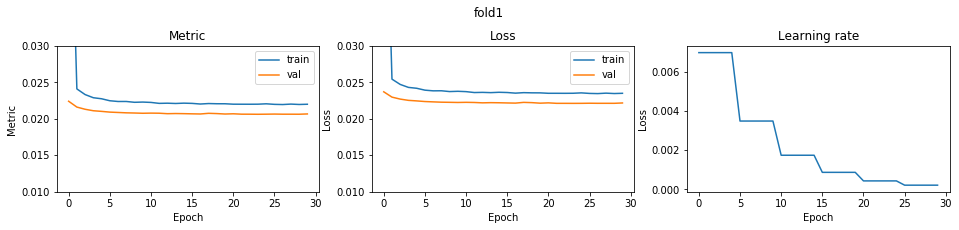

fold 2


epoch1 save best model... 0.022582083008971212
epoch2 save best model... 0.02167687552780979
epoch3 save best model... 0.021360005836659694
epoch4 save best model... 0.02113372290718729
epoch5 save best model... 0.020991500243833162
epoch6 save best model... 0.020921645108012
epoch7 save best model... 0.02086352645216892
epoch8 save best model... 0.02079109485880963
epoch9 save best model... 0.020774675110907997
epoch11 save best model... 0.02073172187548505
epoch13 save best model... 0.020685911673426927
epoch16 save best model... 0.020675595587479768
epoch17 save best model... 0.020661618493923457
epoch18 save best model... 0.020641438118938597
epoch20 save best model... 0.02063937581893957
epoch23 save best model... 0.020606664512505916
epoch29 save best model... 0.020598409050219584
fold2 score: 0.02059840906009893


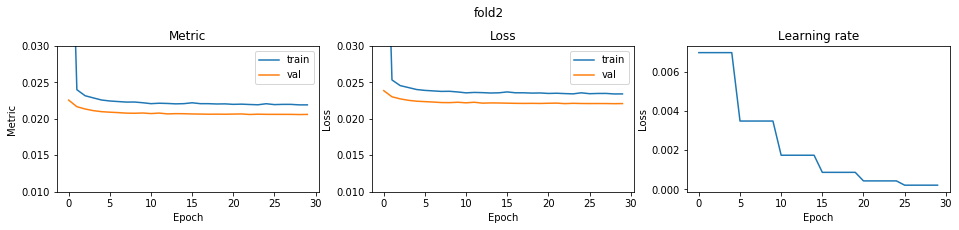

fold 3


epoch1 save best model... 0.022498222231729155
epoch2 save best model... 0.021698706358637247
epoch3 save best model... 0.021441439540042694
epoch4 save best model... 0.021232739056976074
epoch5 save best model... 0.021105374248193445
epoch6 save best model... 0.0210121139069353
epoch7 save best model... 0.020984398526964806
epoch8 save best model... 0.02096256192748123
epoch9 save best model... 0.020953038554205845
epoch10 save best model... 0.02088544313967703
epoch11 save best model... 0.02085619081057829
epoch12 save best model... 0.020852393077809474
epoch13 save best model... 0.020836756393262493
epoch14 save best model... 0.020813119589247166
epoch15 save best model... 0.02080620945110951
epoch17 save best model... 0.02079367338465463
epoch18 save best model... 0.020782196558672503
epoch20 save best model... 0.020758085675401813
epoch24 save best model... 0.02074737146556174
epoch26 save best model... 0.020739006965181415
fold3 score: 0.02073900711647896


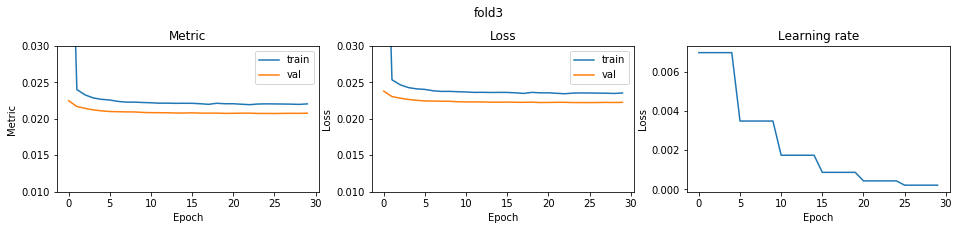

fold 4


epoch1 save best model... 0.02235848114216925
epoch2 save best model... 0.02156207610965454
epoch3 save best model... 0.02120350830019335
epoch4 save best model... 0.021046599712655593
epoch5 save best model... 0.0208855485055672
epoch6 save best model... 0.020871144151293878
epoch7 save best model... 0.02080632244281318
epoch8 save best model... 0.020778004500106962
epoch10 save best model... 0.020694574964888274
epoch12 save best model... 0.020687164465529772
epoch13 save best model... 0.02065949472418407
epoch14 save best model... 0.020640212693729
epoch16 save best model... 0.020628994001512645
epoch17 save best model... 0.020622107062429392
epoch18 save best model... 0.020620624900950388
epoch19 save best model... 0.02060645540119711
epoch20 save best model... 0.020592902996206065
epoch24 save best model... 0.020582873347068972
epoch25 save best model... 0.02057493535169572
epoch29 save best model... 0.020554835394296395
fold4 score: 0.020554835474417953


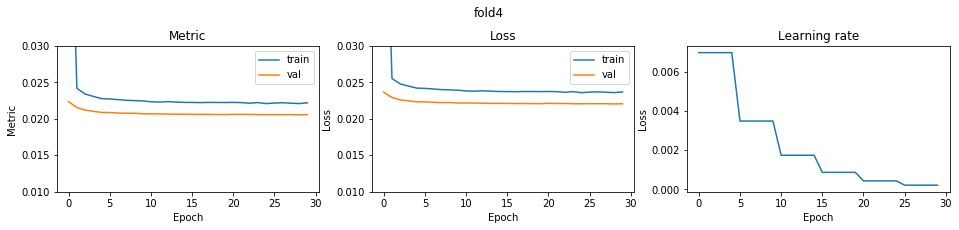

CV score: 0.02063127852444829

optimizer: AdaMod
fold 0


epoch1 save best model... 0.019727686352196207
epoch2 save best model... 0.01858988045067749
epoch3 save best model... 0.018089978758389965
epoch4 save best model... 0.017641699836846093
epoch5 save best model... 0.017398324125109065
epoch6 save best model... 0.016950872183219445
epoch7 save best model... 0.01685696463090005
epoch8 save best model... 0.016738999556062704
epoch9 save best model... 0.016623920694434833
epoch11 save best model... 0.01637030122525871
epoch12 save best model... 0.016366148174046656
epoch13 save best model... 0.016322643482094473
epoch14 save best model... 0.016302160575035494
epoch16 save best model... 0.016198810472541354
fold0 score: 0.016198810321197767


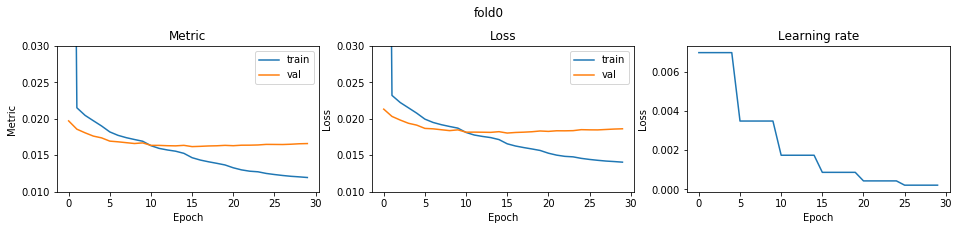

fold 1


epoch1 save best model... 0.020107851819724937
epoch2 save best model... 0.018892066226030815
epoch3 save best model... 0.018146036912963612
epoch4 save best model... 0.017935730113316218
epoch5 save best model... 0.01759616471869469
epoch6 save best model... 0.01714888025299275
epoch7 save best model... 0.017125192697769583
epoch9 save best model... 0.01694300726941375
epoch10 save best model... 0.016870399732902344
epoch11 save best model... 0.016669542997851408
epoch12 save best model... 0.01662420005469455
epoch13 save best model... 0.016588827147596068
epoch16 save best model... 0.01648291457536946
fold1 score: 0.016482914465390297


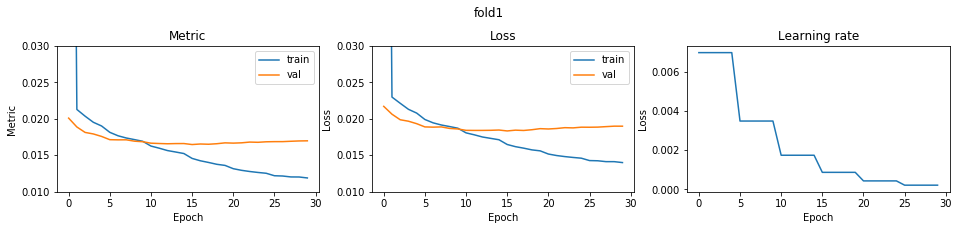

fold 2


epoch1 save best model... 0.019880531933332637
epoch2 save best model... 0.018589188187752546
epoch3 save best model... 0.017911190909750914
epoch4 save best model... 0.01767275070843297
epoch5 save best model... 0.017480433890101617
epoch6 save best model... 0.017027670120335327
epoch8 save best model... 0.016695155806909067
epoch10 save best model... 0.01660438612511725
epoch11 save best model... 0.016405687247283925
epoch16 save best model... 0.016307917498026656
fold2 score: 0.016307917296813378


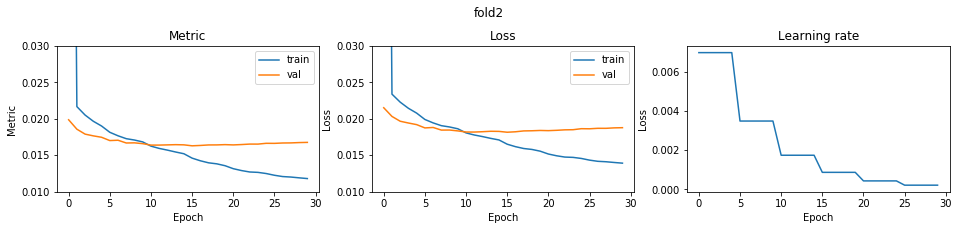

fold 3


epoch1 save best model... 0.020100376917927574
epoch2 save best model... 0.018684304679970943
epoch3 save best model... 0.018273472290800074
epoch4 save best model... 0.01788000681337843
epoch5 save best model... 0.017601280678530354
epoch6 save best model... 0.017167416310833093
epoch7 save best model... 0.016978288320973006
epoch8 save best model... 0.0169516800221794
epoch9 save best model... 0.016921598231313846
epoch11 save best model... 0.01661211625123418
epoch12 save best model... 0.016588545835456027
epoch13 save best model... 0.016536142224772645
epoch16 save best model... 0.0164846121390819
fold3 score: 0.016484612112473127


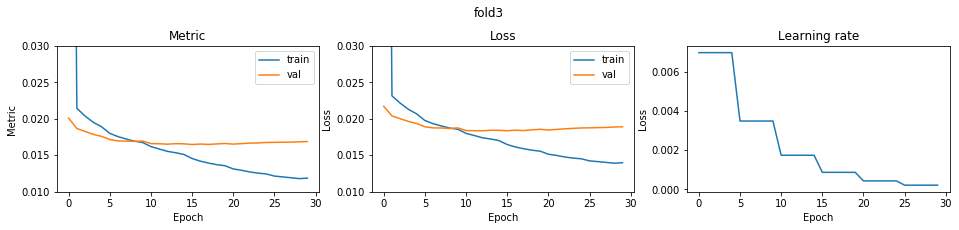

fold 4


epoch1 save best model... 0.019733937380831172
epoch2 save best model... 0.018391288491072036
epoch3 save best model... 0.017859523689505857
epoch4 save best model... 0.017664163444691884
epoch5 save best model... 0.017494691365264815
epoch6 save best model... 0.017005750389264766
epoch7 save best model... 0.016925277664901046
epoch8 save best model... 0.016865380275103526
epoch10 save best model... 0.016729595058582774
epoch11 save best model... 0.016515122534355026
epoch13 save best model... 0.016501994315611203
epoch15 save best model... 0.01643558362995302
epoch16 save best model... 0.016386341372746676
fold4 score: 0.016386341319922025


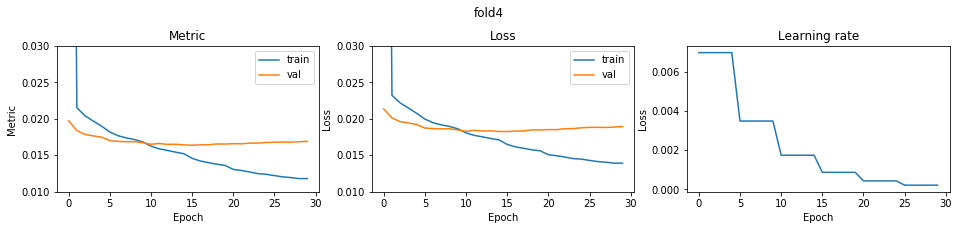

CV score: 0.016372116980252635

optimizer: AdamW
fold 0


epoch1 save best model... 0.01995389378355956
epoch2 save best model... 0.018522652362500888
epoch3 save best model... 0.017894819600333657
epoch4 save best model... 0.017488126445705906
epoch5 save best model... 0.017386221691355074
epoch6 save best model... 0.016927267711159853
epoch7 save best model... 0.016891583505008106
epoch8 save best model... 0.01669626815206369
epoch9 save best model... 0.016652144253219994
epoch10 save best model... 0.01655570535256542
epoch11 save best model... 0.016369013624066373
epoch12 save best model... 0.01632486362909741
epoch13 save best model... 0.016279007610281535
epoch16 save best model... 0.016191048113998355
fold0 score: 0.016191047999451688


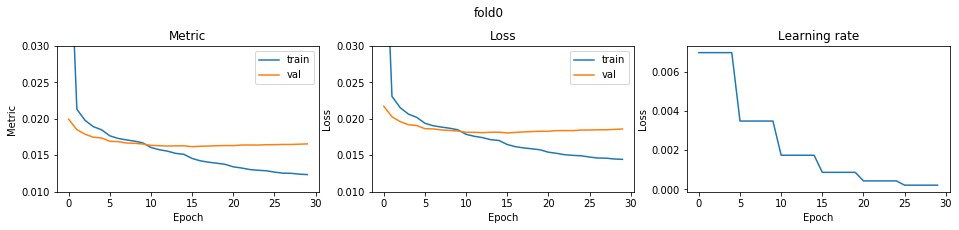

fold 1


epoch1 save best model... 0.019863268304900553
epoch2 save best model... 0.01878354764709198
epoch3 save best model... 0.018224650227071537
epoch4 save best model... 0.0176576342345418
epoch5 save best model... 0.017501244922825294
epoch6 save best model... 0.017078494573744916
epoch7 save best model... 0.01704316889779338
epoch8 save best model... 0.016936001516191092
epoch9 save best model... 0.01686887814830772
epoch10 save best model... 0.016792680782567914
epoch11 save best model... 0.016643148276332734
epoch12 save best model... 0.016569117182179502
epoch13 save best model... 0.016543107521910145
fold1 score: 0.016543107420796007


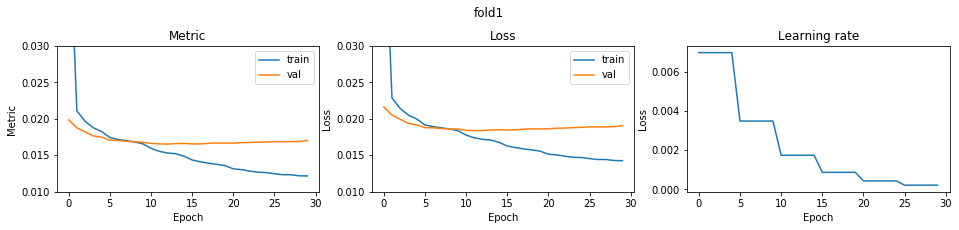

fold 2


epoch1 save best model... 0.020031227513988187
epoch2 save best model... 0.018517921740046177
epoch3 save best model... 0.018027869331372248
epoch4 save best model... 0.017468702319248117
epoch5 save best model... 0.017346862200660323
epoch6 save best model... 0.016935913876593656
epoch7 save best model... 0.0168417542865154
epoch8 save best model... 0.016724285618061493
epoch9 save best model... 0.016684916010052203
epoch10 save best model... 0.016655671414294283
epoch11 save best model... 0.01641031172984647
epoch12 save best model... 0.01631883285641772
epoch13 save best model... 0.016311507350172085
epoch16 save best model... 0.01624758313814215
fold2 score: 0.016247582948696777


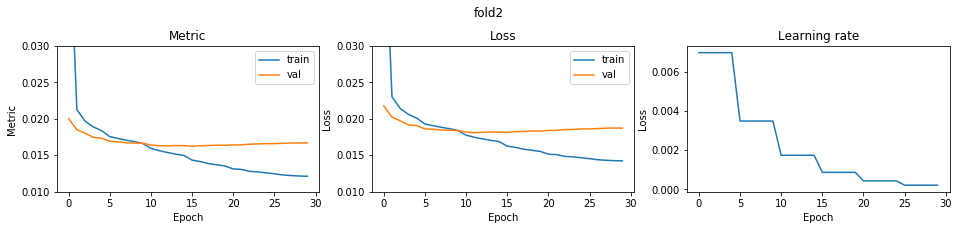

fold 3


epoch1 save best model... 0.0199067949268602
epoch2 save best model... 0.01873005282405365
epoch3 save best model... 0.018099421708672764
epoch4 save best model... 0.017840202586780513
epoch5 save best model... 0.0174884047541674
epoch6 save best model... 0.01713328206432232
epoch7 save best model... 0.017040446944161403
epoch8 save best model... 0.016990424464361272
epoch9 save best model... 0.01685512640337398
epoch10 save best model... 0.016742748980981072
epoch11 save best model... 0.016613486651882767
epoch12 save best model... 0.016483249043057206
epoch16 save best model... 0.016472550808687553
fold3 score: 0.01647255078640619


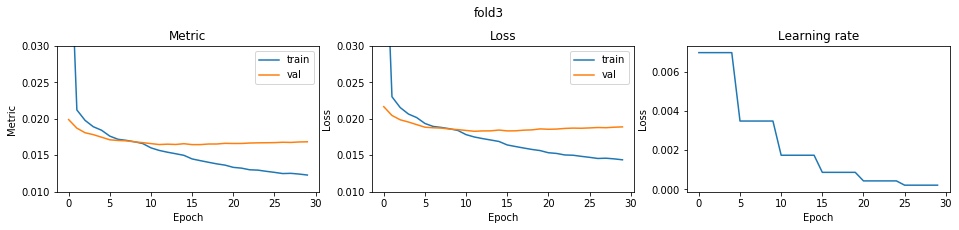

fold 4


epoch1 save best model... 0.020504870205472706
epoch2 save best model... 0.01838134840249608
epoch3 save best model... 0.01784151595272548
epoch4 save best model... 0.01754185898793789
epoch5 save best model... 0.017290250075756144
epoch6 save best model... 0.016937832598381407
epoch7 save best model... 0.01686376481569438
epoch8 save best model... 0.016794038115913613
epoch9 save best model... 0.01678348979435369
epoch10 save best model... 0.016702558886013706
epoch11 save best model... 0.01659344262814739
epoch12 save best model... 0.016490994507535987
epoch13 save best model... 0.016457261937269454
epoch14 save best model... 0.016452103552826444
fold4 score: 0.01645133734949539


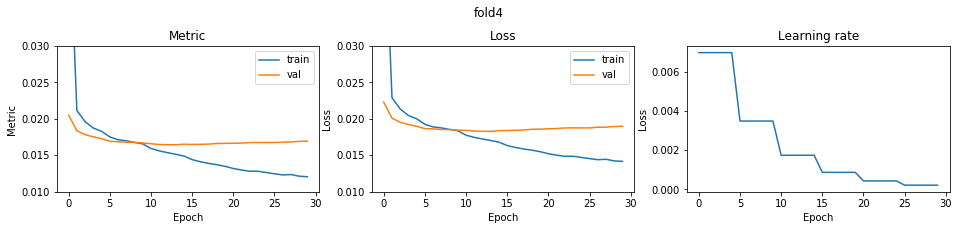

CV score: 0.016381124005189752

optimizer: AdamP
fold 0


epoch1 save best model... 0.02078800522690482
epoch2 save best model... 0.01876420739418689
epoch3 save best model... 0.017810766452367593
epoch4 save best model... 0.017490070104463226
epoch5 save best model... 0.01728283496645697
epoch6 save best model... 0.016917186579189704
epoch7 save best model... 0.016822539155365124
epoch8 save best model... 0.016656175253229696
epoch9 save best model... 0.016614272786571658
epoch11 save best model... 0.016298031566796108
epoch13 save best model... 0.016229611981855303
epoch16 save best model... 0.016203980361257843
epoch17 save best model... 0.016194119421947654
fold0 score: 0.016194119357934734


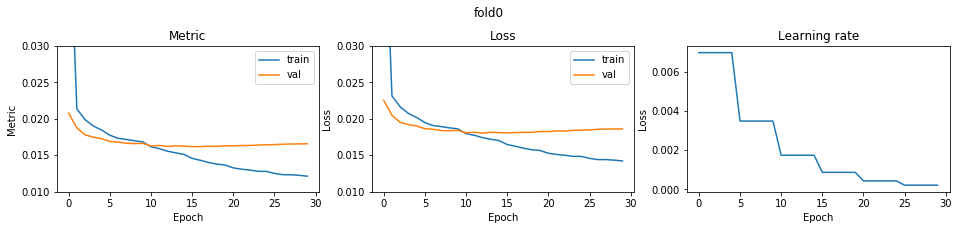

fold 1


epoch1 save best model... 0.019764554045379745
epoch2 save best model... 0.018609238732041733
epoch3 save best model... 0.01797607597358326
epoch4 save best model... 0.017667896254338268
epoch5 save best model... 0.017568768930869075
epoch6 save best model... 0.017157785595736517
epoch7 save best model... 0.016894665053362564
epoch10 save best model... 0.016869039312310603
epoch11 save best model... 0.01668636520548307
epoch12 save best model... 0.01657848215627355
epoch13 save best model... 0.016566679073469218
epoch16 save best model... 0.01653733906181439
fold1 score: 0.016537338973198132


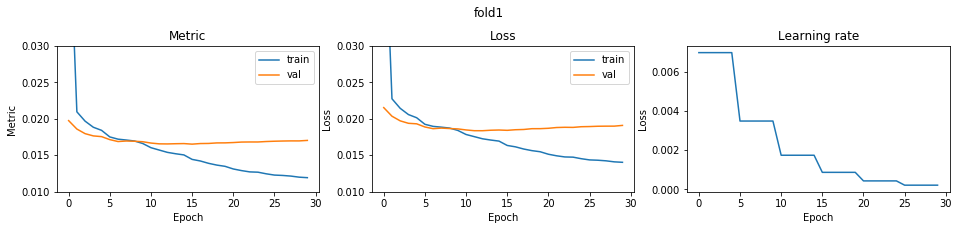

fold 2


epoch1 save best model... 0.02055298665054202
epoch2 save best model... 0.018698090722194076
epoch3 save best model... 0.018015227057540516
epoch4 save best model... 0.017639637745850638
epoch5 save best model... 0.017317262360404716
epoch6 save best model... 0.01692533242270286
epoch7 save best model... 0.01679800114027628
epoch8 save best model... 0.016698487403877478
epoch10 save best model... 0.01667054126509795
epoch11 save best model... 0.016363017055199422
epoch12 save best model... 0.016356638598339204
epoch14 save best model... 0.016319726344463655
epoch16 save best model... 0.01623383810708465
fold2 score: 0.01623383796351756


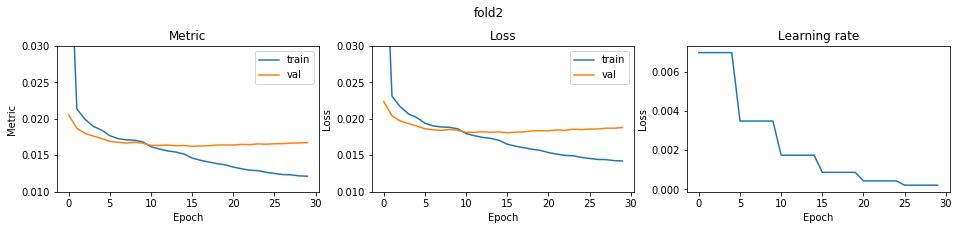

fold 3


epoch1 save best model... 0.020021967316186374
epoch2 save best model... 0.01858424391079872
epoch3 save best model... 0.018186033817945823
epoch4 save best model... 0.017822269186937592
epoch5 save best model... 0.017530431805479772
epoch6 save best model... 0.017132015960770478
epoch7 save best model... 0.017014797919075553
epoch8 save best model... 0.0169742762630886
epoch9 save best model... 0.01690371104543668
epoch10 save best model... 0.016900268766884788
epoch11 save best model... 0.01659451477645402
epoch12 save best model... 0.016566589328721334
epoch14 save best model... 0.016535151964117156
epoch16 save best model... 0.01652494192776824
fold3 score: 0.016524941963614443


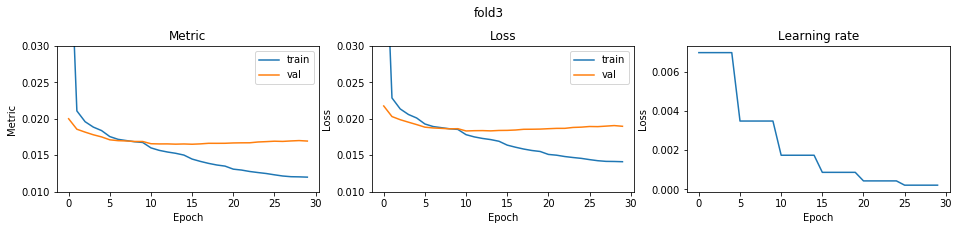

fold 4


epoch1 save best model... 0.019717208022816034
epoch2 save best model... 0.018376326467205426
epoch3 save best model... 0.017970280733663836
epoch4 save best model... 0.01762437909578476
epoch5 save best model... 0.017472522340477328
epoch6 save best model... 0.017007194277841028
epoch7 save best model... 0.016921389571779275
epoch8 save best model... 0.016790566430480172
epoch9 save best model... 0.016759900732182288
epoch10 save best model... 0.016730519171999365
epoch11 save best model... 0.016465407618001138
epoch13 save best model... 0.016397021886105555
epoch14 save best model... 0.01638913441381517
epoch16 save best model... 0.01636459860560359
fold4 score: 0.016364598341698542


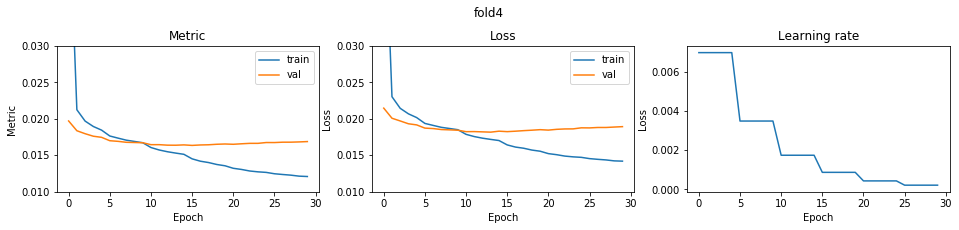

CV score: 0.0163709659876482

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.020084545521197122
epoch2 save best model... 0.01878751601964439
epoch3 save best model... 0.01797283213067978
epoch4 save best model... 0.017679643914409
epoch5 save best model... 0.017394422512323274
epoch6 save best model... 0.01694950540475802
epoch7 save best model... 0.016773457708927655
epoch8 save best model... 0.01673199816910308
epoch9 save best model... 0.016657715732897874
epoch10 save best model... 0.01660952281571738
epoch11 save best model... 0.016359429589232987
epoch12 save best model... 0.016311348821959355
epoch13 save best model... 0.016263825559653427
epoch16 save best model... 0.01620065685242822
fold0 score: 0.016200656701633644


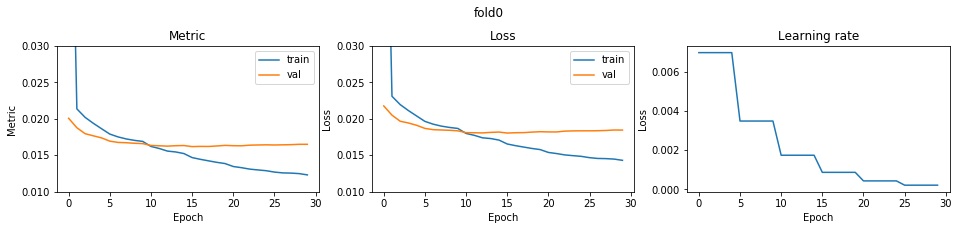

fold 1


epoch1 save best model... 0.020384076222230752
epoch2 save best model... 0.01876320878769901
epoch3 save best model... 0.018061901291623952
epoch4 save best model... 0.0177482583365467
epoch5 save best model... 0.017422360811347733
epoch6 save best model... 0.01711339425608791
epoch7 save best model... 0.0170218005324855
epoch8 save best model... 0.017009034375139183
epoch9 save best model... 0.016806868879147015
epoch11 save best model... 0.01661651766941539
epoch12 save best model... 0.01657888369953464
epoch13 save best model... 0.016540262757319475
epoch16 save best model... 0.01650884818314562
epoch17 save best model... 0.016456674561617476
fold1 score: 0.01645667449423227


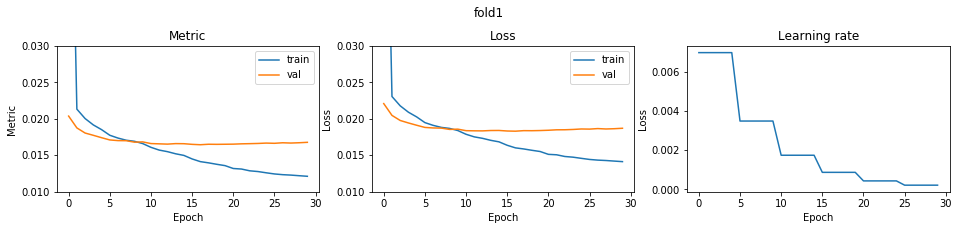

fold 2


epoch1 save best model... 0.02030810342299949
epoch2 save best model... 0.01884306163995385
epoch3 save best model... 0.018120265434676257
epoch4 save best model... 0.017616054211232
epoch5 save best model... 0.01744891375988233
epoch6 save best model... 0.017027421806480394
epoch7 save best model... 0.016902937842407796
epoch8 save best model... 0.01677267522716419
epoch9 save best model... 0.01675108398781276
epoch10 save best model... 0.01664713135476766
epoch11 save best model... 0.01644392521072864
epoch12 save best model... 0.016442500577259645
epoch13 save best model... 0.016359701386626787
epoch16 save best model... 0.01631312420149074
epoch17 save best model... 0.016292301834811108
fold2 score: 0.016292301833686008


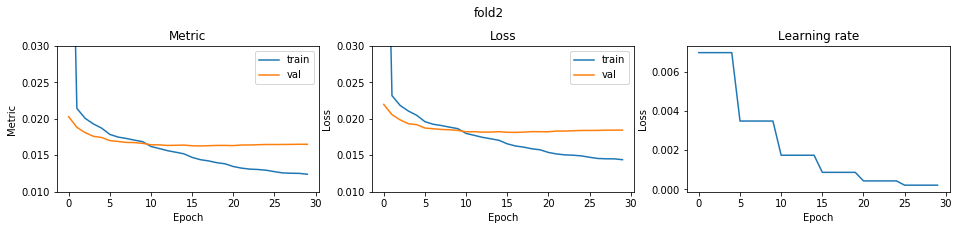

fold 3


epoch1 save best model... 0.020294850838533975
epoch2 save best model... 0.019104080129168706
epoch3 save best model... 0.01837423375228543
epoch4 save best model... 0.017882864337185386
epoch5 save best model... 0.017566520484389232
epoch6 save best model... 0.017236474404166664
epoch7 save best model... 0.01716571384765089
epoch8 save best model... 0.01694316401067858
epoch9 save best model... 0.016905173516762285
epoch10 save best model... 0.016903450644250476
epoch11 save best model... 0.016619961362985516
epoch12 save best model... 0.01653729781024752
epoch13 save best model... 0.01653118610152962
epoch16 save best model... 0.016421567931228183
fold3 score: 0.01642156789593868


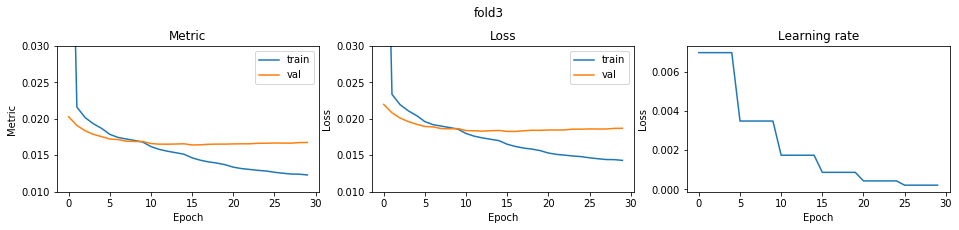

fold 4


epoch1 save best model... 0.019996864281611727
epoch2 save best model... 0.018711131000742825
epoch3 save best model... 0.01797531540834415
epoch4 save best model... 0.01765192507814981
epoch5 save best model... 0.017409469505903524
epoch6 save best model... 0.016989125190875524
epoch7 save best model... 0.016900079954916224
epoch8 save best model... 0.01685577913575672
epoch9 save best model... 0.01681737118445184
epoch10 save best model... 0.016752430306140816
epoch11 save best model... 0.01649675038526501
epoch12 save best model... 0.016493634589372842
epoch13 save best model... 0.016428038963712838
epoch14 save best model... 0.016407605280976633
fold4 score: 0.016407605368756906


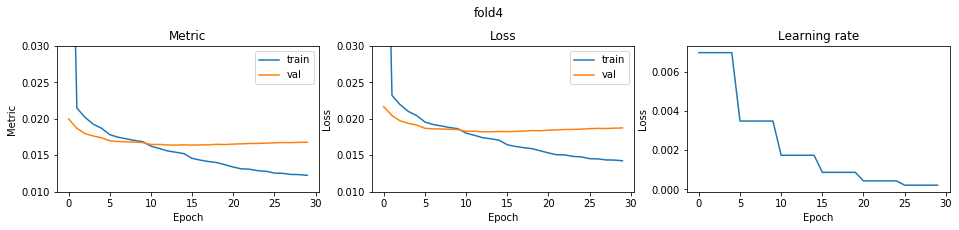

CV score: 0.016355759552370085

optimizer: Lamb
fold 0


epoch1 save best model... 0.020170473498302876
epoch2 save best model... 0.01836798859077054
epoch3 save best model... 0.017826112535419388
epoch4 save best model... 0.01758760793266101
epoch5 save best model... 0.017242625239464307
epoch6 save best model... 0.016858552578743333
epoch7 save best model... 0.0168055303012931
epoch8 save best model... 0.01664788507705805
epoch9 save best model... 0.016581774333275533
epoch10 save best model... 0.016506098079280863
epoch11 save best model... 0.016372563681461273
epoch12 save best model... 0.016341072097760128
epoch13 save best model... 0.01633695812900137
epoch14 save best model... 0.016298128007688394
epoch15 save best model... 0.016261949431753648
epoch16 save best model... 0.016251705487625747
epoch17 save best model... 0.016247425168107746
epoch19 save best model... 0.016232406045045018
epoch25 save best model... 0.016217380441334906
epoch29 save best model... 0.016215292223493712
fold0 score: 0.01621529210086987


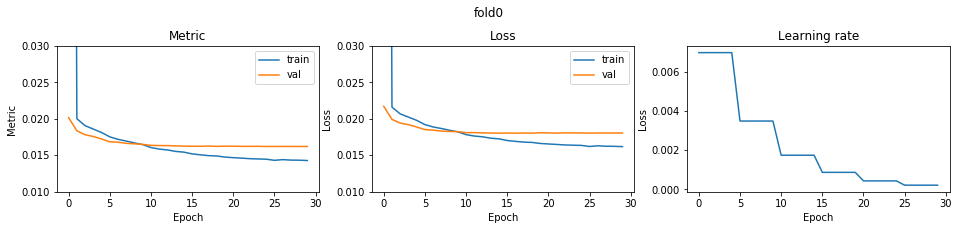

fold 1


epoch1 save best model... 0.02003333178610051
epoch2 save best model... 0.01838154188429652
epoch3 save best model... 0.018126274544154084
epoch4 save best model... 0.017710245626696992
epoch5 save best model... 0.017518754879606423
epoch6 save best model... 0.01717169141096837
epoch7 save best model... 0.017019032390555206
epoch8 save best model... 0.016963428817901614
epoch9 save best model... 0.01684698957515302
epoch10 save best model... 0.016772426957233563
epoch11 save best model... 0.0167030943118377
epoch12 save best model... 0.016613054108345703
epoch14 save best model... 0.016604146810652087
epoch15 save best model... 0.016593115210302274
epoch16 save best model... 0.016560417353618007
epoch18 save best model... 0.016545703349005635
epoch21 save best model... 0.016535294092605967
fold1 score: 0.016535293982913472


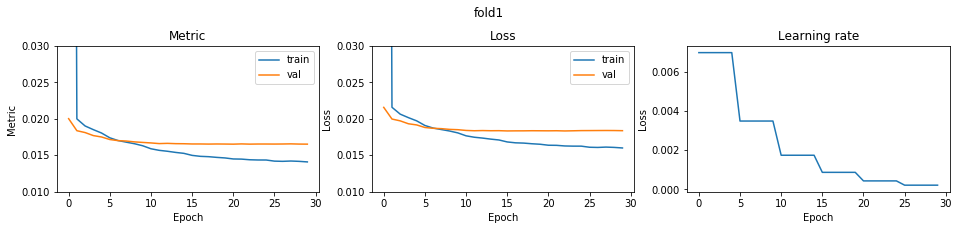

fold 2


epoch1 save best model... 0.020073322249938453
epoch2 save best model... 0.018440485761116187
epoch3 save best model... 0.017871671740121005
epoch4 save best model... 0.017588041610947895
epoch5 save best model... 0.017396867176567497
epoch6 save best model... 0.016982003973020757
epoch7 save best model... 0.016818582473925807
epoch8 save best model... 0.016727253886126024
epoch9 save best model... 0.01658220633445955
epoch10 save best model... 0.016535180826041416
epoch11 save best model... 0.016433007028450398
epoch12 save best model... 0.016395533396074143
epoch13 save best model... 0.016378936072182115
epoch14 save best model... 0.016359475689120447
epoch15 save best model... 0.016343644350991213
epoch16 save best model... 0.016314873207673705
epoch17 save best model... 0.01630551433163118
epoch18 save best model... 0.016284322936497807
epoch19 save best model... 0.01628033803934204
epoch21 save best model... 0.016274332607198506
epoch22 save best model... 0.016260472947923012
epoc

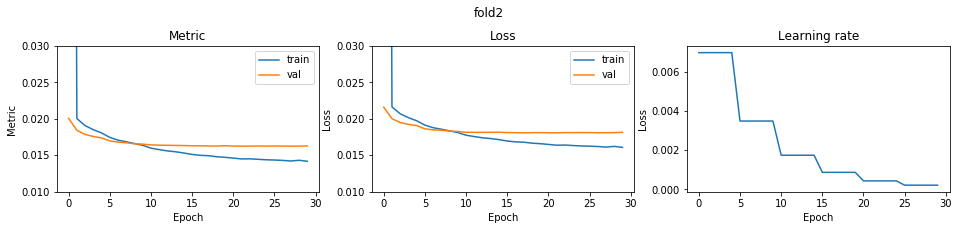

fold 3


epoch1 save best model... 0.02048412424751933
epoch2 save best model... 0.018571609740224
epoch3 save best model... 0.017964472695081952
epoch4 save best model... 0.01767987348860584
epoch5 save best model... 0.017446263890993487
epoch6 save best model... 0.017150613485256334
epoch7 save best model... 0.017030934524851805
epoch8 save best model... 0.016945843981124954
epoch9 save best model... 0.016848305271246845
epoch10 save best model... 0.016749965371076096
epoch11 save best model... 0.016670578611263653
epoch12 save best model... 0.016601147511995193
epoch13 save best model... 0.016568494040374738
epoch15 save best model... 0.016536434013014637
epoch16 save best model... 0.01651454806658768
epoch17 save best model... 0.01649376008965092
epoch19 save best model... 0.016457026493406784
epoch20 save best model... 0.016439456482479405
epoch23 save best model... 0.016430593877691343
epoch24 save best model... 0.01642645778249024
epoch26 save best model... 0.016423142366196138
epoch27 s

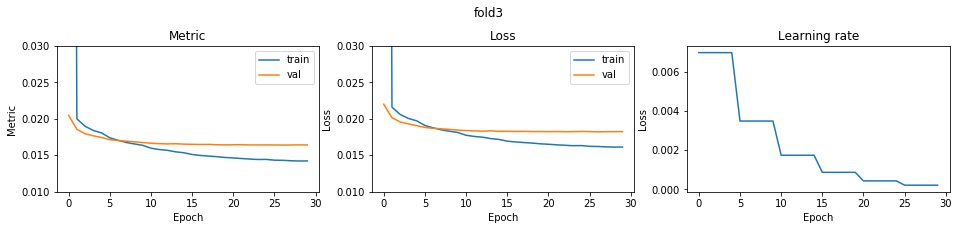

fold 4


epoch1 save best model... 0.01986548883632538
epoch2 save best model... 0.018252723320792502
epoch3 save best model... 0.017846915064748708
epoch4 save best model... 0.017526106066272036
epoch5 save best model... 0.017321896419387337
epoch6 save best model... 0.017064856004674233
epoch7 save best model... 0.016939506062427386
epoch8 save best model... 0.01684830815346746
epoch9 save best model... 0.016748777753196165
epoch10 save best model... 0.016698607076426165
epoch11 save best model... 0.01662365659256731
epoch13 save best model... 0.016594061819340075
epoch14 save best model... 0.016554399150379154
epoch15 save best model... 0.016550286725621696
epoch16 save best model... 0.016544097969159993
epoch17 save best model... 0.0165117551243794
epoch20 save best model... 0.01651093714694431
epoch22 save best model... 0.0164997786635656
epoch25 save best model... 0.016499288400936372
fold4 score: 0.01649928840302349


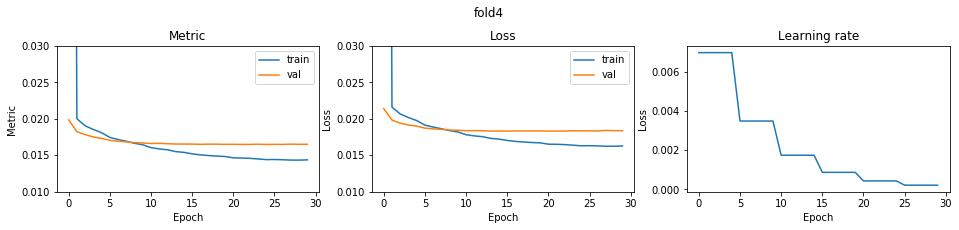

CV score: 0.01638452442512883

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.018501669087008083
epoch2 save best model... 0.01772869570278361
epoch3 save best model... 0.017281105698580622
epoch4 save best model... 0.017070259940481676
epoch5 save best model... 0.016920622396611677
epoch6 save best model... 0.0165319993133086
epoch7 save best model... 0.016482521109028394
epoch8 save best model... 0.016402043498085137
epoch9 save best model... 0.016315371835931014
epoch10 save best model... 0.016282922811042475
epoch11 save best model... 0.016202407758810253
epoch12 save best model... 0.016165782019903284
epoch13 save best model... 0.016138585479526964
epoch14 save best model... 0.016106223707471324
epoch15 save best model... 0.016098959722761957
epoch16 save best model... 0.01608687088589326
epoch17 save best model... 0.016086517888755626
epoch18 save best model... 0.016079028254557308
fold0 score: 0.016079028188589466


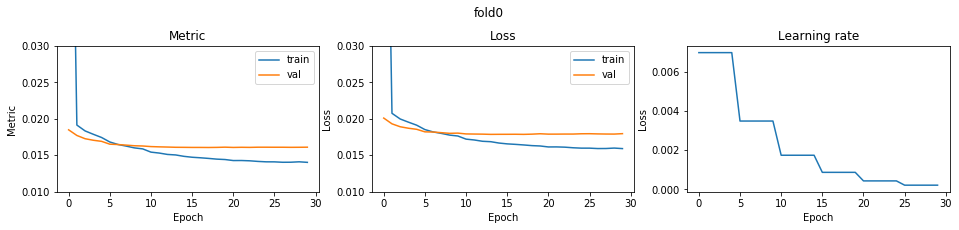

fold 1


epoch1 save best model... 0.018617009714765247
epoch2 save best model... 0.017873448426254886
epoch3 save best model... 0.01745659738989565
epoch4 save best model... 0.017177096028012467
epoch5 save best model... 0.016974462403332925
epoch6 save best model... 0.016807904052358196
epoch7 save best model... 0.01671001582842946
epoch8 save best model... 0.016606105283143772
epoch9 save best model... 0.01657893180704573
epoch10 save best model... 0.016516213001643885
epoch11 save best model... 0.016456975160036334
epoch13 save best model... 0.016420272477718077
epoch23 save best model... 0.016409927766492572
fold1 score: 0.01640992763448531


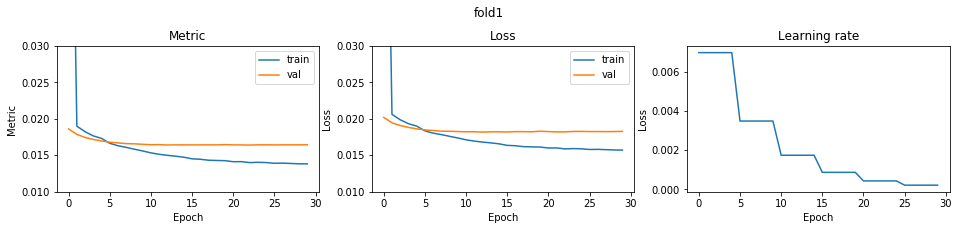

fold 2


epoch1 save best model... 0.01847165915499681
epoch2 save best model... 0.017696845147221446
epoch3 save best model... 0.01737684261573253
epoch4 save best model... 0.017056216556671392
epoch5 save best model... 0.017007242353905928
epoch6 save best model... 0.016625142161640825
epoch7 save best model... 0.016531751671707094
epoch8 save best model... 0.01646402093933462
epoch9 save best model... 0.01639827306168678
epoch10 save best model... 0.01631417936429222
epoch11 save best model... 0.01625463036736688
epoch12 save best model... 0.016224223924310582
epoch13 save best model... 0.01619239419055341
epoch18 save best model... 0.016182371163534926
fold2 score: 0.016182371061465826


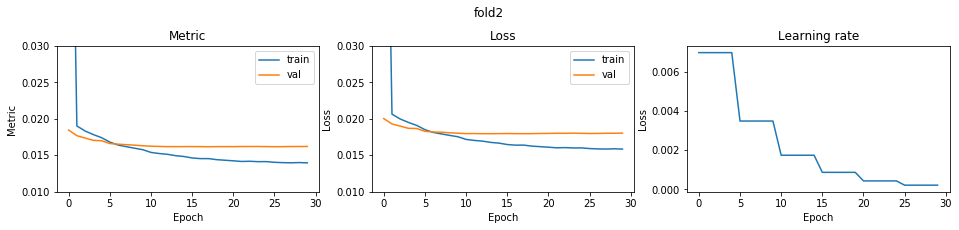

fold 3


epoch1 save best model... 0.01880167521078114
epoch2 save best model... 0.01780090039269256
epoch3 save best model... 0.017535035546385344
epoch4 save best model... 0.01727309795542024
epoch5 save best model... 0.017069116084579727
epoch6 save best model... 0.01680890522294748
epoch7 save best model... 0.01671368051744607
epoch8 save best model... 0.016608868512178607
epoch9 save best model... 0.0165540967807004
epoch10 save best model... 0.016458314722128095
epoch11 save best model... 0.016381877108746484
epoch13 save best model... 0.016343975933120165
epoch14 save best model... 0.01633047555575406
epoch15 save best model... 0.016321201878334638
epoch16 save best model... 0.01628933100916598
epoch18 save best model... 0.016283522352389567
epoch24 save best model... 0.01627648882780029
epoch27 save best model... 0.016273408921134228
fold3 score: 0.016273408751705395


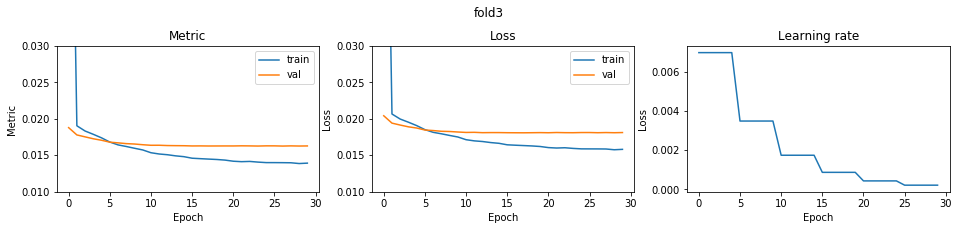

fold 4


epoch1 save best model... 0.018485726282883072
epoch2 save best model... 0.01766435648049472
epoch3 save best model... 0.017374586068297438
epoch4 save best model... 0.017225651209219307
epoch5 save best model... 0.017055528069547205
epoch6 save best model... 0.016723541822496607
epoch7 save best model... 0.016630611339571263
epoch8 save best model... 0.016544660044609142
epoch9 save best model... 0.016535441635138353
epoch10 save best model... 0.016490526163445655
epoch11 save best model... 0.016401283367874275
epoch12 save best model... 0.016374205566671143
epoch14 save best model... 0.016357022609162847
fold4 score: 0.016357022558930668


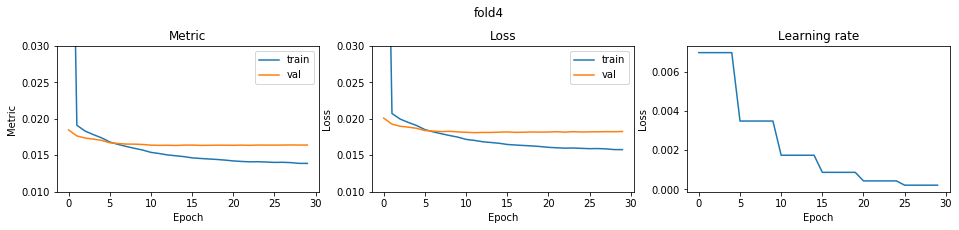

CV score: 0.016260348376987862

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.0201660403213835
epoch2 save best model... 0.018846071517447133
epoch3 save best model... 0.018312777205453105
epoch4 save best model... 0.017624458345607906
epoch5 save best model... 0.01746282910414736
epoch6 save best model... 0.016985383790181545
epoch7 save best model... 0.01686579557666067
epoch8 save best model... 0.016851578421194894
epoch9 save best model... 0.016758429248030202
epoch10 save best model... 0.0165860171453149
epoch11 save best model... 0.01636755402986987
epoch12 save best model... 0.016309978179888194
epoch13 save best model... 0.016302742706378392
epoch14 save best model... 0.016278506818827844
epoch15 save best model... 0.01627419338495829
epoch16 save best model... 0.016162288358227132
fold0 score: 0.016162288255384828


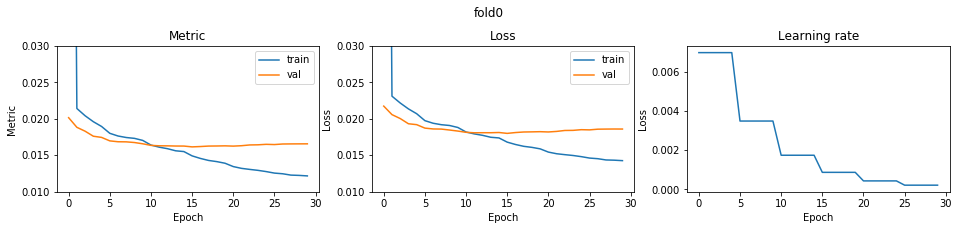

fold 1


epoch1 save best model... 0.020665349191367477
epoch2 save best model... 0.019065509596744058
epoch3 save best model... 0.01833762622110106
epoch4 save best model... 0.01808689224265735
epoch5 save best model... 0.017694630716560467
epoch6 save best model... 0.017270055505720607
epoch7 save best model... 0.01716550110460964
epoch8 save best model... 0.01705161160238785
epoch9 save best model... 0.0170060138475497
epoch10 save best model... 0.016819825878260305
epoch11 save best model... 0.01668845299091534
epoch12 save best model... 0.016612556587720508
epoch13 save best model... 0.01657130881358005
epoch14 save best model... 0.016514442978211648
epoch16 save best model... 0.016495236364106474
fold1 score: 0.016495236189176525


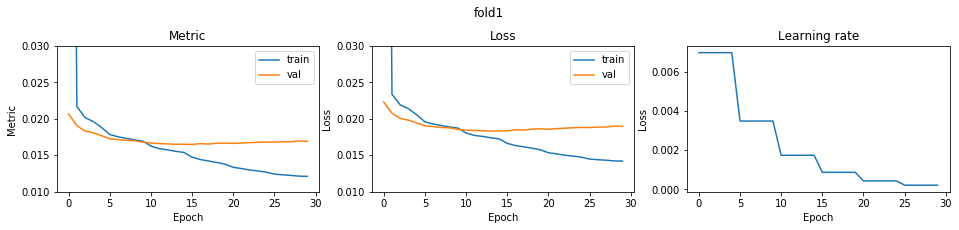

fold 2


epoch1 save best model... 0.02059398761019535
epoch2 save best model... 0.018976091382837047
epoch3 save best model... 0.018368352891647698
epoch4 save best model... 0.01795849384662332
epoch5 save best model... 0.017597764348927406
epoch6 save best model... 0.017052535215079934
epoch7 save best model... 0.017036124170768652
epoch8 save best model... 0.01685021174267379
epoch10 save best model... 0.016715044561220985
epoch11 save best model... 0.01645755188127542
epoch12 save best model... 0.01639185973656771
epoch13 save best model... 0.016349865836391596
epoch16 save best model... 0.016256099287993438
fold2 score: 0.01625609922016261


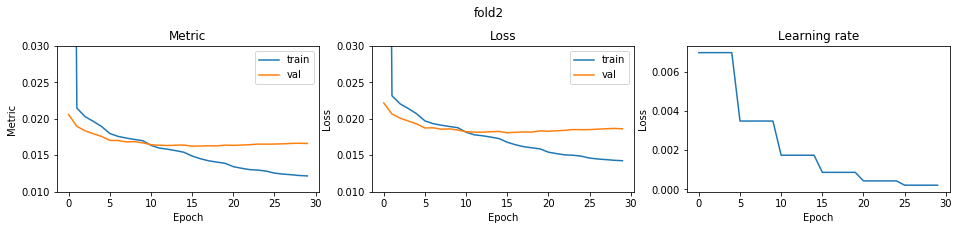

fold 3


epoch1 save best model... 0.020584172861553
epoch2 save best model... 0.019028153864068566
epoch3 save best model... 0.01839384995613052
epoch4 save best model... 0.017952791767742206
epoch5 save best model... 0.01782783476046047
epoch6 save best model... 0.017306447399097043
epoch7 save best model... 0.01723332864811521
epoch8 save best model... 0.0171763291709753
epoch9 save best model... 0.017056535966779213
epoch10 save best model... 0.01697426504139409
epoch11 save best model... 0.016673818705412548
epoch12 save best model... 0.01661125933348386
epoch14 save best model... 0.01653928446768017
epoch15 save best model... 0.016538149117999168
epoch16 save best model... 0.0164108932429844
fold3 score: 0.016410893226303687


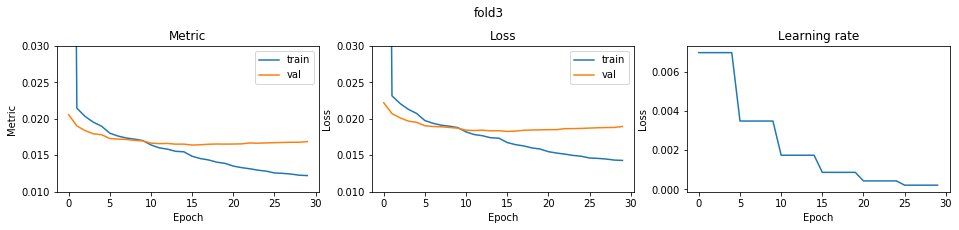

fold 4


epoch1 save best model... 0.019968820282667537
epoch2 save best model... 0.018857354274473593
epoch3 save best model... 0.018069333277201463
epoch4 save best model... 0.0178509872589167
epoch5 save best model... 0.01761644707530194
epoch6 save best model... 0.017109858639674062
epoch7 save best model... 0.016952404184670002
epoch8 save best model... 0.016926429527631383
epoch9 save best model... 0.01687535523630017
epoch10 save best model... 0.016808021802175152
epoch11 save best model... 0.01661441930164509
epoch12 save best model... 0.01657823346563719
epoch13 save best model... 0.0165570752567915
epoch14 save best model... 0.016546417285681857
epoch16 save best model... 0.016462932610226653
fold4 score: 0.016462932489959274


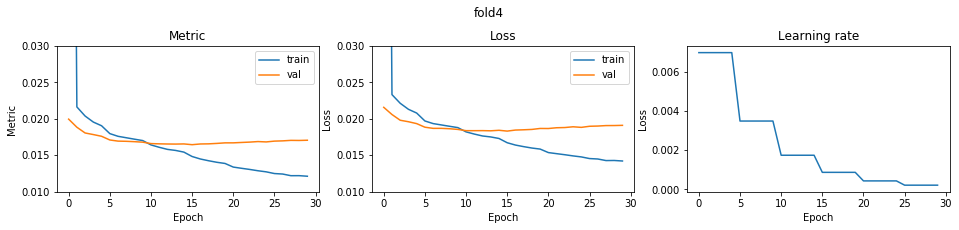

CV score: 0.01635748821975229

optimizer: QHAdam
fold 0


epoch1 save best model... 0.0201504300125707
epoch2 save best model... 0.018420173211663893
epoch3 save best model... 0.017870464353293928
epoch4 save best model... 0.017614581355303187
epoch5 save best model... 0.017350730388202538
epoch6 save best model... 0.016978040172088392
epoch7 save best model... 0.01683059339252447
epoch9 save best model... 0.016775102551033667
epoch11 save best model... 0.016484098959977236
epoch12 save best model... 0.01643048257382421
epoch13 save best model... 0.01636591978744521
epoch14 save best model... 0.016327522213067987
epoch16 save best model... 0.016229350118132008
epoch17 save best model... 0.016203000842421773
fold0 score: 0.01620300088666922


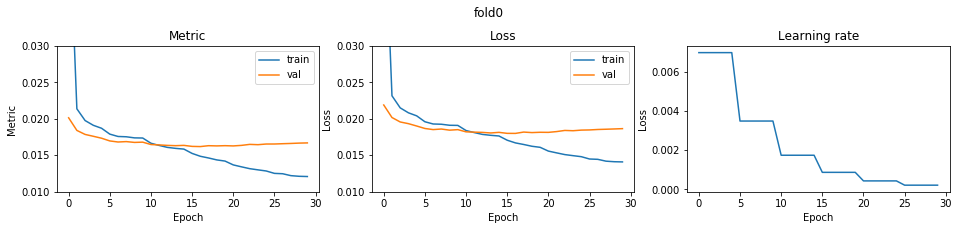

fold 1


epoch1 save best model... 0.0201515352235049
epoch2 save best model... 0.01860007434093713
epoch3 save best model... 0.018334170536486755
epoch4 save best model... 0.017803295902733
epoch5 save best model... 0.017627525403688237
epoch6 save best model... 0.017126548827572127
epoch7 save best model... 0.017109842420322024
epoch9 save best model... 0.017094530288692785
epoch11 save best model... 0.016726632908073216
epoch12 save best model... 0.01671911571892078
epoch16 save best model... 0.016618720853969024
fold1 score: 0.01661872080689209


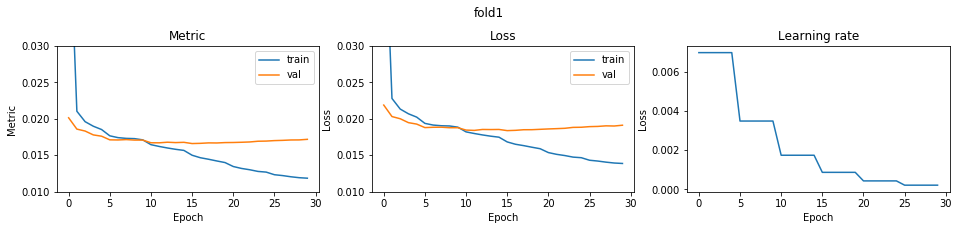

fold 2


epoch1 save best model... 0.020170826498842588
epoch2 save best model... 0.018824111701236088
epoch3 save best model... 0.017950556093076143
epoch4 save best model... 0.017541114651905932
epoch6 save best model... 0.017066838156952216
epoch7 save best model... 0.01691646015665802
epoch9 save best model... 0.016892617719456313
epoch10 save best model... 0.016845480503680347
epoch11 save best model... 0.01653099843905846
epoch12 save best model... 0.01649220582983894
epoch13 save best model... 0.016424251313107614
epoch14 save best model... 0.01641221147851361
epoch16 save best model... 0.016343539922336264
fold2 score: 0.01634353987771419


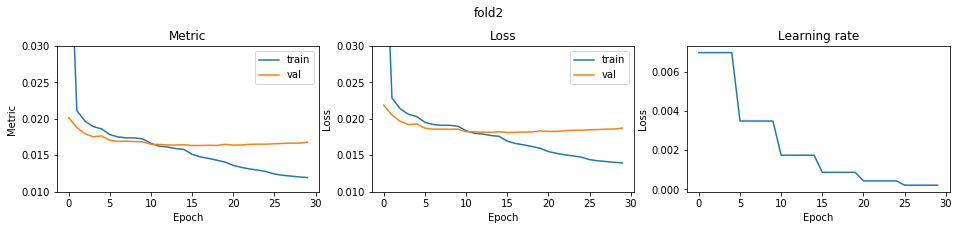

fold 3


epoch1 save best model... 0.02029732412749855
epoch2 save best model... 0.01866816375828889
epoch3 save best model... 0.0181419142948332
epoch4 save best model... 0.017731687778305763
epoch5 save best model... 0.01766407909996146
epoch6 save best model... 0.01723836886745311
epoch7 save best model... 0.01720726899378392
epoch8 save best model... 0.01709557356851723
epoch9 save best model... 0.017063134455955788
epoch10 save best model... 0.017025631462522953
epoch11 save best model... 0.01667484444203301
epoch13 save best model... 0.01667233361291926
epoch14 save best model... 0.016647423399455318
epoch16 save best model... 0.01649059745056686
fold3 score: 0.01649059733442286


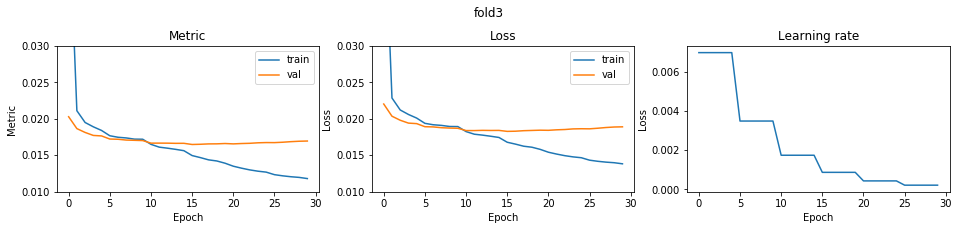

fold 4


epoch1 save best model... 0.019707174635659862
epoch2 save best model... 0.018346688438181453
epoch3 save best model... 0.01786733017025138
epoch4 save best model... 0.01774151154532859
epoch5 save best model... 0.017526389772161536
epoch6 save best model... 0.017076650940747357
epoch10 save best model... 0.01692783443770607
epoch11 save best model... 0.016682732359830775
epoch12 save best model... 0.01663839913319143
epoch14 save best model... 0.01661301896587048
epoch15 save best model... 0.016569696267078163
epoch16 save best model... 0.016460852844296936
fold4 score: 0.0164608529061969


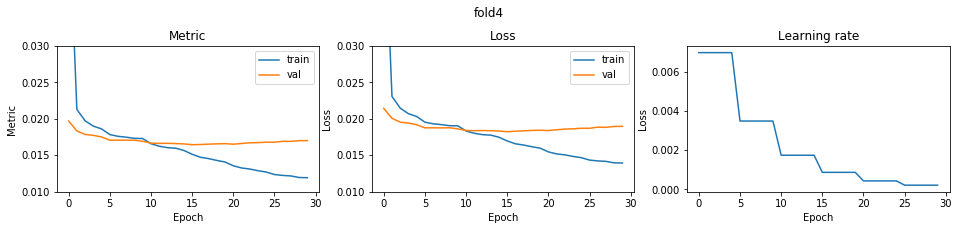

CV score: 0.01642333709647966

optimizer: RAdam
fold 0


epoch1 save best model... 0.02045595294844724
epoch2 save best model... 0.01889260104838292
epoch3 save best model... 0.018173623856386184
epoch4 save best model... 0.01774205552638935
epoch5 save best model... 0.01764797509259678
epoch6 save best model... 0.016950938908345065
epoch7 save best model... 0.016883719666672188
epoch8 save best model... 0.01677597554184174
epoch9 save best model... 0.01666724597419992
epoch11 save best model... 0.016433648109130543
epoch12 save best model... 0.016353334302341475
epoch13 save best model... 0.016310391028608984
epoch15 save best model... 0.01627430959195238
epoch16 save best model... 0.016187592315782446
fold0 score: 0.016187592238313123


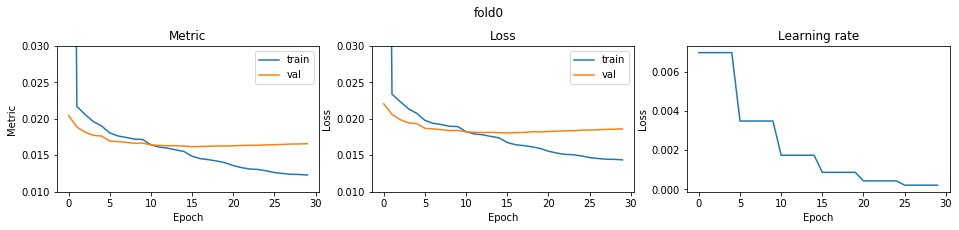

fold 1


epoch1 save best model... 0.020975953959375043
epoch2 save best model... 0.019383817182471442
epoch3 save best model... 0.01842920117650591
epoch4 save best model... 0.01806221057114052
epoch5 save best model... 0.017862358894203376
epoch6 save best model... 0.01719850506637764
epoch7 save best model... 0.01703921301423227
epoch9 save best model... 0.01698234533361868
epoch10 save best model... 0.016879620500109237
epoch11 save best model... 0.016626740312452034
epoch12 save best model... 0.016576008961168256
epoch16 save best model... 0.016451842237521098
fold1 score: 0.01645184216443417


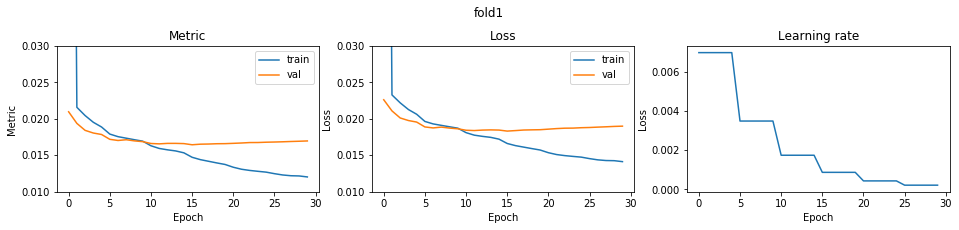

fold 2


epoch1 save best model... 0.021107302544484462
epoch2 save best model... 0.018855312828965083
epoch3 save best model... 0.018148152045625494
epoch4 save best model... 0.017861053172739144
epoch5 save best model... 0.01775336056721933
epoch6 save best model... 0.01700412355427876
epoch7 save best model... 0.016831743423982956
epoch9 save best model... 0.016701666217685207
epoch10 save best model... 0.016649870906431736
epoch11 save best model... 0.01643228315824452
epoch12 save best model... 0.016339696452741363
epoch16 save best model... 0.01622035298526192
fold2 score: 0.016220352751161748


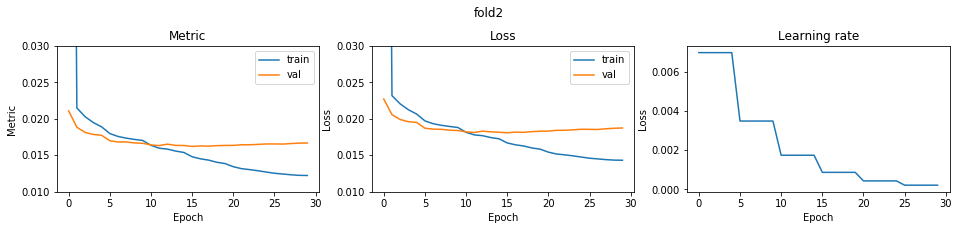

fold 3


epoch1 save best model... 0.020609166628441398
epoch2 save best model... 0.019120348964081674
epoch3 save best model... 0.01856055177943378
epoch4 save best model... 0.018055997466019318
epoch5 save best model... 0.017760029730041232
epoch6 save best model... 0.017345701418138175
epoch7 save best model... 0.01721363489925522
epoch8 save best model... 0.017137995236691145
epoch9 save best model... 0.017002068202441944
epoch10 save best model... 0.016870582201740873
epoch11 save best model... 0.016611294756836526
epoch12 save best model... 0.016583280927652242
epoch13 save best model... 0.016563664378008564
epoch16 save best model... 0.016476028318811793
epoch17 save best model... 0.016451132346733826
fold3 score: 0.016451132353222934


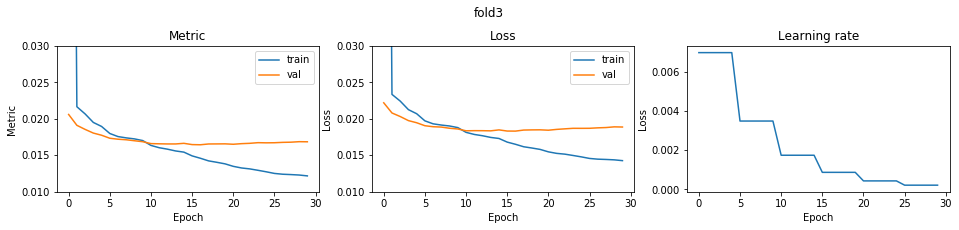

fold 4


epoch1 save best model... 0.019930497577290873
epoch2 save best model... 0.018734040992983654
epoch3 save best model... 0.01798607076354885
epoch4 save best model... 0.017809065761031893
epoch5 save best model... 0.017493535975388896
epoch6 save best model... 0.017020643651400585
epoch8 save best model... 0.01694403781231009
epoch9 save best model... 0.016925889777617872
epoch10 save best model... 0.016773352757995793
epoch11 save best model... 0.016574186868626193
epoch13 save best model... 0.016562249560274
epoch14 save best model... 0.01654371206133132
epoch15 save best model... 0.016444035677625406
epoch16 save best model... 0.016396130245085593
fold4 score: 0.016396130141038974


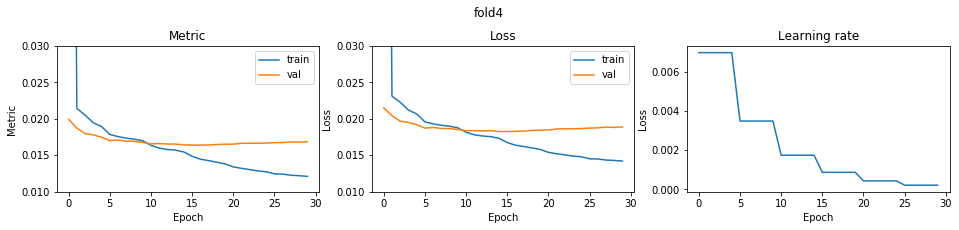

CV score: 0.016341410413730405

optimizer: Ranger
fold 0


epoch1 save best model... 0.02151327611186917
epoch2 save best model... 0.01963745720752415
epoch3 save best model... 0.0185043840904578
epoch4 save best model... 0.017963598551470488
epoch5 save best model... 0.017634143725309123
epoch6 save best model... 0.017104865232978977
epoch7 save best model... 0.016959106040469334
epoch8 save best model... 0.016951917693154687
epoch9 save best model... 0.016692868288360314
epoch10 save best model... 0.016596638267872544
epoch11 save best model... 0.016415850845736223
epoch12 save best model... 0.0163358126018103
epoch13 save best model... 0.016259478350384226
epoch15 save best model... 0.01622352912292258
epoch16 save best model... 0.01613866805580523
fold0 score: 0.016138667958696333


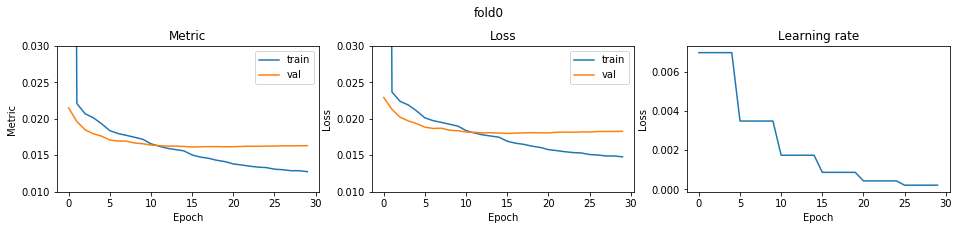

fold 1


epoch1 save best model... 0.021192501914660083
epoch2 save best model... 0.01965827399075004
epoch3 save best model... 0.01870852799296352
epoch4 save best model... 0.018339204101800566
epoch5 save best model... 0.017819915411581778
epoch6 save best model... 0.0173427258425291
epoch7 save best model... 0.017325399413375547
epoch8 save best model... 0.017229435914492084
epoch9 save best model... 0.017082486727323123
epoch10 save best model... 0.016912749840940124
epoch11 save best model... 0.01668896875094888
epoch12 save best model... 0.016569248590118442
epoch13 save best model... 0.016546987665965254
epoch14 save best model... 0.016546145357797592
epoch15 save best model... 0.01648427230978839
epoch16 save best model... 0.016414615410931983
fold1 score: 0.016414615414626632


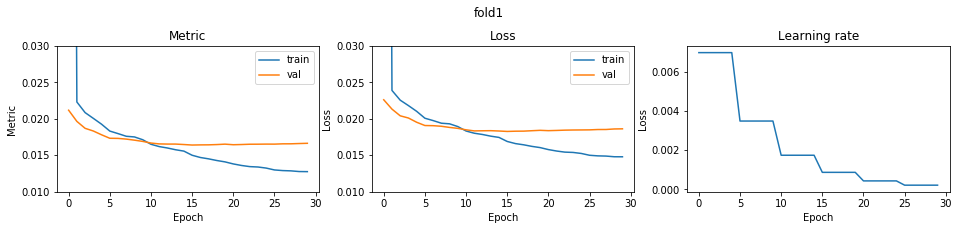

fold 2


epoch1 save best model... 0.0213765499336311
epoch2 save best model... 0.01979082017393448
epoch3 save best model... 0.018578684363173826
epoch4 save best model... 0.018154684967926042
epoch5 save best model... 0.01766811653239176
epoch6 save best model... 0.017163642012024215
epoch7 save best model... 0.017081584568364824
epoch9 save best model... 0.016831665708307634
epoch10 save best model... 0.01673216672410934
epoch11 save best model... 0.016506525758109812
epoch12 save best model... 0.016414974795560627
epoch14 save best model... 0.016358274563308402
epoch16 save best model... 0.01621750564462749
fold2 score: 0.016217505543420094


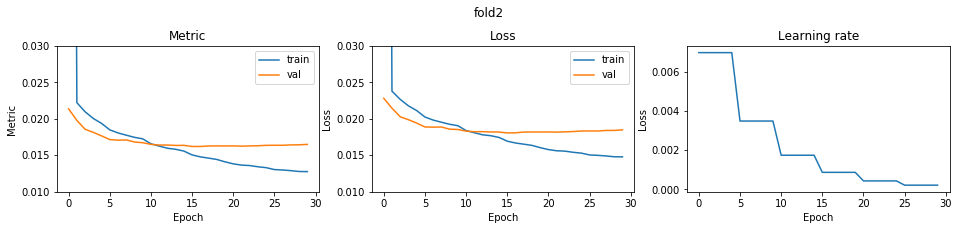

fold 3


epoch1 save best model... 0.021409080036680357
epoch2 save best model... 0.01954600687577879
epoch3 save best model... 0.018632620824225128
epoch4 save best model... 0.018164842332668754
epoch5 save best model... 0.017945326070867667
epoch6 save best model... 0.0174023450880496
epoch7 save best model... 0.01720856743141296
epoch8 save best model... 0.017145653367297117
epoch9 save best model... 0.016987907011613488
epoch10 save best model... 0.016966332618681745
epoch11 save best model... 0.01667365556315504
epoch12 save best model... 0.01660540497868167
epoch14 save best model... 0.016581657171198475
epoch15 save best model... 0.01657343830336267
epoch16 save best model... 0.016483309441553705
epoch18 save best model... 0.016466145661228882
fold3 score: 0.01646614552193122


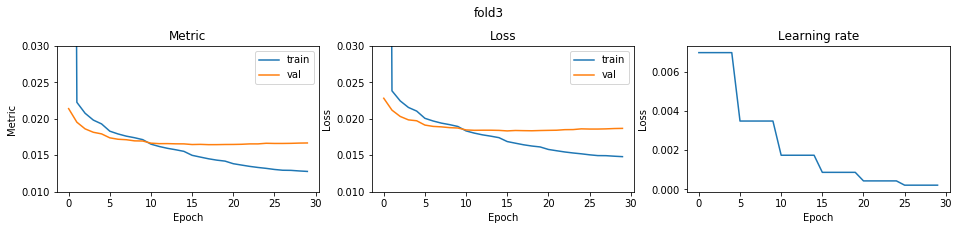

fold 4


epoch1 save best model... 0.020800554082815902
epoch2 save best model... 0.01916444629668375
epoch3 save best model... 0.01828141911358388
epoch4 save best model... 0.017943443833576656
epoch5 save best model... 0.017678758333986605
epoch6 save best model... 0.01718669531523231
epoch7 save best model... 0.017139954321459785
epoch8 save best model... 0.01695374600920224
epoch9 save best model... 0.016875400019550787
epoch10 save best model... 0.016847941710492746
epoch11 save best model... 0.016618135620273464
epoch12 save best model... 0.01650335302444892
epoch16 save best model... 0.016415528722260157
epoch19 save best model... 0.01638820587035803
fold4 score: 0.01638820577473462


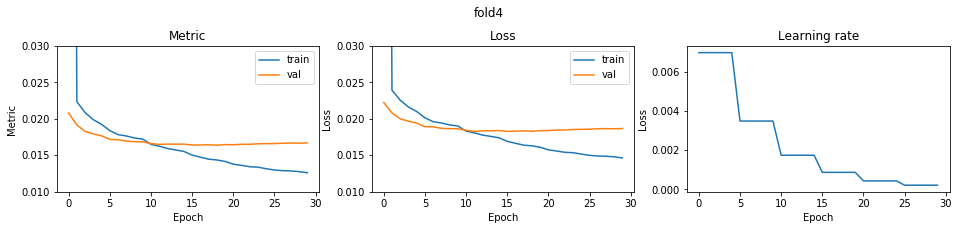

CV score: 0.01632502885984632

optimizer: RangerQH
fold 0


epoch1 save best model... 0.020216503259906194
epoch2 save best model... 0.018826810133925603
epoch3 save best model... 0.017991875824019957
epoch4 save best model... 0.017655224260579208
epoch5 save best model... 0.01737549037657729
epoch6 save best model... 0.016903630322469124
epoch7 save best model... 0.016732319497030253
epoch8 save best model... 0.016690757031423083
epoch9 save best model... 0.016536338120732873
epoch10 save best model... 0.01648625364200401
epoch11 save best model... 0.01635175260305744
epoch12 save best model... 0.01621114030174894
epoch15 save best model... 0.016172800398938748
epoch16 save best model... 0.016137142971174998
fold0 score: 0.01613714300449505


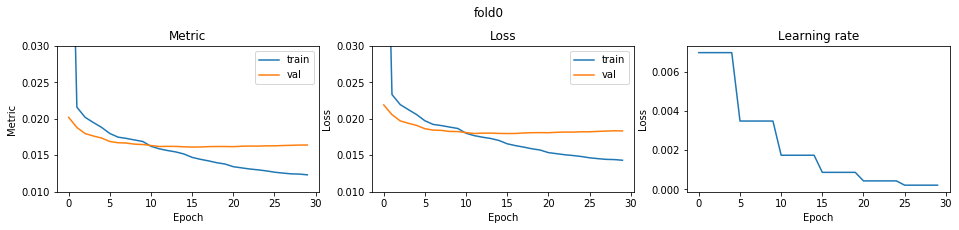

fold 1


epoch1 save best model... 0.0199579531846767
epoch2 save best model... 0.019112337631461803
epoch3 save best model... 0.018192596840304037
epoch4 save best model... 0.017743671448308424
epoch5 save best model... 0.017577647124785285
epoch6 save best model... 0.017126881619959927
epoch7 save best model... 0.016999497212253988
epoch9 save best model... 0.016833065693027123
epoch10 save best model... 0.01677292020213539
epoch11 save best model... 0.01655674257584546
epoch12 save best model... 0.016508072441306722
epoch15 save best model... 0.016451214657454333
epoch16 save best model... 0.016429191610147154
epoch17 save best model... 0.01642655134947975
fold1 score: 0.016426551226905096


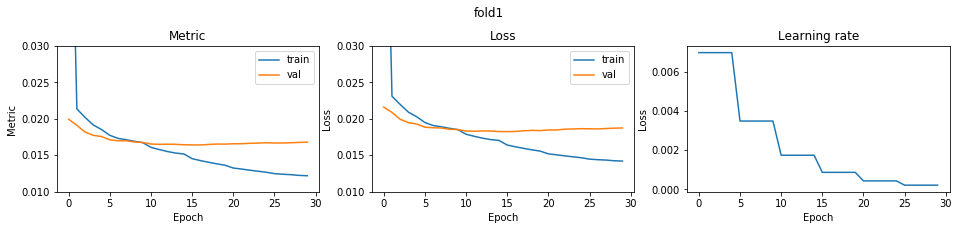

fold 2


epoch1 save best model... 0.020365449334041733
epoch2 save best model... 0.018908753650130117
epoch3 save best model... 0.018022207670995112
epoch4 save best model... 0.017576271699693526
epoch5 save best model... 0.017554946400362665
epoch6 save best model... 0.016951932401860405
epoch7 save best model... 0.016866484420969455
epoch8 save best model... 0.016764728175881486
epoch9 save best model... 0.01661304351940537
epoch10 save best model... 0.016563359876522975
epoch11 save best model... 0.016315883907408207
epoch12 save best model... 0.016269927189147916
epoch15 save best model... 0.016262287350393125
epoch16 save best model... 0.01622626556036453
epoch17 save best model... 0.01622624103829526
fold2 score: 0.01622624103037024


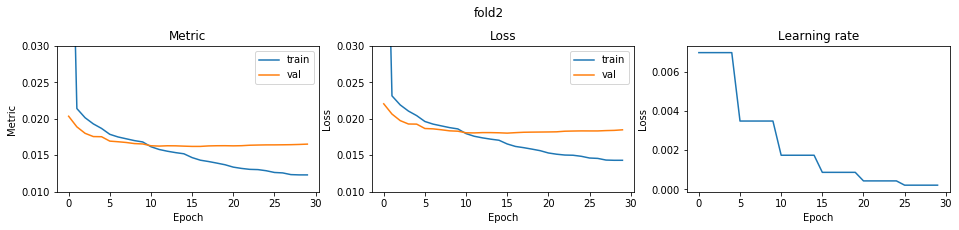

fold 3


epoch1 save best model... 0.020099987894092987
epoch2 save best model... 0.01887183529505154
epoch3 save best model... 0.01811538696127831
epoch4 save best model... 0.01777165194417526
epoch5 save best model... 0.017731520160608385
epoch6 save best model... 0.017099068903179675
epoch7 save best model... 0.016965117143013075
epoch9 save best model... 0.016884329038457883
epoch10 save best model... 0.01673687153362196
epoch11 save best model... 0.016547868763582444
epoch12 save best model... 0.016475033997674738
epoch15 save best model... 0.016470299718014742
epoch16 save best model... 0.016383348074412836
fold3 score: 0.016383348075935184


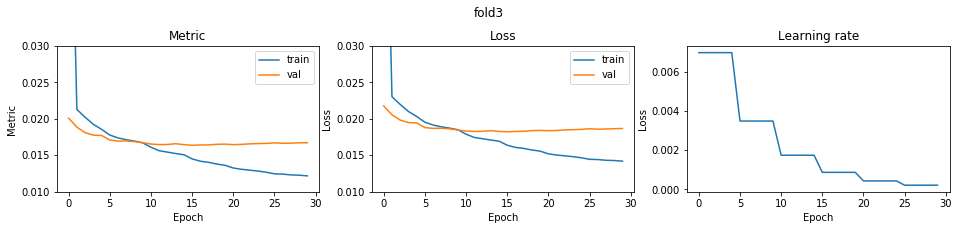

fold 4


epoch1 save best model... 0.01981989337483544
epoch2 save best model... 0.01904852066044791
epoch3 save best model... 0.017938621484320228
epoch4 save best model... 0.0176310603076206
epoch5 save best model... 0.017537158194734188
epoch6 save best model... 0.01705190012770321
epoch7 save best model... 0.01694240605242228
epoch8 save best model... 0.016856431033979925
epoch9 save best model... 0.016744127884880555
epoch10 save best model... 0.016706995175120365
epoch11 save best model... 0.01654039597804902
epoch12 save best model... 0.01651208439464246
epoch13 save best model... 0.01644410990424675
epoch15 save best model... 0.016418757848017308
epoch16 save best model... 0.016386994356735015
fold4 score: 0.016386994320258603


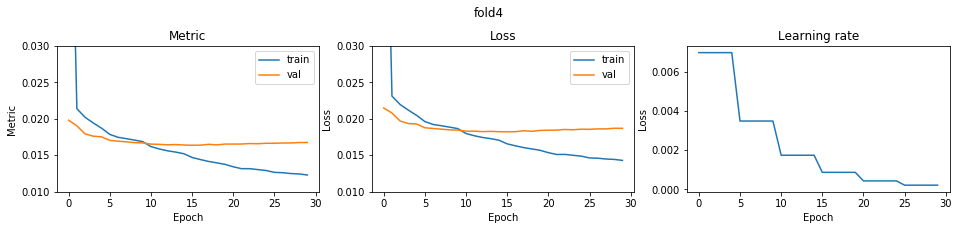

CV score: 0.016312054224813445

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5351057974515581
epoch2 save best model... 0.05886515974828757
epoch3 save best model... 0.02799553391279691
epoch4 save best model... 0.023416355238688562
epoch5 save best model... 0.021902466383773266
epoch6 save best model... 0.021527920055769572
epoch7 save best model... 0.021148635127957154
epoch8 save best model... 0.020862102637529915
epoch9 save best model... 0.02067620449005743
epoch10 save best model... 0.020550232703939658
epoch11 save best model... 0.020484586728732514
epoch12 save best model... 0.020391998060709522
epoch13 save best model... 0.020333887829290437
epoch14 save best model... 0.020273207761941303
epoch15 save best model... 0.02019882372120111
epoch16 save best model... 0.020165033065682122
epoch17 save best model... 0.020160302937302338
epoch18 save best model... 0.020077236287787997
epoch19 save best model... 0.020070317749926875
epoch20 save best model... 0.02000862921849063
epoch21 save best model... 0.02000181333231899
epoch23 s

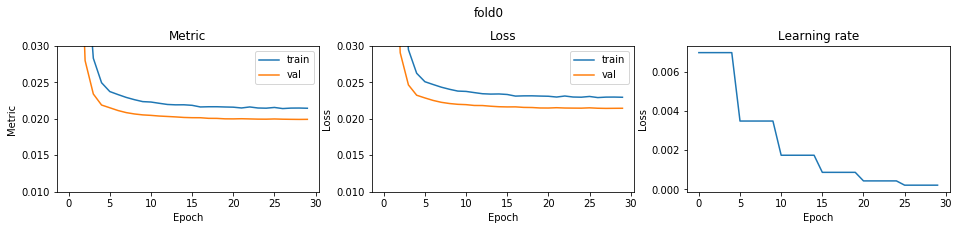

fold 1


epoch1 save best model... 0.5410839644616979
epoch2 save best model... 0.059133750511943195
epoch3 save best model... 0.02802911297583477
epoch4 save best model... 0.0234403178005847
epoch5 save best model... 0.021980279784986574
epoch6 save best model... 0.02161584087361247
epoch7 save best model... 0.021220369555190202
epoch8 save best model... 0.02098576512589192
epoch9 save best model... 0.020810781297562305
epoch10 save best model... 0.02068272175886523
epoch11 save best model... 0.020617945019158288
epoch12 save best model... 0.020467265040330855
epoch13 save best model... 0.02038674769207146
epoch14 save best model... 0.02036262858267742
epoch15 save best model... 0.02031548083164638
epoch16 save best model... 0.020244077662008992
epoch18 save best model... 0.02023770643271273
epoch20 save best model... 0.020144972332733508
epoch24 save best model... 0.020107013593759073
epoch25 save best model... 0.02009558025217051
epoch29 save best model... 0.020090449981240346
epoch30 save b

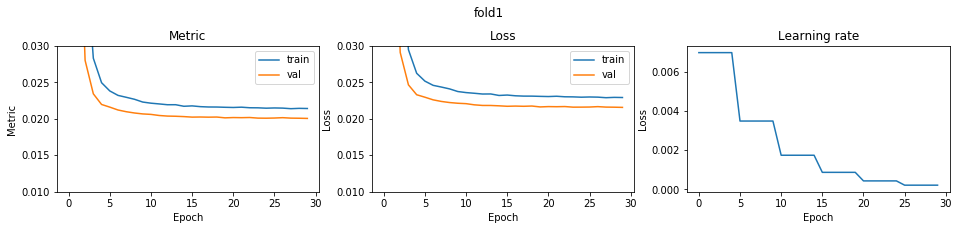

fold 2


epoch1 save best model... 0.5322257395647848
epoch2 save best model... 0.058343736383971445
epoch3 save best model... 0.027645021659192855
epoch4 save best model... 0.023390477611905054
epoch5 save best model... 0.021812627822802397
epoch6 save best model... 0.02144442947900127
epoch7 save best model... 0.02108724988058233
epoch8 save best model... 0.020860181122807766
epoch9 save best model... 0.020714976317038104
epoch10 save best model... 0.02053659613500779
epoch11 save best model... 0.020504957886604138
epoch12 save best model... 0.020450886737450866
epoch13 save best model... 0.020368809407964386
epoch14 save best model... 0.020300999104698254
epoch15 save best model... 0.02021576165872857
epoch16 save best model... 0.02020733903157301
epoch17 save best model... 0.020156799067608804
epoch18 save best model... 0.02014754629273992
epoch19 save best model... 0.020125649454389136
epoch20 save best model... 0.020087625186293673
epoch21 save best model... 0.020032326578177252
epoch24 s

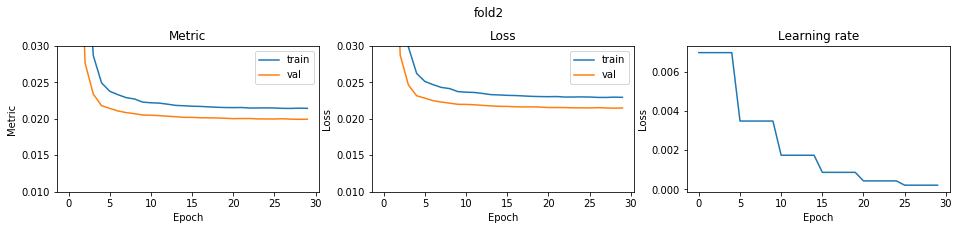

fold 3


epoch1 save best model... 0.5448750358236135
epoch2 save best model... 0.06045227134960931
epoch3 save best model... 0.028559190319991056
epoch4 save best model... 0.02361380868508631
epoch5 save best model... 0.02223788195274821
epoch6 save best model... 0.021755750155700096
epoch7 save best model... 0.021449625197636782
epoch8 save best model... 0.021102489572196587
epoch9 save best model... 0.02099881717863075
epoch10 save best model... 0.02079708509376285
epoch11 save best model... 0.020757511998516144
epoch12 save best model... 0.02062868140722733
epoch13 save best model... 0.02057849703683329
epoch14 save best model... 0.02049746310045616
epoch15 save best model... 0.020442946377403372
epoch16 save best model... 0.02040604898039939
epoch17 save best model... 0.020385368726723287
epoch18 save best model... 0.020355891717644514
epoch19 save best model... 0.020321004577659937
epoch21 save best model... 0.02030002364426308
epoch22 save best model... 0.0202186690511899
fold3 score: 0.

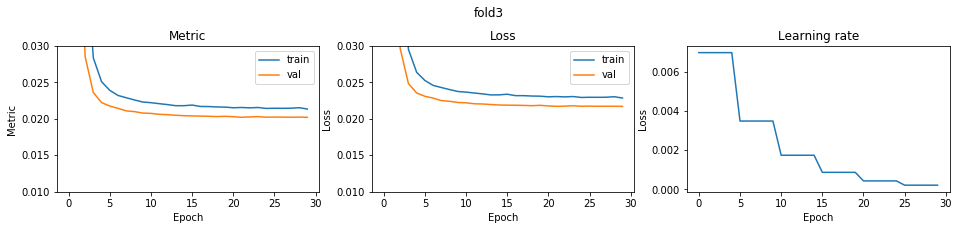

fold 4


epoch1 save best model... 0.5319957133849281
epoch2 save best model... 0.05750637646586314
epoch3 save best model... 0.027337436221862438
epoch4 save best model... 0.023001567645163905
epoch5 save best model... 0.021508800306257736
epoch6 save best model... 0.021070262404468444
epoch7 save best model... 0.02096227453194202
epoch8 save best model... 0.020639769003168596
epoch9 save best model... 0.020431182126181544
epoch10 save best model... 0.020258172222992282
epoch11 save best model... 0.02010640894446802
epoch13 save best model... 0.019996764462500607
epoch14 save best model... 0.019959607420824383
epoch15 save best model... 0.019907346850681143
epoch16 save best model... 0.0198291627049514
epoch18 save best model... 0.01981077942666269
epoch19 save best model... 0.01979075147683365
epoch20 save best model... 0.019772038881185387
epoch21 save best model... 0.019737547528261748
epoch23 save best model... 0.01969246393184184
epoch25 save best model... 0.019656510982059942
epoch27 sav

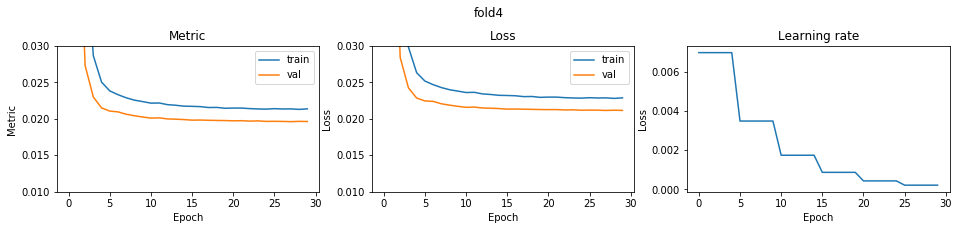

CV score: 0.019956317608243675

optimizer: SWATS
fold 0


epoch1 save best model... 0.02047952175191296
epoch2 save best model... 0.018912082510853953
epoch3 save best model... 0.018127056117888736
epoch4 save best model... 0.017803906330282976
epoch5 save best model... 0.017526608039381022
epoch6 save best model... 0.017177744054475242
epoch7 save best model... 0.017063993040752304
epoch8 save best model... 0.016909466464080952
epoch9 save best model... 0.016891233582295696
epoch10 save best model... 0.016816906998430407
epoch11 save best model... 0.016728392869641406
epoch12 save best model... 0.01661096689692255
epoch14 save best model... 0.01659304635824131
epoch15 save best model... 0.016508338793026017
epoch16 save best model... 0.016502447256602024
epoch17 save best model... 0.016465916074727555
epoch19 save best model... 0.01643760641251854
epoch20 save best model... 0.01640678454351724
epoch22 save best model... 0.01639977683459572
epoch23 save best model... 0.01638255513321973
epoch24 save best model... 0.01637305100798471
epoch25 s

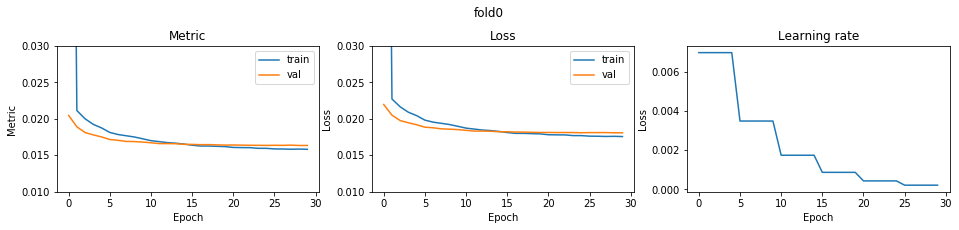

fold 1


epoch1 save best model... 0.020409318255835633
epoch2 save best model... 0.0191425207211267
epoch3 save best model... 0.01854033938866456
epoch4 save best model... 0.01787835420812757
epoch5 save best model... 0.017551707114882582
epoch6 save best model... 0.017396881958263073
epoch7 save best model... 0.017374719337127996
epoch8 save best model... 0.01723067161000503
epoch9 save best model... 0.017098720434363054
epoch10 save best model... 0.01706592478647431
epoch11 save best model... 0.016987935176696802
epoch12 save best model... 0.016921505447427026
epoch13 save best model... 0.016868436723475603
epoch16 save best model... 0.016770868977002577
epoch18 save best model... 0.01672040262295828
epoch19 save best model... 0.016712912839813396
epoch21 save best model... 0.01667355083007222
epoch23 save best model... 0.016662950811266397
epoch24 save best model... 0.016647621769840856
epoch25 save best model... 0.016639018875853798
epoch29 save best model... 0.016619985345152657
fold1 sco

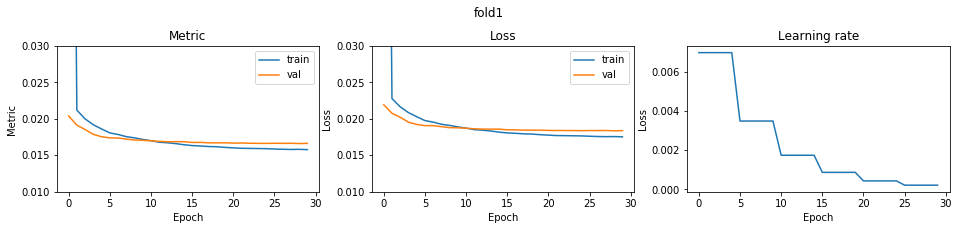

fold 2


epoch1 save best model... 0.020461430050828212
epoch2 save best model... 0.01888586786200243
epoch3 save best model... 0.018166272879779122
epoch4 save best model... 0.017711911800553638
epoch5 save best model... 0.017324877633590325
epoch6 save best model... 0.01721553277079161
epoch7 save best model... 0.01706441010605891
epoch8 save best model... 0.0170049610795777
epoch9 save best model... 0.01686185124245557
epoch10 save best model... 0.016812058996836115
epoch11 save best model... 0.01668213895573197
epoch12 save best model... 0.016665054164787828
epoch13 save best model... 0.01660153272823365
epoch14 save best model... 0.01659016236327597
epoch15 save best model... 0.01652377163475699
epoch16 save best model... 0.016515781559724014
epoch17 save best model... 0.01646837307465738
epoch19 save best model... 0.016447279972993355
epoch21 save best model... 0.01643992542959945
epoch26 save best model... 0.016439108027573476
fold2 score: 0.01643910788400513


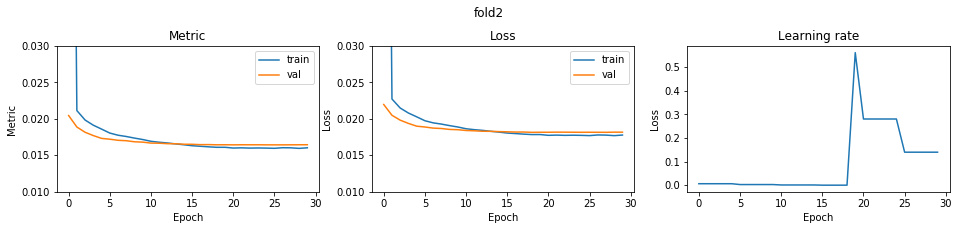

fold 3


epoch1 save best model... 0.020445616362968582
epoch2 save best model... 0.01919378944606879
epoch3 save best model... 0.018485418871757923
epoch4 save best model... 0.017998357364538725
epoch5 save best model... 0.017742753576631562
epoch6 save best model... 0.017524789108688984
epoch7 save best model... 0.017451936616678987
epoch8 save best model... 0.017233756424303342
epoch9 save best model... 0.017132607830904745
epoch10 save best model... 0.017045414760488178
epoch11 save best model... 0.017019583295462208
epoch12 save best model... 0.016971484866578786
epoch13 save best model... 0.01690446544642261
epoch15 save best model... 0.01681973730767642
epoch17 save best model... 0.016784368370975748
epoch18 save best model... 0.016732794356984267
epoch21 save best model... 0.016679118964439237
epoch22 save best model... 0.016672821564850206
epoch24 save best model... 0.01663784340940467
epoch29 save best model... 0.01662428303152866
fold3 score: 0.01662428300373956


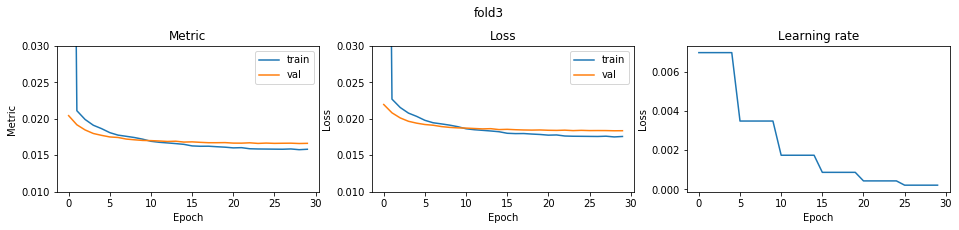

fold 4


epoch1 save best model... 0.02015846303339564
epoch2 save best model... 0.01886587939341818
epoch3 save best model... 0.018170510853613157
epoch4 save best model... 0.017780801237630817
epoch5 save best model... 0.0174943083137749
epoch6 save best model... 0.017312354161690472
epoch7 save best model... 0.017212391679083974
epoch8 save best model... 0.01712133755232791
epoch9 save best model... 0.016996854825416297
epoch11 save best model... 0.016913371260335205
epoch12 save best model... 0.0168262598832437
epoch13 save best model... 0.016787150749567565
epoch15 save best model... 0.016742223773177092
epoch16 save best model... 0.016706824368863008
epoch17 save best model... 0.01670449484894922
epoch18 save best model... 0.016653079654945058
epoch19 save best model... 0.016615228552227003
epoch20 save best model... 0.016591671463908258
epoch22 save best model... 0.01658761021309874
epoch23 save best model... 0.01656342616139281
epoch25 save best model... 0.016541983058637938
epoch30 sav

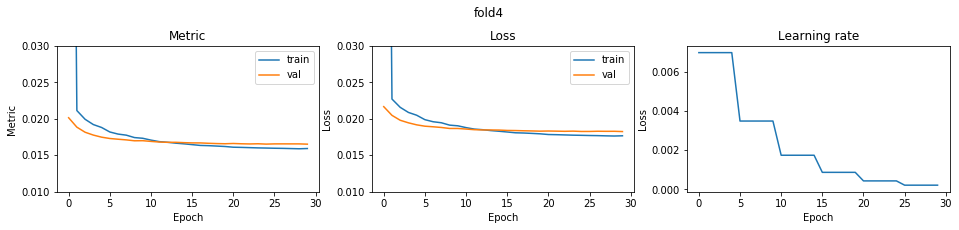

CV score: 0.016514590510321562

optimizer: Yogi
fold 0


epoch1 save best model... 0.02071255784659967
epoch2 save best model... 0.01932397713473147
epoch3 save best model... 0.01854522733743343
epoch4 save best model... 0.018038938796160434
epoch5 save best model... 0.01772807457978606
epoch6 save best model... 0.017520346047021535
epoch7 save best model... 0.017393485930215797
epoch8 save best model... 0.0173166274676494
epoch9 save best model... 0.017199705155027483
epoch10 save best model... 0.01713171248199049
epoch11 save best model... 0.01704948916097844
epoch12 save best model... 0.017008748531748875
epoch13 save best model... 0.01697595787397957
epoch14 save best model... 0.01694016859936687
epoch15 save best model... 0.016880964502217016
epoch16 save best model... 0.01685518991617923
epoch17 save best model... 0.016848811015045453
epoch18 save best model... 0.016794825003297834
epoch19 save best model... 0.016788846699856138
epoch20 save best model... 0.016767269594420875
epoch22 save best model... 0.01675744234140886
epoch23 save 

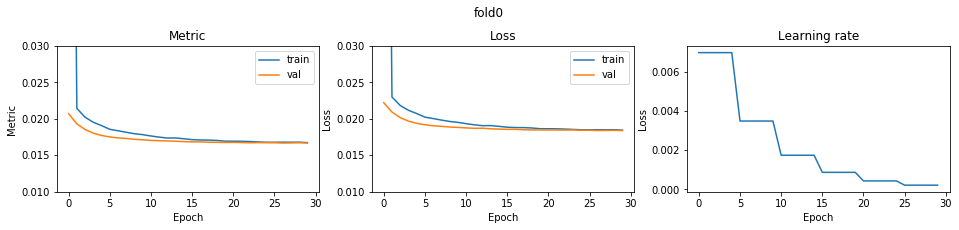

fold 1


epoch1 save best model... 0.020715069880899602
epoch2 save best model... 0.019334098823685992
epoch3 save best model... 0.018525851432952965
epoch4 save best model... 0.018053136637366886
epoch5 save best model... 0.017836235304473202
epoch6 save best model... 0.0176177608109391
epoch7 save best model... 0.017539619133945857
epoch8 save best model... 0.017449971094921038
epoch9 save best model... 0.017371185238081194
epoch10 save best model... 0.017327901288717612
epoch11 save best model... 0.017197113720529116
epoch12 save best model... 0.017169956616525987
epoch13 save best model... 0.017145488540626898
epoch14 save best model... 0.01707908113466482
epoch15 save best model... 0.017048829378792325
epoch16 save best model... 0.01702003272776113
epoch17 save best model... 0.01700036476140659
epoch18 save best model... 0.016971973645443336
epoch22 save best model... 0.016963702857182003
epoch23 save best model... 0.016953809755073643
epoch24 save best model... 0.016942567520283246
epoch2

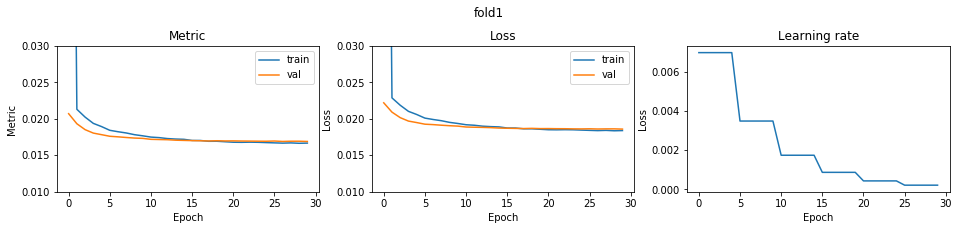

fold 2


epoch1 save best model... 0.020712124929426198
epoch2 save best model... 0.01925886126999453
epoch3 save best model... 0.018508327706220632
epoch4 save best model... 0.017973043426436724
epoch5 save best model... 0.017693897346821887
epoch6 save best model... 0.017494798102347133
epoch7 save best model... 0.01736577184827127
epoch8 save best model... 0.017264279718541574
epoch9 save best model... 0.017141172884333023
epoch10 save best model... 0.01704065718934853
epoch11 save best model... 0.017004055987876337
epoch12 save best model... 0.01698740938388526
epoch13 save best model... 0.016920723562339125
epoch14 save best model... 0.016877143938747088
epoch15 save best model... 0.016839245961090786
epoch16 save best model... 0.01680923162054081
epoch18 save best model... 0.016777059428926874
epoch19 save best model... 0.016735050103044248
epoch20 save best model... 0.01670616292741636
epoch23 save best model... 0.01670277508145029
epoch24 save best model... 0.01670073080951368
epoch26 s

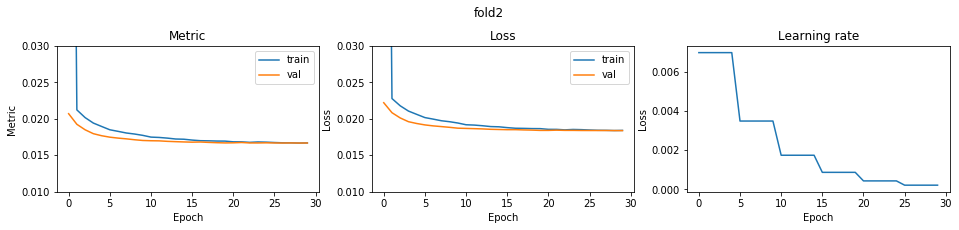

fold 3


epoch1 save best model... 0.020643666219432966
epoch2 save best model... 0.01950015898556332
epoch3 save best model... 0.01873208624491116
epoch4 save best model... 0.018175996217562697
epoch5 save best model... 0.017964195312427225
epoch6 save best model... 0.017719338508428908
epoch7 save best model... 0.01754384093317532
epoch8 save best model... 0.01749909826997744
epoch9 save best model... 0.0173805718592332
epoch10 save best model... 0.01724476026400822
epoch11 save best model... 0.01721588158279929
epoch12 save best model... 0.017177781191122017
epoch13 save best model... 0.017172104636194493
epoch14 save best model... 0.017080438070864776
epoch16 save best model... 0.01705050357746847
epoch18 save best model... 0.017026919476127843
epoch19 save best model... 0.017011415254078587
epoch21 save best model... 0.016982101644378723
epoch22 save best model... 0.016936598163615733
epoch28 save best model... 0.016934937537819623
fold3 score: 0.016934937664814503


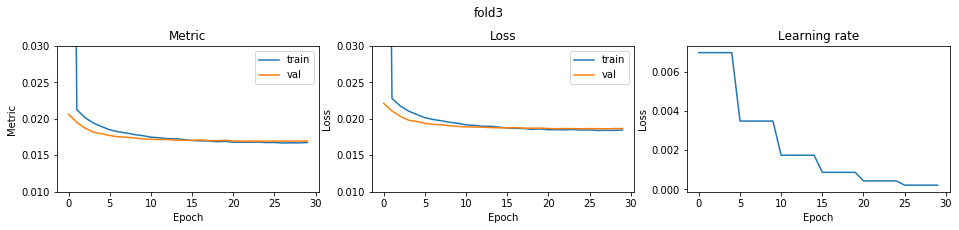

fold 4


epoch1 save best model... 0.020321210113975616
epoch2 save best model... 0.019042274489964876
epoch3 save best model... 0.018315621410286507
epoch4 save best model... 0.017946209924842884
epoch5 save best model... 0.01766479964408353
epoch6 save best model... 0.017487704844250086
epoch7 save best model... 0.017388497626065258
epoch8 save best model... 0.017313784934953703
epoch9 save best model... 0.017218221198334646
epoch10 save best model... 0.017168178356725697
epoch11 save best model... 0.017078597348073078
epoch12 save best model... 0.017028917236877328
epoch13 save best model... 0.017020631836544814
epoch14 save best model... 0.016972120718474676
epoch16 save best model... 0.016902962540847024
epoch17 save best model... 0.016897645080143877
epoch18 save best model... 0.016884579069929406
epoch19 save best model... 0.01687958532380012
epoch20 save best model... 0.01685401683584161
epoch21 save best model... 0.016826470921363402
epoch23 save best model... 0.016823700192153183
epoc

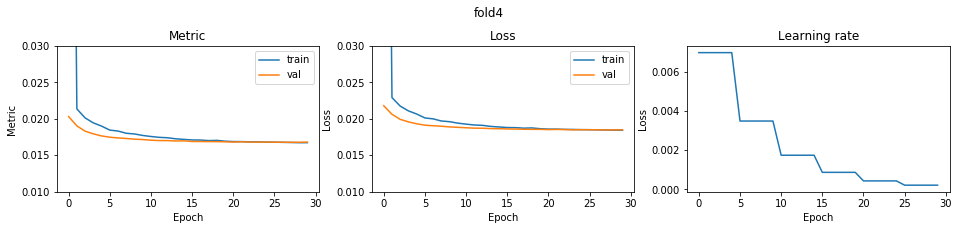

CV score: 0.016799909860815733

optimizer: Adam
fold 0


epoch1 save best model... 0.020014831468734492
epoch2 save best model... 0.018401151778418275
epoch3 save best model... 0.017879194790043428
epoch4 save best model... 0.017603777113088442
epoch5 save best model... 0.01748824231156863
epoch6 save best model... 0.016971775878365056
epoch7 save best model... 0.01690336802469435
epoch9 save best model... 0.016759808714541868
epoch11 save best model... 0.016492341925943767
epoch13 save best model... 0.0164585858893184
epoch14 save best model... 0.016433888664447907
epoch16 save best model... 0.016270208139829594
fold0 score: 0.016270208101940336


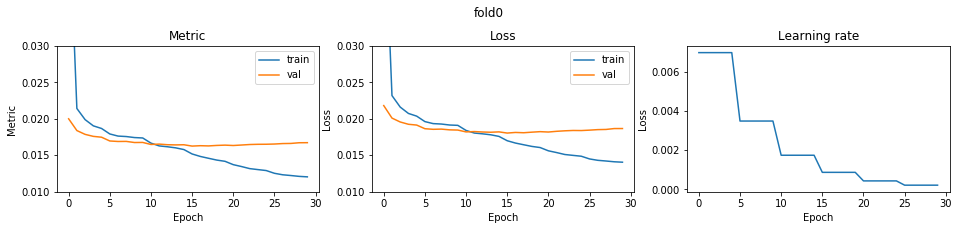

fold 1


epoch1 save best model... 0.019961307303142672
epoch2 save best model... 0.018681480476068702
epoch3 save best model... 0.017903104403681543
epoch4 save best model... 0.017757357842753407
epoch5 save best model... 0.017602445228175126
epoch6 save best model... 0.017208692902479703
epoch7 save best model... 0.01710051125499865
epoch9 save best model... 0.016983081639071047
epoch11 save best model... 0.01670839237446026
epoch12 save best model... 0.016694876826038308
epoch16 save best model... 0.01658189093736954
fold1 score: 0.016581890941613782


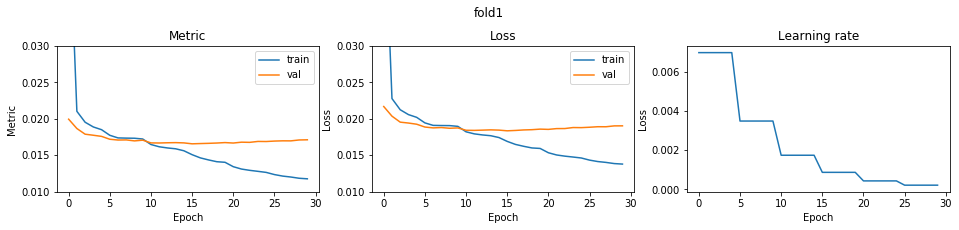

fold 2


epoch1 save best model... 0.02054571612691602
epoch2 save best model... 0.018626920732472827
epoch3 save best model... 0.018019643890393244
epoch4 save best model... 0.01762493552271286
epoch5 save best model... 0.017589135336105902
epoch6 save best model... 0.01709149548867503
epoch7 save best model... 0.017015961607195408
epoch8 save best model... 0.016883823291735336
epoch11 save best model... 0.016524517590824687
epoch13 save best model... 0.016510548589737967
epoch15 save best model... 0.016462482743289455
epoch16 save best model... 0.01633801031645534
epoch17 save best model... 0.016308201459955995
fold2 score: 0.01630820140679274


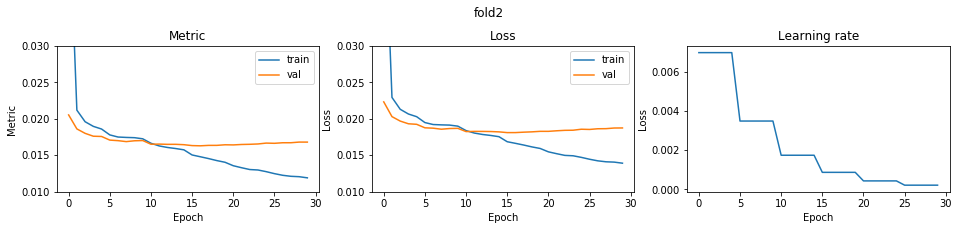

fold 3


epoch1 save best model... 0.02027473168316083
epoch2 save best model... 0.019017935262522014
epoch3 save best model... 0.018312622104815986
epoch4 save best model... 0.017937860455881628
epoch5 save best model... 0.0178563186754568
epoch6 save best model... 0.017266293249786714
epoch8 save best model... 0.017248690754582508
epoch9 save best model... 0.017092705163722837
epoch10 save best model... 0.01708909139749944
epoch11 save best model... 0.016781050367768776
epoch12 save best model... 0.016690225292905182
epoch15 save best model... 0.016647229309709306
epoch16 save best model... 0.016455858492701907
fold3 score: 0.0164558584102008


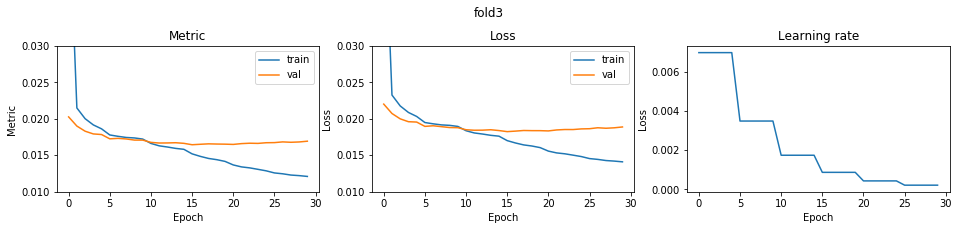

fold 4


epoch1 save best model... 0.01956353678976892
epoch2 save best model... 0.018453300775692783
epoch3 save best model... 0.0177782253648636
epoch4 save best model... 0.017563417167795276
epoch5 save best model... 0.017463180666751225
epoch6 save best model... 0.01712414482926657
epoch7 save best model... 0.01709399356003978
epoch8 save best model... 0.016916396172297163
epoch11 save best model... 0.01659830356216173
epoch12 save best model... 0.016577699006129914
epoch14 save best model... 0.01656948152997431
epoch16 save best model... 0.01644334258481962
fold4 score: 0.01644334251941879


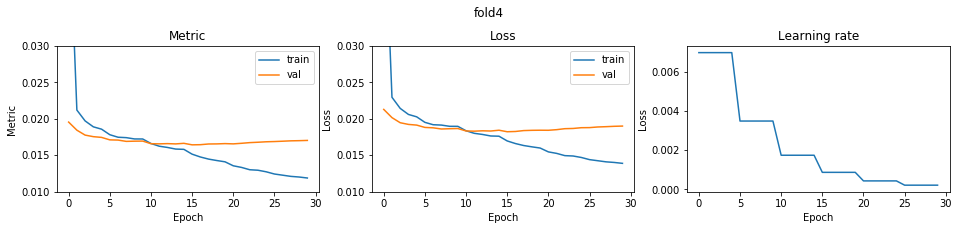

CV score: 0.016411897255590686

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.0200355836998561
epoch2 save best model... 0.01872089030666612
epoch3 save best model... 0.018013850793853436
epoch4 save best model... 0.01755114142997254
epoch5 save best model... 0.017329875062429823
epoch6 save best model... 0.016923953315289796
epoch7 save best model... 0.016771180360898343
epoch8 save best model... 0.01671554374939217
epoch9 save best model... 0.016671324035912278
epoch10 save best model... 0.016517945737970444
epoch11 save best model... 0.016310472124954154
epoch12 save best model... 0.01626334617461729
epoch13 save best model... 0.016255413677229425
epoch14 save best model... 0.016236569630597338
epoch15 save best model... 0.01621005425106624
epoch16 save best model... 0.016173825606466154
epoch17 save best model... 0.01616628705683018
fold0 score: 0.01616628699561903


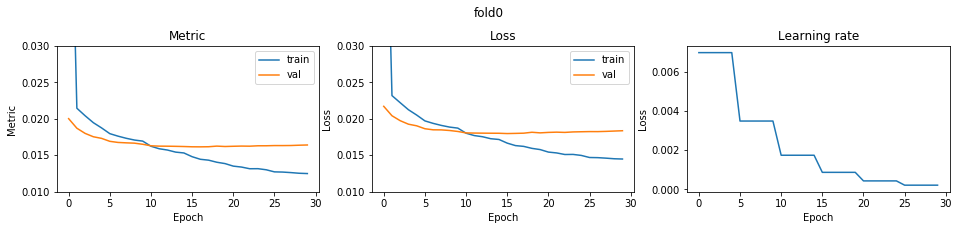

fold 1


epoch1 save best model... 0.020445671008921452
epoch2 save best model... 0.019158065862704122
epoch3 save best model... 0.01820064599777061
epoch4 save best model... 0.01795615728729799
epoch5 save best model... 0.01765286785843881
epoch6 save best model... 0.017180202741029053
epoch7 save best model... 0.017035798814532207
epoch9 save best model... 0.016866858216165126
epoch10 save best model... 0.016862151973283925
epoch11 save best model... 0.016709058346491206
epoch12 save best model... 0.01660183652845846
epoch13 save best model... 0.016588883693029733
epoch16 save best model... 0.016537657296159837
fold1 score: 0.01653765728987018


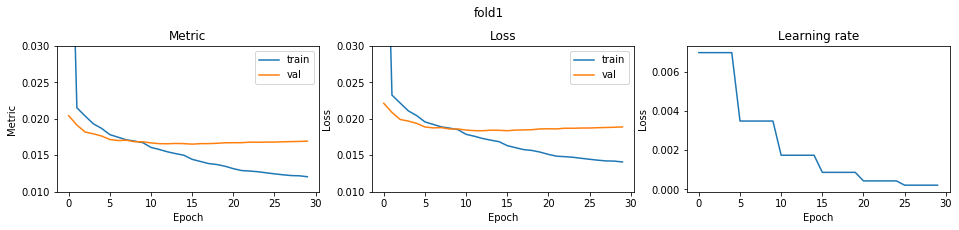

fold 2


epoch1 save best model... 0.020000269087776287
epoch2 save best model... 0.019276990980464998
epoch3 save best model... 0.0182770448515103
epoch4 save best model... 0.01777698066150084
epoch5 save best model... 0.017456529250143127
epoch6 save best model... 0.017000926843757144
epoch7 save best model... 0.01687557717407957
epoch8 save best model... 0.016815589199139294
epoch9 save best model... 0.016667518320610742
epoch10 save best model... 0.01664203178225814
epoch11 save best model... 0.016388402087666988
epoch12 save best model... 0.016384798239370797
epoch13 save best model... 0.01634371303120366
epoch14 save best model... 0.01633394598463492
epoch16 save best model... 0.016226616228458942
fold2 score: 0.016226616252008042


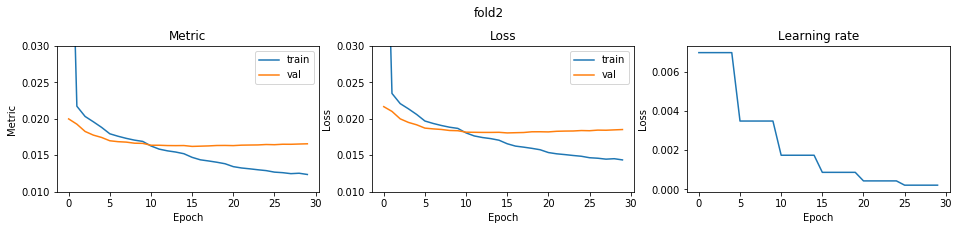

fold 3


epoch1 save best model... 0.020470394491555344
epoch2 save best model... 0.019088792044389357
epoch3 save best model... 0.01836687999147421
epoch4 save best model... 0.017789391433323705
epoch5 save best model... 0.017637625152928275
epoch6 save best model... 0.01723834881113507
epoch7 save best model... 0.017144945096266975
epoch8 save best model... 0.01705299925890694
epoch9 save best model... 0.01695883403105793
epoch10 save best model... 0.016871223198610584
epoch11 save best model... 0.01667443718930923
epoch12 save best model... 0.016590068359479546
epoch14 save best model... 0.016554241041506476
epoch16 save best model... 0.01650055256674325
epoch17 save best model... 0.016476734585058717
epoch18 save best model... 0.016475956929011742
fold3 score: 0.016475956868746807


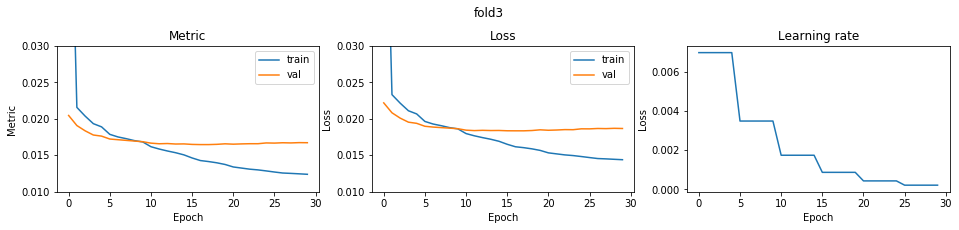

fold 4


epoch1 save best model... 0.020007941213379146
epoch2 save best model... 0.018895531432164287
epoch3 save best model... 0.01796057818877534
epoch4 save best model... 0.017724741552797293
epoch5 save best model... 0.01752449409412496
epoch6 save best model... 0.017063537982116392
epoch7 save best model... 0.016932041719470995
epoch8 save best model... 0.016866017998979004
epoch9 save best model... 0.016773757219721897
epoch10 save best model... 0.01667355212482681
epoch11 save best model... 0.016582630910318776
epoch12 save best model... 0.016485560666727312
epoch13 save best model... 0.016442961536415755
epoch14 save best model... 0.016398619414054724
fold4 score: 0.016398619424937654


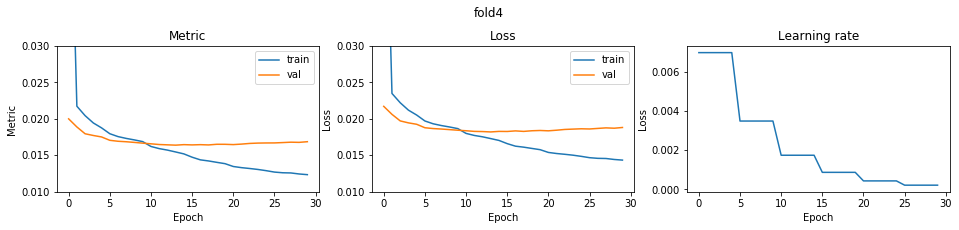

CV score: 0.016361025442652898

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.020734610712338147
epoch2 save best model... 0.019335730327187203
epoch3 save best model... 0.01847550370444062
epoch4 save best model... 0.017960561679544643
epoch5 save best model... 0.01766470967620136
epoch6 save best model... 0.017220821885863036
epoch7 save best model... 0.017088658467003044
epoch8 save best model... 0.01694906271213415
epoch9 save best model... 0.01681139582093457
epoch10 save best model... 0.01665773909785074
epoch11 save best model... 0.016526718535683285
epoch12 save best model... 0.016456693324317692
epoch13 save best model... 0.01636836522243968
epoch14 save best model... 0.016338731932341373
epoch15 save best model... 0.01627702492974478
epoch16 save best model... 0.0161920660618769
epoch17 save best model... 0.016162130013447688
epoch20 save best model... 0.016143112580434067
epoch21 save best model... 0.016132695501105934
epoch22 save best model... 0.01612788592263683
epoch24 save best model... 0.01612024488508837
epoch30 save

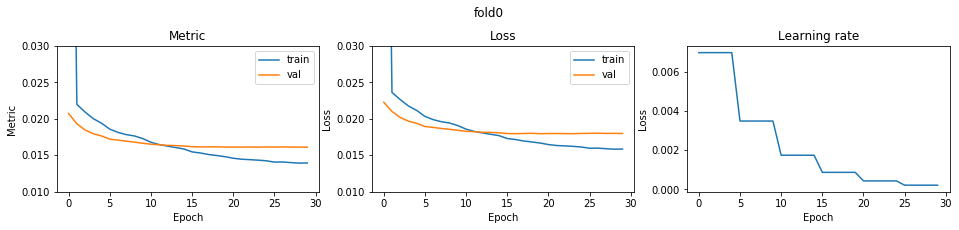

fold 1


epoch1 save best model... 0.020984581199097564
epoch2 save best model... 0.01957268212147619
epoch3 save best model... 0.018911799687130845
epoch4 save best model... 0.018336788453900153
epoch5 save best model... 0.017994583589673097
epoch6 save best model... 0.017475406438753935
epoch7 save best model... 0.017250273684597785
epoch8 save best model... 0.017241079848294486
epoch9 save best model... 0.01708850578300351
epoch10 save best model... 0.01694170973463356
epoch11 save best model... 0.01675827680382683
epoch12 save best model... 0.016634194761570683
epoch14 save best model... 0.016540391080371745
epoch16 save best model... 0.016465501797823273
epoch17 save best model... 0.016457648069773265
epoch19 save best model... 0.016440817741025727
epoch21 save best model... 0.01642523608689266
epoch22 save best model... 0.016409806728509026
fold1 score: 0.016409806626031948


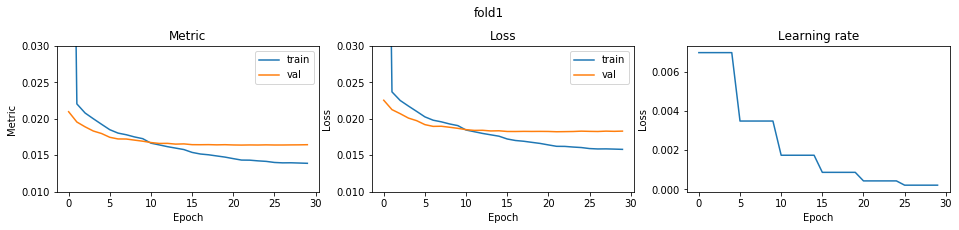

fold 2


epoch1 save best model... 0.02063120086926701
epoch2 save best model... 0.019702328804232762
epoch3 save best model... 0.018481828761451484
epoch4 save best model... 0.018131644602107023
epoch5 save best model... 0.017706089961393653
epoch6 save best model... 0.017290153721248567
epoch7 save best model... 0.01709001711031813
epoch8 save best model... 0.01698949707573966
epoch9 save best model... 0.016804385956399708
epoch10 save best model... 0.016783395995368756
epoch11 save best model... 0.016566346779951176
epoch12 save best model... 0.01649558260794122
epoch13 save best model... 0.016454579633074746
epoch14 save best model... 0.016382033502741186
epoch15 save best model... 0.0163395060396077
epoch16 save best model... 0.01627238383327816
epoch17 save best model... 0.016230989191116707
epoch19 save best model... 0.01622967890216138
epoch21 save best model... 0.016202976291213676
epoch22 save best model... 0.016202962131248597
epoch23 save best model... 0.01617944321861861
fold2 scor

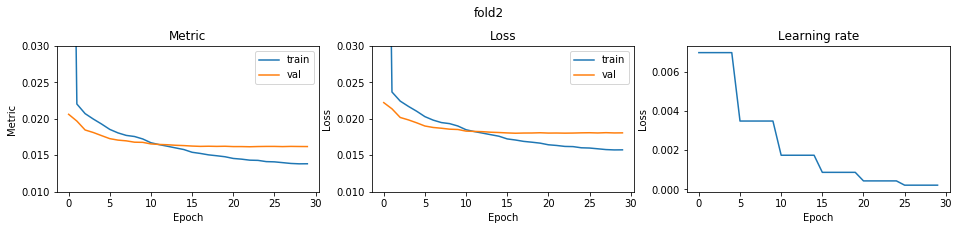

fold 3


epoch1 save best model... 0.020773528521808377
epoch2 save best model... 0.01959083022630364
epoch3 save best model... 0.019093446833652217
epoch4 save best model... 0.018171718591455038
epoch5 save best model... 0.017798126154581345
epoch6 save best model... 0.017466903272973785
epoch7 save best model... 0.017279581917377704
epoch8 save best model... 0.01714664825953221
epoch9 save best model... 0.01704177249664258
epoch10 save best model... 0.016947643460540403
epoch11 save best model... 0.016723624193417184
epoch12 save best model... 0.016715315599546074
epoch13 save best model... 0.01664847251418172
epoch14 save best model... 0.016616942772985456
epoch15 save best model... 0.01656916991622953
epoch16 save best model... 0.01644287765119437
epoch18 save best model... 0.01643267047882148
epoch19 save best model... 0.01643129619971291
epoch20 save best model... 0.01641610987942691
epoch21 save best model... 0.016371777403785728
epoch26 save best model... 0.016356742741001223
fold3 scor

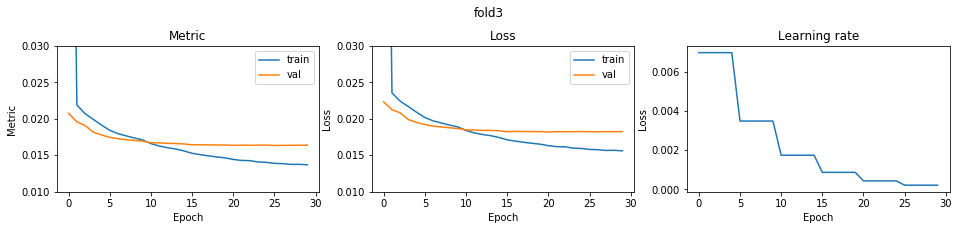

fold 4


epoch1 save best model... 0.020386206556391607
epoch2 save best model... 0.019345317661320974
epoch3 save best model... 0.018443819517290946
epoch4 save best model... 0.017997594048737936
epoch5 save best model... 0.017599408005646393
epoch6 save best model... 0.017237697769134627
epoch7 save best model... 0.017123291027097875
epoch8 save best model... 0.017068176279120266
epoch9 save best model... 0.016980453773671102
epoch10 save best model... 0.016816971332242116
epoch11 save best model... 0.01664258908811354
epoch12 save best model... 0.01660001587105707
epoch13 save best model... 0.01654656891942296
epoch14 save best model... 0.016459922473410948
epoch16 save best model... 0.01640347123510949
epoch18 save best model... 0.016400147793318116
epoch21 save best model... 0.01636538158270588
fold4 score: 0.016365381591242723


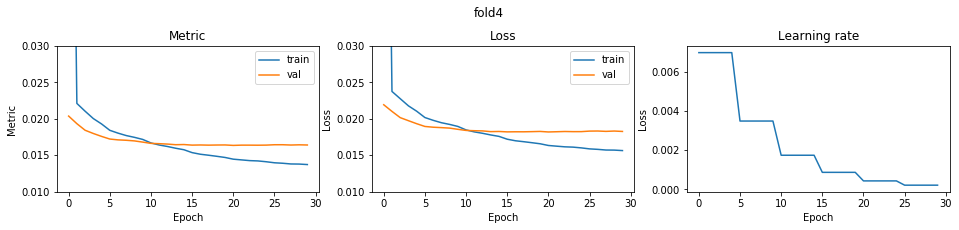

CV score: 0.016286184414022926

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.02217877148088399
epoch2 save best model... 0.020338701279430833
epoch3 save best model... 0.01945216814586405
epoch4 save best model... 0.018860233542859418
epoch5 save best model... 0.018440663823879117
epoch6 save best model... 0.018196762363364864
epoch7 save best model... 0.01802371980915173
epoch8 save best model... 0.017959899055625148
epoch9 save best model... 0.017839944679162768
epoch10 save best model... 0.0177112667191273
epoch11 save best model... 0.01768154685548878
epoch12 save best model... 0.017603294619259368
epoch13 save best model... 0.017595179483362373
epoch14 save best model... 0.01746779249255505
epoch16 save best model... 0.017452379961865095
epoch17 save best model... 0.017418927718844936
epoch18 save best model... 0.017418465129437097
epoch19 save best model... 0.017386875451799136
epoch20 save best model... 0.017355843971998925
epoch22 save best model... 0.01732052556813985
epoch25 save best model... 0.017270937024834215
epoch30 s

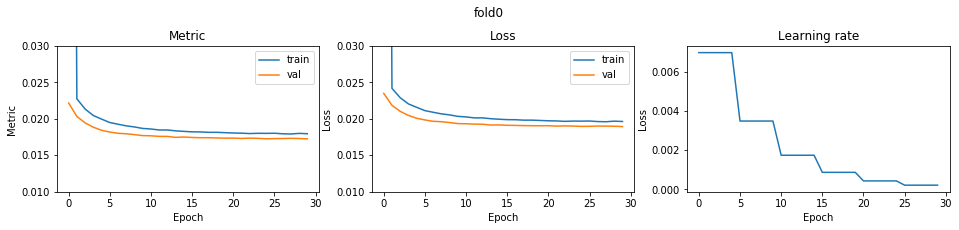

fold 1


epoch1 save best model... 0.02200192364905005
epoch2 save best model... 0.020206705742407616
epoch3 save best model... 0.01936649401135544
epoch4 save best model... 0.01883158380516666
epoch5 save best model... 0.018482567256541044
epoch6 save best model... 0.018247106663185037
epoch7 save best model... 0.01811797361023933
epoch8 save best model... 0.017961931660411486
epoch9 save best model... 0.0179279611358327
epoch10 save best model... 0.017847489102602032
epoch11 save best model... 0.01773119013859216
epoch13 save best model... 0.017720551480190933
epoch14 save best model... 0.017654550653719146
epoch15 save best model... 0.017605360785800956
epoch16 save best model... 0.01758264501634913
epoch18 save best model... 0.017563567525058082
epoch19 save best model... 0.017514238760000918
epoch22 save best model... 0.017486374938975546
epoch23 save best model... 0.017473520002334014
epoch24 save best model... 0.017449412707092552
epoch30 save best model... 0.01744269454369216
fold1 scor

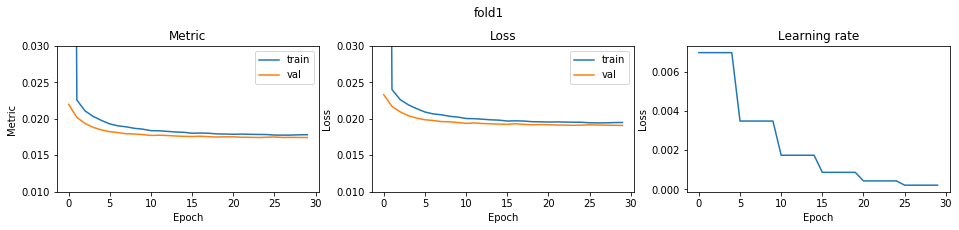

fold 2


epoch1 save best model... 0.021980512306674735
epoch2 save best model... 0.020220688336475154
epoch3 save best model... 0.019445872904448908
epoch4 save best model... 0.018752820414865947
epoch5 save best model... 0.01836898283980741
epoch6 save best model... 0.018194422694710357
epoch7 save best model... 0.01804749972143907
epoch8 save best model... 0.01794648188422864
epoch9 save best model... 0.01785273698393462
epoch10 save best model... 0.017751056340213896
epoch11 save best model... 0.017600597791232832
epoch12 save best model... 0.01757409662393631
epoch13 save best model... 0.01755144560463874
epoch14 save best model... 0.017489190561381564
epoch15 save best model... 0.017445416581653793
epoch18 save best model... 0.017394160047830454
epoch19 save best model... 0.01738179131886544
epoch20 save best model... 0.01736411493671364
epoch23 save best model... 0.017330411435197212
epoch24 save best model... 0.017299732390479675
epoch25 save best model... 0.017297755855125645
epoch26 s

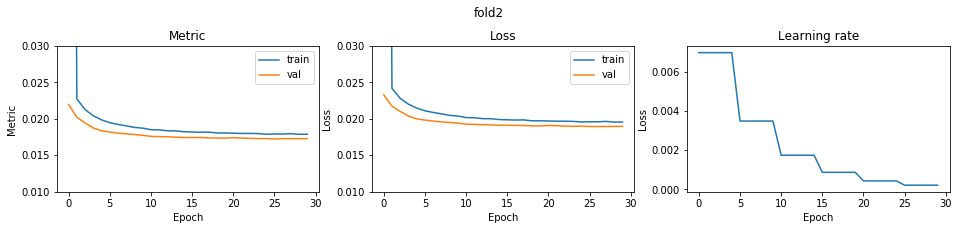

fold 3


epoch1 save best model... 0.02203834177268529
epoch2 save best model... 0.020240196227127843
epoch3 save best model... 0.019476362957209687
epoch4 save best model... 0.018938837397275046
epoch5 save best model... 0.01852636477593884
epoch6 save best model... 0.018335471414284175
epoch7 save best model... 0.018223770882654297
epoch8 save best model... 0.018070107985262446
epoch9 save best model... 0.01793176460680223
epoch10 save best model... 0.017877120309104138
epoch11 save best model... 0.017847796161245377
epoch12 save best model... 0.01776359784406247
epoch13 save best model... 0.01775808899550951
epoch14 save best model... 0.017716716068684375
epoch15 save best model... 0.017675253739135005
epoch16 save best model... 0.01763509276083295
epoch17 save best model... 0.017590937697687156
epoch19 save best model... 0.0175713720478983
epoch21 save best model... 0.017560516954198108
epoch23 save best model... 0.017533373702444763
epoch26 save best model... 0.017531169184265078
epoch27 s

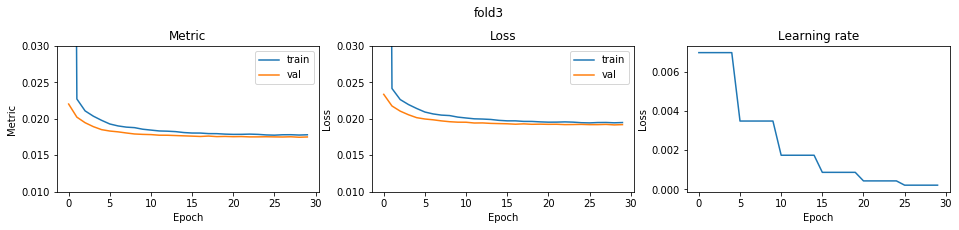

fold 4


epoch1 save best model... 0.022004489057563702
epoch2 save best model... 0.020007043411628532
epoch3 save best model... 0.019237014019102334
epoch4 save best model... 0.01861082811782599
epoch5 save best model... 0.018302602975168912
epoch6 save best model... 0.018096137761322947
epoch7 save best model... 0.017972857789359222
epoch8 save best model... 0.01794155065207859
epoch9 save best model... 0.017782625936582717
epoch10 save best model... 0.01767048298642209
epoch11 save best model... 0.01761877844131346
epoch12 save best model... 0.017581658450576874
epoch13 save best model... 0.017552474281986103
epoch14 save best model... 0.01750521725064869
epoch15 save best model... 0.017452471756327533
epoch17 save best model... 0.017428822648671193
epoch18 save best model... 0.017422312255397202
epoch19 save best model... 0.017399572870844725
epoch20 save best model... 0.017393696381114338
epoch22 save best model... 0.01736092034320014
epoch25 save best model... 0.01732925551907416
epoch28 

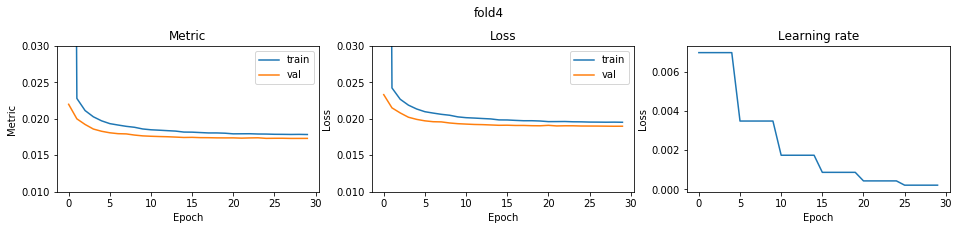

CV score: 0.017353307766301573


In [24]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [25]:
score_dict

{'AggMo': 0.019807094258687298,
 'Apollo': 0.6252036776780386,
 'PID': 0.6238966582817388,
 'QHM': 0.6271493913762753,
 'SGDP': 0.6255297095443629,
 'SGDW': 0.6289395578722783,
 'SGD': 0.6258163656156499,
 'AdaBelief': 0.0163747495209531,
 'AdaBound': 0.020631278524448352,
 'AdaMod': 0.016372116980252472,
 'AdamW': 0.01638112400518983,
 'AdamP': 0.01637096598764824,
 'DiffGrad': 0.01635575955236999,
 'Lamb': 0.016384524425128652,
 'NovoGrad': 0.016260348376987813,
 'PlainRAdam': 0.01635748821975219,
 'QHAdam': 0.01642333709647967,
 'RAdam': 0.01634141041373043,
 'Ranger': 0.01632502885984623,
 'RangerQH': 0.01631205422481342,
 'RangerVA': 0.019956317608243727,
 'SWATS': 0.016514590510321576,
 'Yogi': 0.01679990986081571,
 'Adam': 0.016411897255590766,
 'LookaheadAdam': 0.016361025442653013,
 'LookaheadDiffGrad': 0.016286184414022898,
 'LookaheadYogi': 0.017353307766301607}

In [26]:
CFG.optimizer = optimizer
logger.info('')
logger.info('optimizer: '+ optimizer.__name__)
oof, predictions = run_kfold_nn(CFG,
                                trn_df,
                                test_df,
                                CFG.feature_cols,
                                CFG.target_cols,
                                n_fold=5)

# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
score_dict[optimizer.__name__] = score


optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.022163726233268382
epoch2 save best model... 0.02007349947200142
epoch3 save best model... 0.019323407824666735
epoch4 save best model... 0.018660627257986874
epoch5 save best model... 0.01832181725455851
epoch6 save best model... 0.018125743164356313
epoch7 save best model... 0.018052933130048403
epoch8 save best model... 0.01788169669415929
epoch9 save best model... 0.017748188046666377
epoch10 save best model... 0.017686687707731283
epoch11 save best model... 0.017592362053946917


KeyboardInterrupt: 

In [27]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

metric
AggMo              0.019807
Apollo             0.625204
PID                0.623897
QHM                0.627149
SGDP               0.625530
SGDW               0.628940
SGD                0.625816
AdaBelief          0.016375
AdaBound           0.020631
AdaMod             0.016372
AdamW              0.016381
AdamP              0.016371
DiffGrad           0.016356
Lamb               0.016385
NovoGrad           0.016260
PlainRAdam         0.016357
QHAdam             0.016423
RAdam              0.016341
Ranger             0.016325
RangerQH           0.016312
RangerVA           0.019956
SWATS              0.016515
Yogi               0.016800
Adam               0.016412
LookaheadAdam      0.016361
LookaheadDiffGrad  0.016286
LookaheadYogi      0.017353

In [28]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                     metric
AggMo              0.019807
Apollo             0.625204
PID                0.623897
QHM                0.627149
SGDP               0.625530
SGDW               0.628940
SGD                0.625816
AdaBelief          0.016375
AdaBound           0.020631
AdaMod             0.016372
AdamW              0.016381
AdamP              0.016371
DiffGrad           0.016356
Lamb               0.016385
NovoGrad           0.016260
PlainRAdam         0.016357
QHAdam             0.016423
RAdam              0.016341
Ranger             0.016325
RangerQH           0.016312
RangerVA           0.019956
SWATS              0.016515
Yogi               0.016800
Adam               0.016412
LookaheadAdam      0.016361
LookaheadDiffGrad  0.016286
LookaheadYogi      0.017353


In [29]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}

In [30]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

metric
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW              0.016381
Lamb               0.016385
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940

In [31]:
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))

                     metric
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW              0.016381
Lamb               0.016385
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940



optimizer: RangerLars
fold 0


epoch1 save best model... 0.021637926821794218
epoch2 save best model... 0.01997935277471374
epoch3 save best model... 0.01872317914284579
epoch4 save best model... 0.018065658331358623
epoch5 save best model... 0.017639911479416362
epoch6 save best model... 0.017386815522146118
epoch7 save best model... 0.01705118422067654
epoch8 save best model... 0.016884056034928575
epoch9 save best model... 0.01676511890032161
epoch10 save best model... 0.016641167442660126
epoch11 save best model... 0.01647785342975195
epoch12 save best model... 0.01639418567791751
epoch13 save best model... 0.01632646741621315
epoch14 save best model... 0.01626320611727944
epoch15 save best model... 0.01621434903260244
epoch16 save best model... 0.016164054786086353
epoch17 save best model... 0.016137928876321518
epoch19 save best model... 0.01612844734637232
epoch20 save best model... 0.01612802486026613
epoch21 save best model... 0.016083480041805053
epoch24 save best model... 0.016079449048584035
epoch26 save

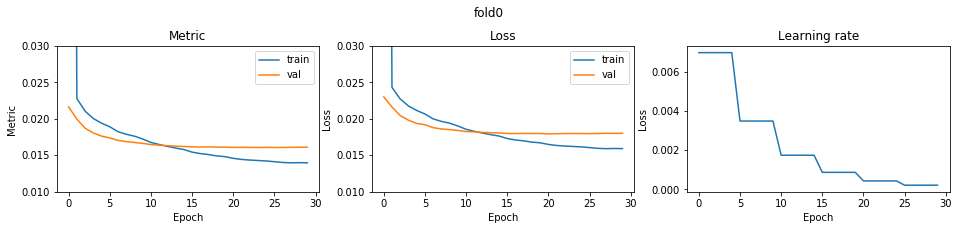

fold 1


epoch1 save best model... 0.02150340673701927
epoch2 save best model... 0.019778785194567598
epoch3 save best model... 0.01867022955954401
epoch4 save best model... 0.018161014634008207
epoch5 save best model... 0.01785453800710398
epoch6 save best model... 0.017388021180227545
epoch7 save best model... 0.017236420291856416
epoch8 save best model... 0.01709563111600768
epoch9 save best model... 0.017025830852252715
epoch10 save best model... 0.016837711599404
epoch11 save best model... 0.016653460346282845
epoch12 save best model... 0.016587887662951998
epoch13 save best model... 0.016553434516787258
epoch14 save best model... 0.01648833756677774
epoch15 save best model... 0.01646984308150865
epoch16 save best model... 0.01638274985361538
epoch17 save best model... 0.01637136063027739
epoch18 save best model... 0.01635723549208043
epoch21 save best model... 0.01635243414841146
fold1 score: 0.0163524341211995


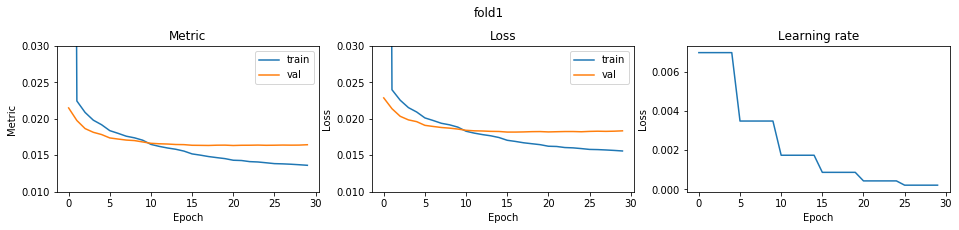

fold 2


epoch1 save best model... 0.021779980608082818
epoch2 save best model... 0.019914957738633606
epoch3 save best model... 0.018924642935239065
epoch4 save best model... 0.018161755081925666
epoch5 save best model... 0.01773960416443522
epoch6 save best model... 0.01733329110475642
epoch7 save best model... 0.017237160272308934
epoch8 save best model... 0.017131352107730004
epoch9 save best model... 0.016810179130600945
epoch10 save best model... 0.0167364218030579
epoch11 save best model... 0.01650768296619528
epoch12 save best model... 0.016414174206782362
epoch13 save best model... 0.01639356378845295
epoch14 save best model... 0.016333529829221833
epoch15 save best model... 0.016332610984757037
epoch16 save best model... 0.016233835648384567
epoch17 save best model... 0.016205413845883573
epoch18 save best model... 0.016203319953487602
epoch19 save best model... 0.016192705467458764
epoch22 save best model... 0.016187760635818307
epoch26 save best model... 0.01617632120721234
fold2 sc

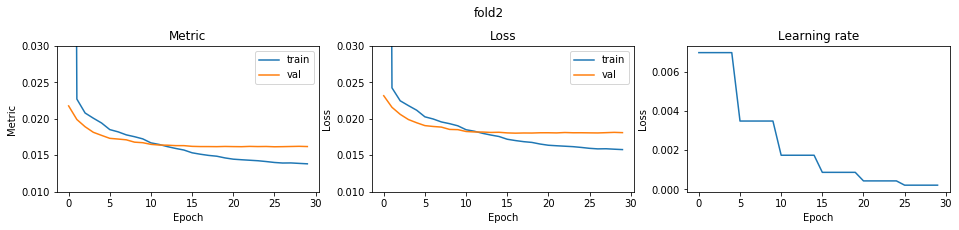

fold 3


epoch1 save best model... 0.02172071332693236
epoch2 save best model... 0.01982261196695319
epoch3 save best model... 0.019045525198221072
epoch4 save best model... 0.018232112045660786
epoch5 save best model... 0.017983970671875193
epoch6 save best model... 0.017445099641036473
epoch7 save best model... 0.01738138758409811
epoch8 save best model... 0.01719986684408234
epoch9 save best model... 0.0170309815084846
epoch10 save best model... 0.016896070283254214
epoch11 save best model... 0.016734949876564917
epoch12 save best model... 0.01672087270673152
epoch13 save best model... 0.016630697779034972
epoch14 save best model... 0.01655415622538681
epoch15 save best model... 0.016465616878334238
epoch16 save best model... 0.016394793660144465
epoch17 save best model... 0.016385371886736846
epoch18 save best model... 0.016345631930731016
epoch20 save best model... 0.016320035844226633
epoch22 save best model... 0.0162999686655633
fold3 score: 0.01629996851952018


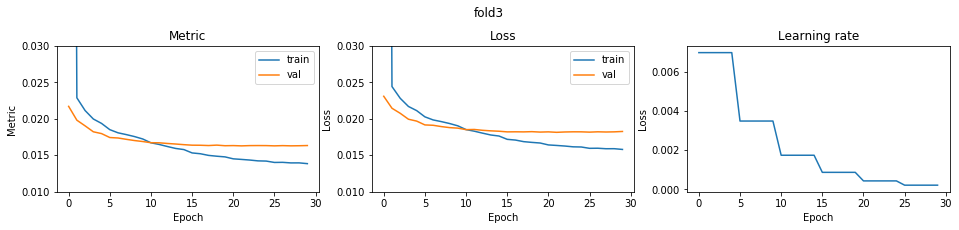

fold 4


epoch1 save best model... 0.021723842604726484
epoch2 save best model... 0.019518636404653344
epoch3 save best model... 0.018638467111100777
epoch4 save best model... 0.01795040229993081
epoch5 save best model... 0.017797202289800303
epoch6 save best model... 0.017327903794519314
epoch7 save best model... 0.017191906329795954
epoch8 save best model... 0.017014550446937865
epoch9 save best model... 0.016935715895222504
epoch10 save best model... 0.01680748633369973
epoch11 save best model... 0.01663745699963768
epoch12 save best model... 0.01661543561048076
epoch13 save best model... 0.016558859695877736
epoch14 save best model... 0.016504794354539932
epoch15 save best model... 0.01646848228295463
epoch16 save best model... 0.0163957662337326
epoch18 save best model... 0.016375192322668562
epoch19 save best model... 0.016357047822334908
epoch21 save best model... 0.016324282671772536
fold4 score: 0.016324282637486438


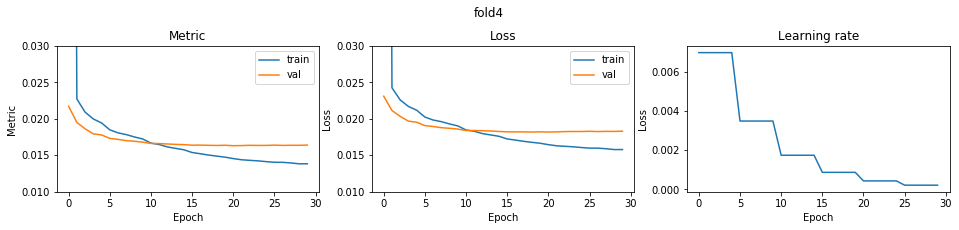

CV score: 0.016246440478654676


In [32]:
optimizer = RangerLars
CFG.optimizer = optimizer
logger.info('')
logger.info('optimizer: '+ optimizer.__name__)
oof, predictions = run_kfold_nn(CFG,
                                trn_df,
                                test_df,
                                CFG.feature_cols,
                                CFG.target_cols,
                                n_fold=5)

# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
score_dict[optimizer.__name__] = score

In [33]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
RangerLars         0.016246
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW              0.016381
Lamb               0.016385
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940


metric
RangerLars         0.016246
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW              0.016381
Lamb               0.016385
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.019915973803278798
epoch2 save best model... 0.018694357618961085
epoch3 save best model... 0.017915600090200646
epoch4 save best model... 0.017609292384160678
epoch5 save best model... 0.01732308361127735
epoch6 save best model... 0.017044545702449555
epoch7 save best model... 0.01690578208239176
epoch8 save best model... 0.016828051895106843
epoch9 save best model... 0.016708928372091477
epoch11 save best model... 0.016387601892606
epoch12 save best model... 0.016317949855619518
epoch14 save best model... 0.016300989107010305
epoch16 save best model... 0.016205529705250046
fold0 score: 0.016205529613057223


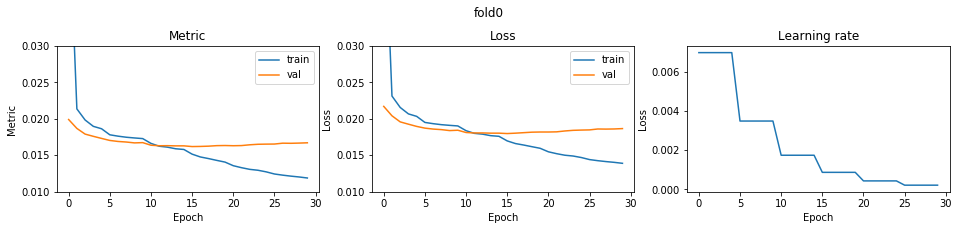

fold 1


epoch1 save best model... 0.020388259593797153
epoch2 save best model... 0.018585356115347625
epoch3 save best model... 0.018082128797812052
epoch4 save best model... 0.017708816571302473
epoch5 save best model... 0.017593412080134176
epoch6 save best model... 0.01710534748623619
epoch8 save best model... 0.017061259695998247
epoch10 save best model... 0.016999332723796612
epoch11 save best model... 0.016730956298652015
epoch12 save best model... 0.01669715887742356
epoch13 save best model... 0.016641850374667894
epoch16 save best model... 0.016493265272819878
fold1 score: 0.016493265171877897


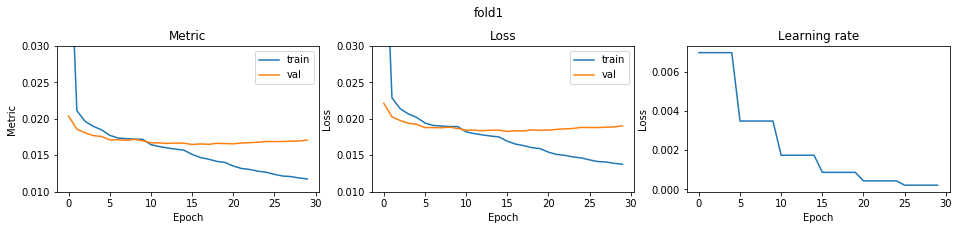

fold 2


epoch1 save best model... 0.019927139806916173
epoch2 save best model... 0.01857256174713923
epoch3 save best model... 0.018063909765888887
epoch4 save best model... 0.017805802120427577
epoch5 save best model... 0.01764830652608242
epoch6 save best model... 0.01709169679142893
epoch7 save best model... 0.017090126145295807
epoch9 save best model... 0.016913912617863514
epoch10 save best model... 0.016831219931786438
epoch11 save best model... 0.016514588679373943
epoch12 save best model... 0.016512748546173506
epoch13 save best model... 0.016460656143867512
epoch15 save best model... 0.016433052235896414
epoch16 save best model... 0.016272794830025694
fold2 score: 0.01627279486639593


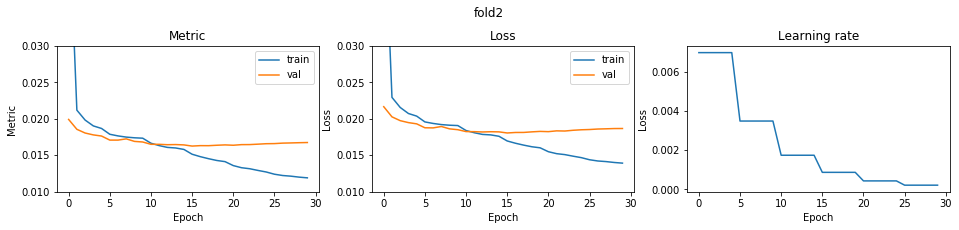

fold 3


epoch1 save best model... 0.019838826682477984
epoch2 save best model... 0.018692488860177697
epoch3 save best model... 0.01806731936320289
epoch4 save best model... 0.01793782026093275
epoch5 save best model... 0.017695568526133996
epoch6 save best model... 0.01735577995216385
epoch7 save best model... 0.017100898921914007
epoch9 save best model... 0.01709748685809705
epoch10 save best model... 0.016996150570316983
epoch11 save best model... 0.016675284522286445
epoch12 save best model... 0.016638632827270818
epoch15 save best model... 0.016591218847077094
epoch16 save best model... 0.01648525160086046
epoch17 save best model... 0.016481022459957622
fold3 score: 0.01648102233462481


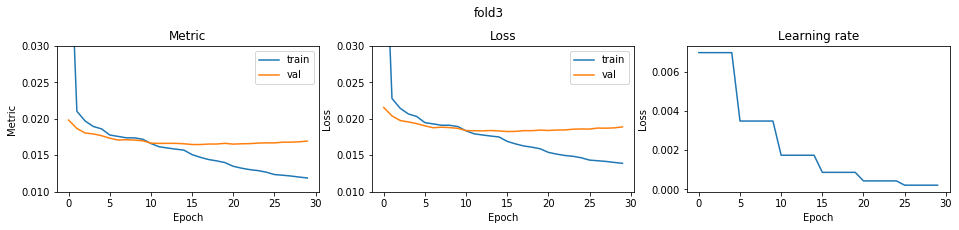

fold 4


epoch1 save best model... 0.019445502040122797
epoch2 save best model... 0.01868122516110845
epoch3 save best model... 0.017877944933509363
epoch4 save best model... 0.017609237748408234
epoch5 save best model... 0.01751856131941623
epoch6 save best model... 0.01711774565033394
epoch7 save best model... 0.017071929890110853
epoch8 save best model... 0.017003146755871848
epoch9 save best model... 0.016954133562438172
epoch10 save best model... 0.01692147713349729
epoch11 save best model... 0.01665396100092586
epoch12 save best model... 0.016592406145040293
epoch16 save best model... 0.01647544806496429
epoch17 save best model... 0.016449439463233215
fold4 score: 0.016449439345274156


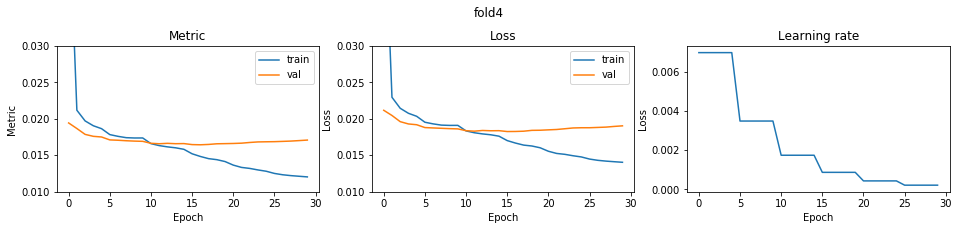

CV score: 0.016380410027522392

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.02030341405854274
epoch2 save best model... 0.01882155543715101
epoch3 save best model... 0.01814686205823628
epoch4 save best model... 0.01771485893085497
epoch5 save best model... 0.017405603435696665
epoch6 save best model... 0.017053985926651465
epoch7 save best model... 0.016975440307263633
epoch8 save best model... 0.01691859101617798
epoch9 save best model... 0.016825541167399063
epoch10 save best model... 0.01672639648487329
epoch11 save best model... 0.01644889934747936
epoch12 save best model... 0.01636275921636399
epoch13 save best model... 0.016312623224677286
epoch14 save best model... 0.016243476186855642
epoch15 save best model... 0.016225891363444253
epoch16 save best model... 0.016206549586206334
epoch17 save best model... 0.016191877381014796
fold0 score: 0.01619187726821877


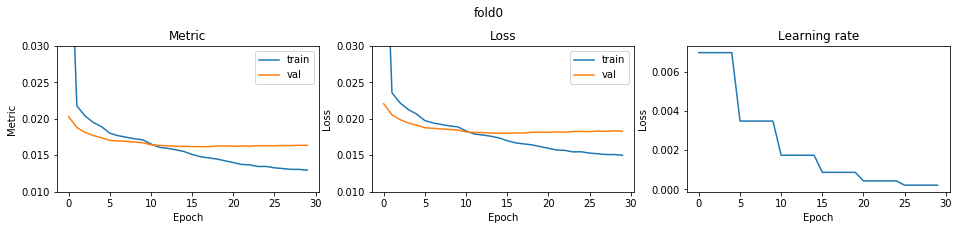

fold 1


epoch1 save best model... 0.020072570423291955
epoch2 save best model... 0.019012881075807626
epoch3 save best model... 0.01833610131862998
epoch4 save best model... 0.017813832597757397
epoch5 save best model... 0.017634552318028178
epoch6 save best model... 0.017226631990592527
epoch7 save best model... 0.017112601761052403
epoch8 save best model... 0.017069490610751945
epoch9 save best model... 0.016963382935464233
epoch10 save best model... 0.01695456105123337
epoch11 save best model... 0.016741525145206413
epoch12 save best model... 0.016724077619927964
epoch13 save best model... 0.01665137846495614
epoch14 save best model... 0.016550512153652743
fold1 score: 0.016550512224202663


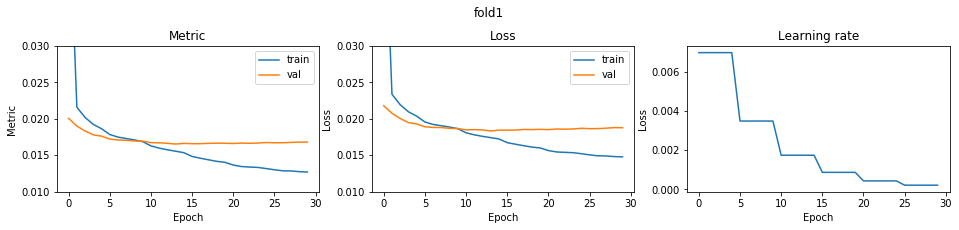

fold 2


epoch1 save best model... 0.02041298386127972
epoch2 save best model... 0.019051775463794583
epoch3 save best model... 0.018431248300975984
epoch4 save best model... 0.018073161921998
epoch5 save best model... 0.017637369565209077
epoch6 save best model... 0.017114667700827257
epoch7 save best model... 0.016994386403610274
epoch8 save best model... 0.01690330145989648
epoch9 save best model... 0.016783779195882677
epoch10 save best model... 0.01670621577790357
epoch11 save best model... 0.016491933210565538
epoch12 save best model... 0.01644559813831846
epoch13 save best model... 0.01640550540511892
epoch14 save best model... 0.016370076050620724
epoch15 save best model... 0.016354544591994674
epoch16 save best model... 0.016218562384247848
fold2 score: 0.01621856240034237


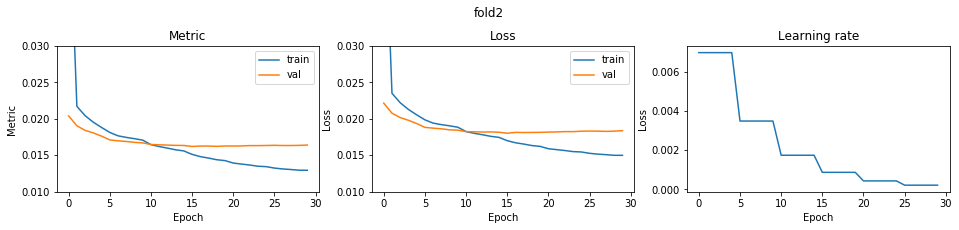

fold 3


epoch1 save best model... 0.020035995843826638
epoch2 save best model... 0.019100655148607724
epoch3 save best model... 0.018205639373740194
epoch4 save best model... 0.0179112136665231
epoch5 save best model... 0.017701778126825368
epoch6 save best model... 0.01729477850045661
epoch7 save best model... 0.017136453031848665
epoch9 save best model... 0.0170616278955225
epoch10 save best model... 0.016972908950018312
epoch11 save best model... 0.016725367300449986
epoch12 save best model... 0.016672362546290106
epoch13 save best model... 0.016642103283103886
epoch14 save best model... 0.016639300269458722
epoch15 save best model... 0.016581015721608403
epoch16 save best model... 0.016534197805682726
epoch18 save best model... 0.016518069184247346
fold3 score: 0.01651806905676725


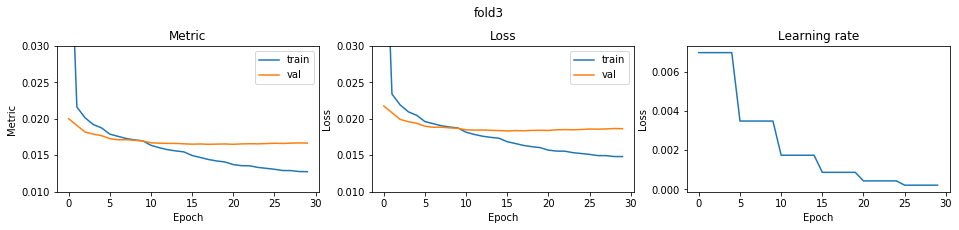

fold 4


epoch1 save best model... 0.020021464492370435
epoch2 save best model... 0.018906818621352756
epoch3 save best model... 0.018272998323982288
epoch4 save best model... 0.017885071334931873
epoch5 save best model... 0.01748956373313565
epoch6 save best model... 0.01713855929783034
epoch7 save best model... 0.017031800132966124
epoch8 save best model... 0.01699453765878577
epoch9 save best model... 0.01685833015133349
epoch11 save best model... 0.016638337334953162
epoch12 save best model... 0.016544491982252968
epoch13 save best model... 0.016522709063014573
epoch14 save best model... 0.016473017090290854
epoch15 save best model... 0.016467590645753306
epoch16 save best model... 0.016398129999162396
fold4 score: 0.01639812983480247


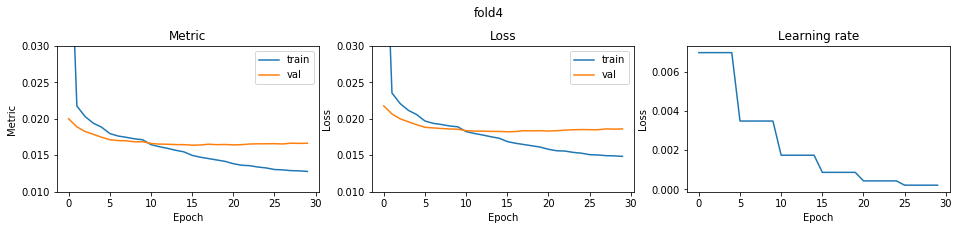

CV score: 0.01637542932698194

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.7005270531888975
epoch2 save best model... 0.6733410130329176
epoch3 save best model... 0.628301319744701
epoch4 save best model... 0.5230932005717163
epoch5 save best model... 0.37596382281503266
epoch6 save best model... 0.3348725973745142
epoch7 save best model... 0.2993458995107638
epoch8 save best model... 0.2640930716432037
epoch9 save best model... 0.22915628053468562
epoch10 save best model... 0.20139230775534428
epoch11 save best model... 0.1899177352157432
epoch12 save best model... 0.185220196741317
epoch13 save best model... 0.1793968825717722
epoch14 save best model... 0.16997058416010308
epoch15 save best model... 0.1656461494183486
epoch16 save best model... 0.16300683191941376
epoch17 save best model... 0.160090959975008
epoch19 save best model... 0.1580713112356994
epoch20 save best model... 0.15680622531096863
epoch22 save best model... 0.15656746788828682
epoch23 save best model... 0.15428205194940328
epoch26 save best model... 0.154024899

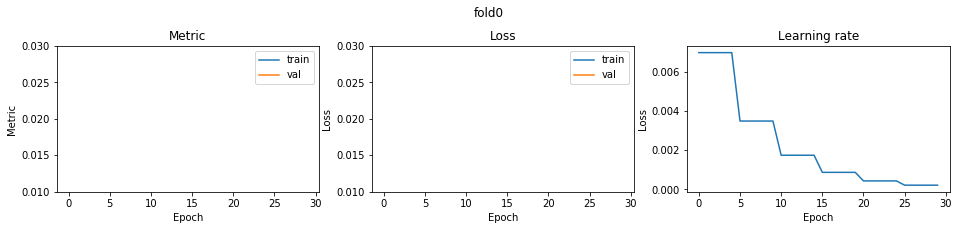

fold 1


epoch1 save best model... 0.7007655119618894
epoch2 save best model... 0.6763141297973568
epoch3 save best model... 0.6276127585356532
epoch4 save best model... 0.5275761853809318
epoch5 save best model... 0.37534775687638383
epoch6 save best model... 0.33828061207276755
epoch7 save best model... 0.29998447747566237
epoch8 save best model... 0.2620754780883967
epoch9 save best model... 0.22903191668823222
epoch10 save best model... 0.1997153046537733
epoch11 save best model... 0.1939031836939825
epoch12 save best model... 0.1855432648516429
epoch13 save best model... 0.1776617583244747
epoch14 save best model... 0.17072184253836253
epoch15 save best model... 0.1644649627330119
epoch16 save best model... 0.16237300058233084
epoch17 save best model... 0.1612906174878103
epoch18 save best model... 0.16102132729135196
epoch19 save best model... 0.1598880225289626
epoch20 save best model... 0.1570319965003047
epoch21 save best model... 0.1560834354856178
epoch23 save best model... 0.1552123

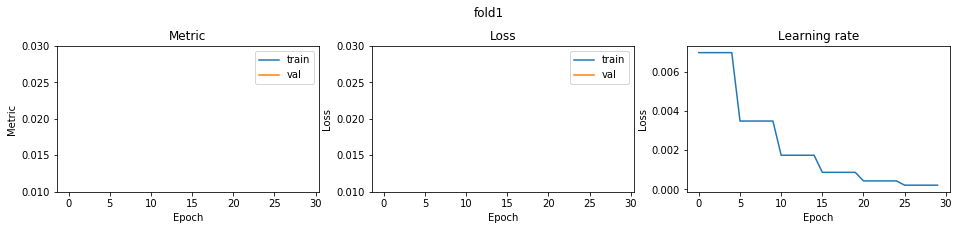

fold 2


epoch1 save best model... 0.7016400546955883
epoch2 save best model... 0.6783766469751195
epoch3 save best model... 0.6300102673567735
epoch4 save best model... 0.526780000931311
epoch5 save best model... 0.37546001747844704
epoch6 save best model... 0.335473315710086
epoch7 save best model... 0.29731153210764677
epoch8 save best model... 0.2625834913412947
epoch9 save best model... 0.22919074879009865
epoch10 save best model... 0.19999172027384293
epoch11 save best model... 0.19240407334030774
epoch12 save best model... 0.18702983995400901
epoch13 save best model... 0.17920143610661382
epoch14 save best model... 0.1713507827205847
epoch15 save best model... 0.16516424955214093
epoch16 save best model... 0.16288197583436803
epoch17 save best model... 0.16191769479741047
epoch18 save best model... 0.15856461992878174
epoch21 save best model... 0.15694449981515407
epoch22 save best model... 0.15628949089171432
epoch24 save best model... 0.15555386998966306
epoch28 save best model... 0.15

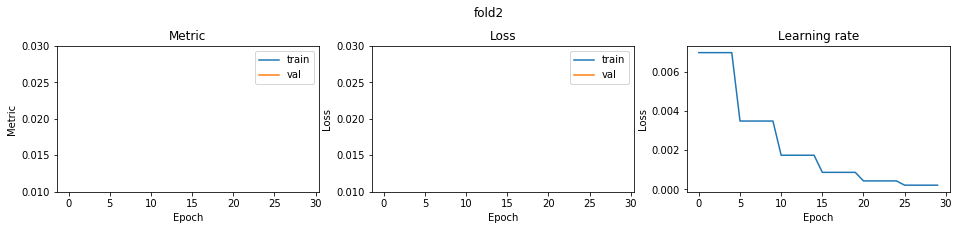

fold 3


epoch1 save best model... 0.7011819684152452
epoch2 save best model... 0.6801210892227625
epoch3 save best model... 0.6352281344778717
epoch4 save best model... 0.532757855683633
epoch5 save best model... 0.37566044651022806
epoch6 save best model... 0.3361332718630858
epoch7 save best model... 0.30144117531580916
epoch8 save best model... 0.26405185568305517
epoch9 save best model... 0.22994260815118603
epoch10 save best model... 0.19826030661277727
epoch11 save best model... 0.19096672640167228
epoch12 save best model... 0.1837815067762666
epoch13 save best model... 0.17988010864866077
epoch14 save best model... 0.17231405010120202
epoch15 save best model... 0.16421220587706511
epoch16 save best model... 0.1640274060817949
epoch17 save best model... 0.1628740819752352
epoch18 save best model... 0.1611657343584204
epoch19 save best model... 0.15739421236895212
epoch20 save best model... 0.15701793557147503
epoch21 save best model... 0.15438471548513835
epoch29 save best model... 0.152

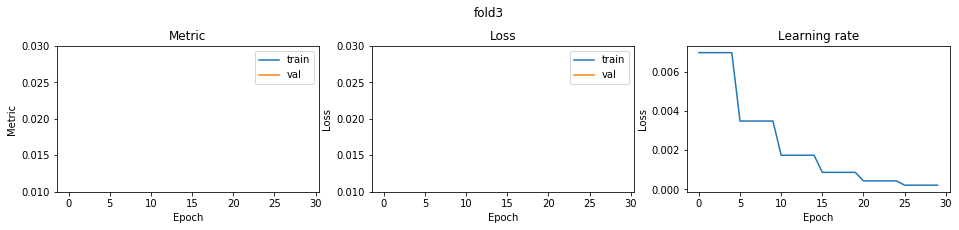

fold 4


epoch1 save best model... 0.6991558328304855
epoch2 save best model... 0.6779485183316103
epoch3 save best model... 0.6308873633860456
epoch4 save best model... 0.523405831061083
epoch5 save best model... 0.3754247959898382
epoch6 save best model... 0.33547411646549685
epoch7 save best model... 0.301030703707002
epoch8 save best model... 0.2639456550732832
epoch9 save best model... 0.2287781001019858
epoch10 save best model... 0.19834302462179187
epoch11 save best model... 0.1922782629388883
epoch12 save best model... 0.1845104070282743
epoch13 save best model... 0.17763001497215453
epoch14 save best model... 0.1716668396237771
epoch15 save best model... 0.16591753557086805
epoch16 save best model... 0.16320398289005958
epoch17 save best model... 0.1610413312572553
epoch18 save best model... 0.15695539860220326
epoch20 save best model... 0.15590068176558458
epoch21 save best model... 0.15463033800516152
epoch25 save best model... 0.15253217583500986
epoch30 save best model... 0.1522133

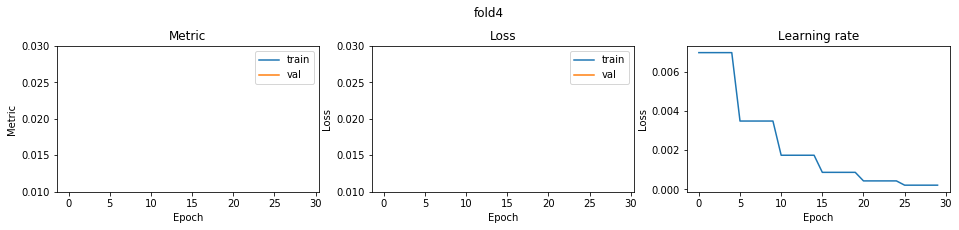

CV score: 0.15278725490411627

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.020405243213260905
epoch2 save best model... 0.018887204275485594
epoch3 save best model... 0.018244659007104765
epoch4 save best model... 0.017842725515026168
epoch5 save best model... 0.017523121449392044
epoch6 save best model... 0.017135115632265465
epoch7 save best model... 0.016988532247704906
epoch8 save best model... 0.016906364214158955
epoch9 save best model... 0.0166838635794462
epoch11 save best model... 0.016394259721244385
epoch12 save best model... 0.016363313679577007
epoch13 save best model... 0.016306054899320514
epoch16 save best model... 0.016253513735050764
epoch17 save best model... 0.016240951639508876
epoch18 save best model... 0.016226684935136373
fold0 score: 0.01622668476442631


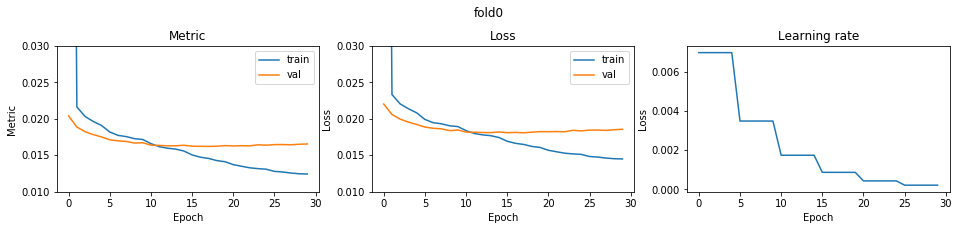

fold 1


epoch1 save best model... 0.020479921857139115
epoch2 save best model... 0.019329792582895713
epoch3 save best model... 0.018429529045764285
epoch4 save best model... 0.017769681091177814
epoch5 save best model... 0.01767925958546576
epoch6 save best model... 0.017241900958210793
epoch7 save best model... 0.017150339295319054
epoch9 save best model... 0.01697289549012911
epoch11 save best model... 0.016780060318320494
epoch12 save best model... 0.016676327568434533
epoch13 save best model... 0.01662065792407804
epoch16 save best model... 0.01655757429740693
epoch17 save best model... 0.016547888296697264
fold1 score: 0.016547888199995867


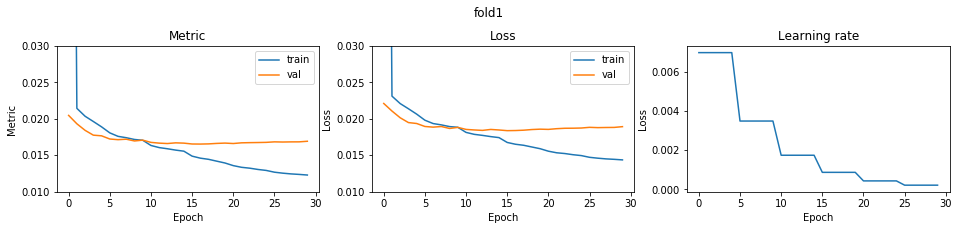

fold 2


epoch1 save best model... 0.020216534798211568
epoch2 save best model... 0.019001869937181337
epoch3 save best model... 0.018432457543872204
epoch4 save best model... 0.017928443978525534
epoch5 save best model... 0.01767502570349539
epoch6 save best model... 0.017158560912549414
epoch7 save best model... 0.016986396050814426
epoch8 save best model... 0.016956210844082928
epoch9 save best model... 0.01677420174613456
epoch11 save best model... 0.016544061803103416
epoch12 save best model... 0.016499411396633034
epoch14 save best model... 0.01642745996891814
epoch15 save best model... 0.01640328548349547
epoch16 save best model... 0.016304039008665883
epoch17 save best model... 0.016296709387116075
fold2 score: 0.016296709307831208


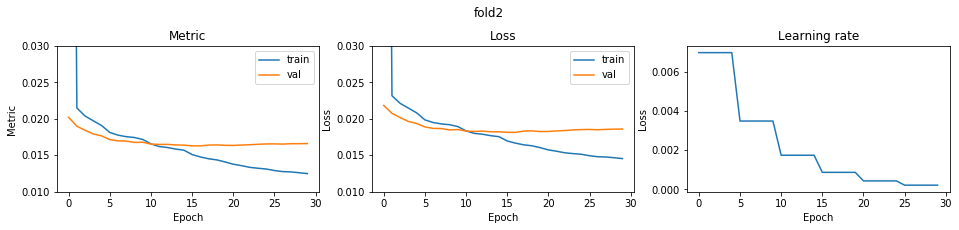

fold 3


epoch1 save best model... 0.02062521005104506
epoch2 save best model... 0.019076416140808333
epoch3 save best model... 0.018425231197411896
epoch4 save best model... 0.018046147750100813
epoch5 save best model... 0.01771563935626069
epoch6 save best model... 0.017189465645183057
epoch7 save best model... 0.01713644592961241
epoch9 save best model... 0.017061396581301114
epoch10 save best model... 0.017015750213591956
epoch11 save best model... 0.01666713289466765
epoch12 save best model... 0.016619211436590873
epoch13 save best model... 0.016580944619903126
epoch16 save best model... 0.016454641676692458
fold3 score: 0.0164546415418204


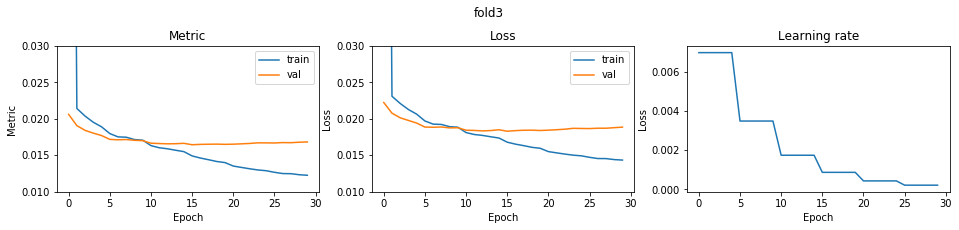

fold 4


epoch1 save best model... 0.020161472248223213
epoch2 save best model... 0.018769719266674242
epoch3 save best model... 0.018137155433773044
epoch4 save best model... 0.017812108957889684
epoch5 save best model... 0.017500037168723306
epoch6 save best model... 0.01711756966812939
epoch7 save best model... 0.016994335196471023
epoch9 save best model... 0.01695127979659206
epoch10 save best model... 0.016885174510062828
epoch11 save best model... 0.01661630619045746
epoch12 save best model... 0.016571045986425496
epoch13 save best model... 0.016538556893875903
epoch16 save best model... 0.016409849509562882
fold4 score: 0.01640984946976596


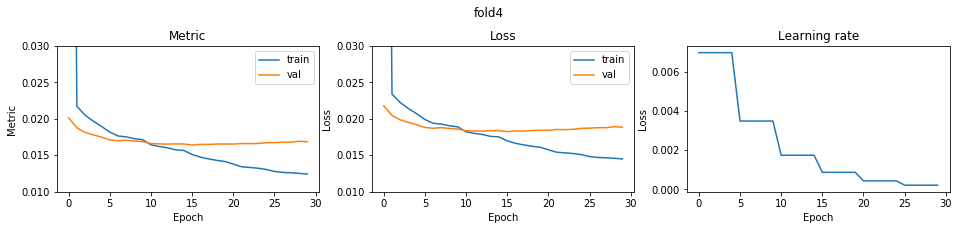

CV score: 0.01638715145428051

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021219649631742193
epoch2 save best model... 0.019375104564910327
epoch3 save best model... 0.01862858251110568
epoch4 save best model... 0.018082930355551304
epoch5 save best model... 0.017604429935845534
epoch6 save best model... 0.017275905303640083
epoch7 save best model... 0.017027644402345384
epoch8 save best model... 0.016995703983110014
epoch9 save best model... 0.01686307844241279
epoch10 save best model... 0.016689111585972794
epoch11 save best model... 0.01648492464850867
epoch12 save best model... 0.016405674705710388
epoch14 save best model... 0.016349818557076547
epoch15 save best model... 0.016328157475621254
epoch16 save best model... 0.01621290722984931
epoch17 save best model... 0.016179887238881446
epoch19 save best model... 0.01617959422400913
epoch21 save best model... 0.01614762341183587
fold0 score: 0.01614762346582757


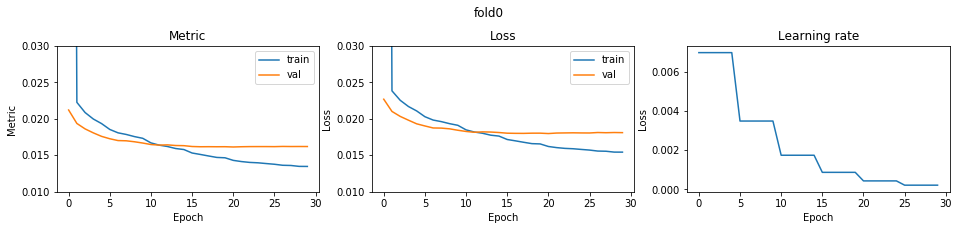

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02104754202147637
epoch2 save best model... 0.01953899009353983
epoch3 save best model... 0.018574458209334732
epoch4 save best model... 0.01819754436851485
epoch5 save best model... 0.017784423536671323
epoch6 save best model... 0.01741274397613981
epoch7 save best model... 0.01721197083986248
epoch8 save best model... 0.01711067079302661
epoch9 save best model... 0.017024724035317792
epoch10 save best model... 0.016983282696527862
epoch11 save best model... 0.01668073939773604
epoch12 save best model... 0.016675429751404354
epoch13 save best model... 0.01657874127678059
epoch14 save best model... 0.016567986274779345
epoch16 save best model... 0.01649598514002965
fold1 score: 0.01649598499165391


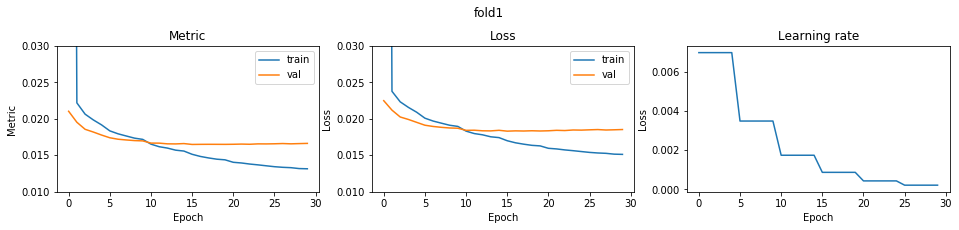

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021310960410952595
epoch2 save best model... 0.019625465107428564
epoch3 save best model... 0.01862059702121076
epoch4 save best model... 0.018171971246657866
epoch5 save best model... 0.017777860821809346
epoch6 save best model... 0.0173014160604266
epoch7 save best model... 0.01703825240602938
epoch8 save best model... 0.016944458972349488
epoch9 save best model... 0.016865488908434614
epoch10 save best model... 0.01679601999265807
epoch11 save best model... 0.016546311945072827
epoch12 save best model... 0.0163918857573682
epoch14 save best model... 0.01636655987841946
epoch15 save best model... 0.016329094054596274
epoch16 save best model... 0.016254070710614035
epoch18 save best model... 0.01620630525633112
fold2 score: 0.01620630516766812


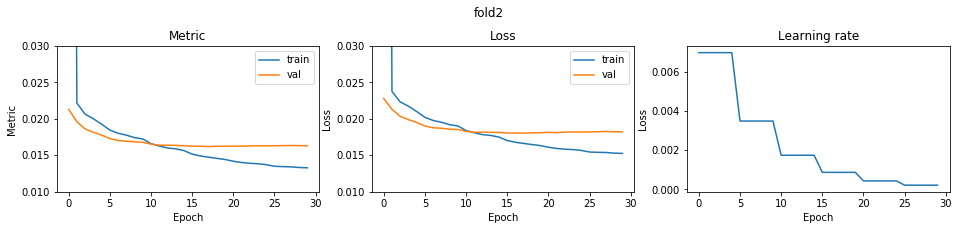

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021199134074507922
epoch2 save best model... 0.01966020032712566
epoch3 save best model... 0.018920194865087715
epoch4 save best model... 0.018123533199530664
epoch5 save best model... 0.017716232278216674
epoch6 save best model... 0.01738070516055768
epoch7 save best model... 0.017285181062215417
epoch8 save best model... 0.017138640437029083
epoch9 save best model... 0.017098524042560057
epoch10 save best model... 0.017020337970965544
epoch11 save best model... 0.016696693071064483
epoch12 save best model... 0.01660151735737343
epoch14 save best model... 0.01656721823239924
epoch15 save best model... 0.016528958901508385
epoch16 save best model... 0.01645066726969763
epoch17 save best model... 0.016414294578135015
fold3 score: 0.016414294489984792


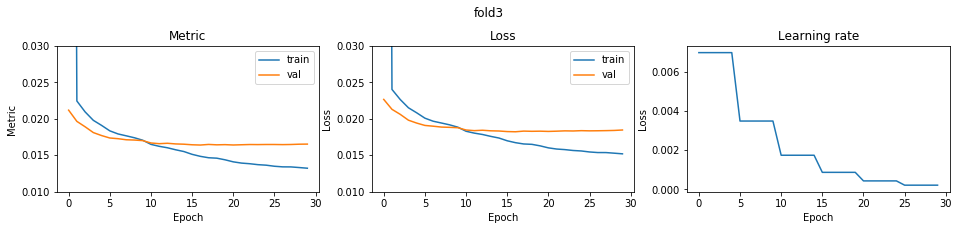

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02129774861682656
epoch2 save best model... 0.019373423710533317
epoch3 save best model... 0.018626599545019905
epoch4 save best model... 0.017886246354287334
epoch5 save best model... 0.017631493692110232
epoch6 save best model... 0.017304212591082606
epoch7 save best model... 0.01705707915144249
epoch9 save best model... 0.016924761009565924
epoch10 save best model... 0.016845682069896836
epoch11 save best model... 0.01670237212550056
epoch12 save best model... 0.016625580556504004
epoch13 save best model... 0.016543785069808196
epoch14 save best model... 0.01649699780521469
epoch16 save best model... 0.016424902628657485
epoch17 save best model... 0.016326552972299364
epoch22 save best model... 0.01631534128261047
fold4 score: 0.016315341174402063


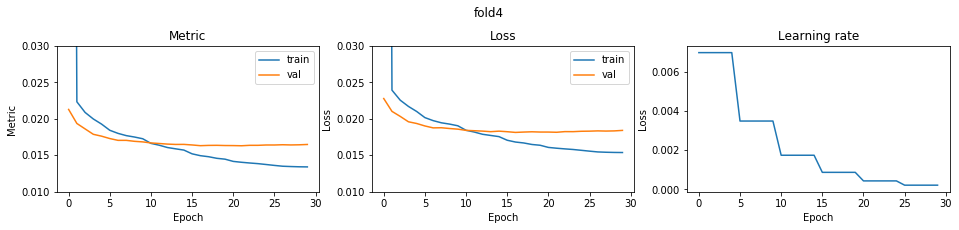

CV score: 0.01631590664711617
                     metric
RangerLars         0.016246
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger_CG          0.016316
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW_CG           0.016375
Adam_CG            0.016380
AdamW              0.016381
Lamb               0.016385
RAdam_CG           0.016387
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PlainRAdam_CG      0.152787
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940


metric
RangerLars         0.016246
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger_CG          0.016316
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW_CG           0.016375
Adam_CG            0.016380
AdamW              0.016381
Lamb               0.016385
RAdam_CG           0.016387
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PlainRAdam_CG      0.152787
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940

In [35]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
]

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score
    
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

In [36]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
RangerLars         0.016246
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger_CG          0.016316
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW_CG           0.016375
Adam_CG            0.016380
AdamW              0.016381
Lamb               0.016385
RAdam_CG           0.016387
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PlainRAdam_CG      0.152787
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940


metric
RangerLars         0.016246
NovoGrad           0.016260
LookaheadDiffGrad  0.016286
RangerQH           0.016312
Ranger_CG          0.016316
Ranger             0.016325
RAdam              0.016341
DiffGrad           0.016356
PlainRAdam         0.016357
LookaheadAdam      0.016361
AdamP              0.016371
AdaMod             0.016372
AdaBelief          0.016375
AdamW_CG           0.016375
Adam_CG            0.016380
AdamW              0.016381
Lamb               0.016385
RAdam_CG           0.016387
Adam               0.016412
QHAdam             0.016423
SWATS              0.016515
Yogi               0.016800
LookaheadYogi      0.017353
AggMo              0.019807
RangerVA           0.019956
AdaBound           0.020631
PlainRAdam_CG      0.152787
PID                0.623897
Apollo             0.625204
SGDP               0.625530
SGD                0.625816
QHM                0.627149
SGDW               0.628940

In [37]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')